In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests
import time
import re
import ast
import random

# Spotipy
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [102]:
# import the dataframes
# df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # all the albums from the UK
# df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # albums from the US until 1996, 1998 and 2000
# df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                 # albums from the US from 2000
# df_us_new_masters_clean = pd.read_csv('Datasets/df_us_new_masters_clean.csv')     # albums from the US from 2000 with >= 20 votes 
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
# df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df_artists_origins = pd.read_csv('Datasets/df_artists_origins.csv')
df_coordinates = pd.read_csv('Datasets/df_coordinates.csv')
df_coordinates_final = pd.read_csv('Datasets/df_coordinates_final.csv')
df_artists_origins_coordinates = pd.read_csv('Datasets/df_artists_origins_coordinates.csv')               # merge of df_masters_blended with their locations

df_concat = pd.read_csv('Datasets/other datasets/df_concat.csv')
df_final = pd.read_csv('Datasets/df_final.csv')
df_albums = pd.read_csv('Datasets/df_albums.csv')

# print information
# print(f'{df_uk_masters.shape}: df_uk_masters')
# print(f'{df_us_masters.shape}: df_us_masters')
# print(f'{df_us_new_masters.shape}: df_us_new_masters')
# print(f'{df_us_new_masters_clean.shape}: df_us_new_masters_clean')
print(f'{df_ratings_20.shape}: df_ratings_20')
# print(f'{df_masters_blended.shape}: df_masters_blended')
print(f'{df_artists_origins.shape}: df_artists_origins')
print(f'{df_coordinates.shape}: df_coordinates')
print(f'{df_coordinates_final.shape}: df_coordinates_final')
print(f'{df_artists_origins_coordinates.shape}: df_artists_origins_coordinates')

print(f'{df_concat.shape}: df_concat - unique albums')
print(f'{df_final.shape}: df_final - exploded with ratings')
print(f'{df_albums.shape}: df_albums')

(51222, 5): df_ratings_20
(6738, 2): df_artists_origins
(2776, 7): df_coordinates
(5633, 7): df_coordinates_final
(6705, 6): df_artists_origins_coordinates
(11062, 8): df_concat - unique albums
(16781, 10): df_final - exploded with ratings
(16845, 13): df_albums


# **Statistics**

In [4]:
df_albums = pd.read_csv('Datasets/df_albums.csv')
df_albums.shape

(16845, 13)

In [5]:
df_albums

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,subgenre,style,country,city,state
0,2007,!!!,Myth Takes,3.48,94,60.22,13,4.63,indie,Alternative Rock,United States,Sacramento,California
1,2007,!!!,Myth Takes,3.48,94,60.22,13,4.63,indie,Indie Rock,United States,Sacramento,California
2,2010,!!!,"Strange Weather, Isn't It?",3.06,41,40.80,9,4.53,indie,Indie Rock,United States,Sacramento,California
3,1985,'Til Tuesday,Voices Carry,3.60,26,38.62,10,3.86,indie,New Wave,United States,Boston,Massachusetts
4,1985,'Til Tuesday,Voices Carry,3.60,26,38.62,10,3.86,indie,Pop Rock,United States,Boston,Massachusetts
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,2007,xDEATHSTARx,We Are The Threat,2.70,20,35.58,11,3.23,metal,Metalcore,United States,Redlands,California
16841,2004,yourcodenameis:milo,Ignoto,3.77,50,47.41,12,3.95,indie,Alternative Rock,United Kingdom,Washington,England
16842,2007,yourcodenameis:milo,They Came From the Sun,3.46,27,49.48,12,4.12,indie,Emo,United Kingdom,Washington,England
16843,2007,yourcodenameis:milo,They Came From the Sun,3.46,27,49.48,12,4.12,indie,Indie Rock,United Kingdom,Washington,England


In [ ]:
df_albums[df_albums['city']=='Los Angeles'].shape

(1067, 13)

In [8]:
df_albums['city'].value_counts().head(10)

city
London           1264
Los Angeles      1067
New York City     634
Chicago           400
San Francisco     377
Seattle           358
Boston            349
Birmingham        222
Washington        197
San Diego         183
Name: count, dtype: int64

In [9]:
df_albums[df_albums['city']=='Blackpool'].query("country == 'United States'")

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,subgenre,style,country,city,state


In [ ]:
df_albums.city.nunique()

1083

In [ ]:
df_coordinates_final[df_coordinates_final['city']=='Manchester'].shape

(42, 7)

<Axes: xlabel='year', ylabel='avg_song_length'>

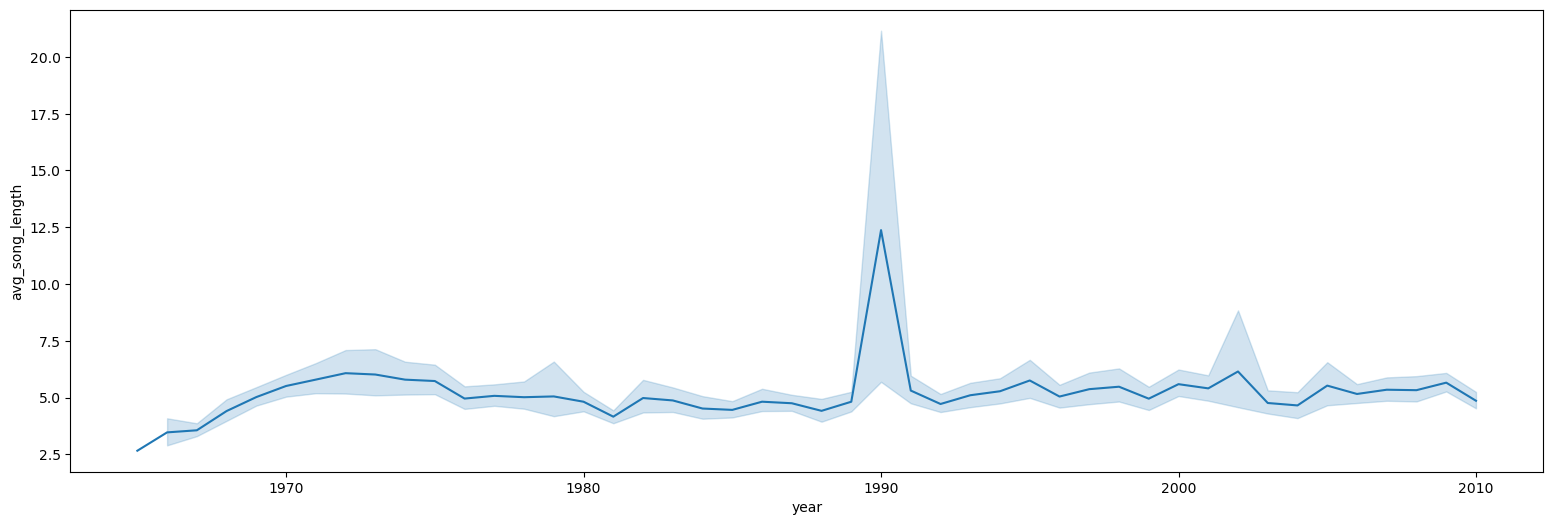

In [ ]:
plt.figure(figsize=(19,6))
sns.lineplot(data=df_albums[df_albums['subgenre']=='classic'], x='year', y='avg_song_length')

In [6]:
df_albums[df_albums['subgenre']=='classic'].query("year == 1990").sort_values('avg_song_length', ascending=False)['avg_song_length'].mean()

12.37590909090909

In [7]:
df_albums[df_albums['style']=='Doom Metal'].sort_values('avg_song_length')['avg_song_length'].mean()

7.613632812500001

In [126]:
df_test[df_test['year']==2013].query("style == 'Prog Rock'").sort_values('rating', ascending=False)

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
2988,Anathema,Universal,4.34,97,2013,79.45,33,classic,Prog Rock
2990,Haken,The Mountain,4.15,1036,2013,69.30,12,classic,Prog Rock
3313,Steven Wilson,The Raven That Refused to Sing (And Other Stor...,4.14,1536,2013,54.70,6,classic,Prog Rock
3022,Night Verses,Lift Your Existence,3.95,364,2013,73.75,15,classic,Prog Rock
3346,Coheed and Cambria,The Afterman: Descension,3.67,1039,2013,43.48,9,classic,Prog Rock
3273,Amplifier,Echo Street,3.48,66,2013,60.78,8,classic,Prog Rock


In [7]:
df_test[df_test['year']==2013].query("style == 'Prog Rock'")[['artist', 'title', 'rating', 'album_length', 'tracks']]\
    .sort_values('rating', ascending=False).head()

,artist,title,rating,album_length,tracks
2988,Anathema,Universal,4.34,79.45,33
2990,Haken,The Mountain,4.15,69.30,12
3313,Steven Wilson,The Raven That Refused to Sing (And Other Stor...,4.14,54.70,6
3022,Night Verses,Lift Your Existence,3.95,73.75,15
3346,Coheed and Cambria,The Afterman: Descension,3.67,43.48,9


In [54]:
df_style = df_test[df_test['year']==1970][['artist', 'title', 'rating']]\
                                            .groupby(['artist', 'title']).agg('mean')\
                                            .sort_values('rating', ascending=False)\
                                            .head()
df_style

,,rating
artist,title,
Black Sabbath,Paranoid,4.52
The Stooges,Fun House,4.42
Black Sabbath,Black Sabbath,4.38
George Harrison,All Things Must Pass,4.37
Van Morrison,Moondance,4.35


In [2]:
df_test[df_test['style']=='Black Metal'].sort_values('year').head(10)

NameError: name 'df_test' is not defined

In [118]:
df_test['artist'].value_counts().head(10)

artist
The Rolling Stones    51
Jethro Tull           45
Alice Cooper          43
Hawkwind              42
Black Sabbath         42
Elton John            41
The Cure              40
Bob Dylan             40
Uriah Heep            38
Deep Purple           36
Name: count, dtype: int64

In [120]:
df_test['title'].value_counts().head(10)

title
Phoenix                     9
What Doesn't Kill You...    8
13                          7
II                          7
Four                        7
Captain Beyond              7
Vultures                    6
Afterburner                 6
Madness                     6
Love                        6
Name: count, dtype: int64

In [117]:
df_test[df_test['artist']=='Slint']

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
11265,Slint,Spiderland,4.41,2377,1991,39.2,6,indie,Post Rock
11266,Slint,Spiderland,4.41,2377,1991,39.2,6,indie,Alternative Rock
11268,Slint,Tweez,3.33,535,1989,0.0,11,indie,Indie Rock
11269,Slint,Tweez,3.33,535,1989,0.0,11,indie,Post Rock


In [98]:
df_test[df_test['style']=='Heavy Metal'].sort_values('year').head(10)

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
14646,Black Sabbath,Paranoid,4.52,5144,1970,0.00,8,metal,Heavy Metal
6430,Sir Lord Baltimore,Kingdom Come,3.91,131,1970,37.72,10,metal,Heavy Metal
14452,Black Sabbath,Black Sabbath,4.38,3904,1970,38.28,7,metal,Heavy Metal
14161,Black Sabbath,Master Of Reality,4.45,3756,1971,0.00,8,metal,Heavy Metal
8203,Dust,Dust,3.81,42,1971,36.27,7,metal,Heavy Metal
10641,Captain Beyond,Captain Beyond,4.18,179,1972,37.95,13,metal,Heavy Metal
14442,Black Sabbath,Sabbath Bloody Sabbath,4.19,2587,1973,0.00,8,metal,Heavy Metal
14392,Deep Purple,Stormbringer,3.55,479,1974,36.58,9,metal,Heavy Metal
14599,Black Sabbath,Sabotage,4.02,1906,1975,43.70,9,metal,Heavy Metal
10997,Rainbow,Ritchie Blackmore's Rainbow,4.04,760,1975,37.23,9,metal,Heavy Metal


In [99]:
df_test.sort_values('rating')

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
4145,The Beach Boys,Summer in Paradise,1.19,170,1992,43.80,12,roots,Soft Rock
4144,The Beach Boys,Summer in Paradise,1.19,170,1992,43.80,12,indie,Pop Rock
5708,Discharge,Grave New World,1.23,90,1986,0.00,7,punk,Hardcore
5709,Discharge,Grave New World,1.23,90,1986,0.00,7,metal,Heavy Metal
553,Machine Gun Kelly,Mainstream Sellout,1.40,221,2022,0.00,16,punk,Pop Punk
...,...,...,...,...,...,...,...,...,...
11561,Yes,Close to the Edge,4.55,2680,1972,38.70,3,classic,Art Rock
11562,Yes,Close to the Edge,4.55,2680,1972,38.70,3,classic,Prog Rock
12665,The Beatles,Abbey Road,4.56,4957,1969,0.00,17,indie,Pop Rock
11699,Megadeth,Rust In Peace,4.56,5895,1990,40.73,9,metal,Thrash


In [132]:
df_test[df_test['year']<2011][['year', 'style', 'rating', 'title']]\
            .groupby(["year", "style"]).agg({'rating': 'max', 'title': 'count'})\
            .sort_values('rating', ascending=False)\
            .tail(20)

,,rating,title
year,style,,
1981,Folk Rock,2.88,2
2008,New Wave,2.88,1
2009,Symphonic Rock,2.85,1
1991,Black Metal,2.83,1
1966,Classic Rock,2.82,1
1985,Black Metal,2.82,1
1986,Classic Rock,2.79,5
1992,Classic Rock,2.75,2
1986,Symphonic Rock,2.75,2


In [115]:
df_test[df_test['year']<2011].groupby("artist")['title'].nunique().sort_values(ascending=False)

artist
Alice Cooper              27
Elton John                25
Bob Dylan                 24
The Rolling Stones        24
Jethro Tull               22
                          ..
Fastball                   1
Punch                      1
Pulley                     1
Pulled Apart By Horses     1
Mad Caddies                1
Name: title, Length: 2548, dtype: int64

# **``country``**

## Import dataframes and take quick look

# **``album_length = 0``**

In [ ]:
df_artists_origins = pd.read_csv('Datasets/df_artists_origins.csv')                             # df with only the bands and their city of origin
df_coordinates = pd.read_csv('Datasets/df_coordinates.csv')                                     # df with the full info of the locations (coordinates)
df_artists_origins_coordinates = pd.read_csv('Datasets/df_artists_origins_coordinates.csv')     # merge of the bands with the full info of the locations (coordinates)

# print information
print(f'{df_artists_origins.shape}: df_artists_origins')
print(f'{df_coordinates.shape}: df_coordinates')
print(f'{df_artists_origins_coordinates.shape}: df_artists_origins_coordinates')

(6737, 2): df_artists_origins
(2772, 7): df_coordinates
(6704, 6): df_artists_origins_coordinates
(9667, 13): df_masters_blended


In [13]:
# df with only the bands and their city of origin
df_artists_origins.head(2)

,artist,origin
0,Sparta,"El Paso, Texas"
1,Muse,"Teignmouth, Devon, England"


In [14]:
# df with the full info of the locations (coordinates)
df_coordinates.head(2)

,country,city,origin,origin_clean,latitude,longitude,address
0,Argentina,Buenos Aires,"Buenos Aires, Argentina","Buenos Aires, Argentina",-34.608370,-58.444058,"Buenos Aires, Comuna 6, Ciudad Autónoma de Bue..."
1,Argentina,Martínez,"Martínez, Buenos Aires, Argentina","Martínez, Buenos Aires, Argentina",-34.493967,-58.510352,"Martínez, Partido de San Isidro, Buenos Aires,..."


In [15]:
# merge of the bands with the full info of the locations (coordinates)
df_artists_origins_coordinates.head(2)

,artist,country,city,latitude,longitude,address
0,Sparta,United States,El Paso,31.760116,-106.48704,"El Paso, El Paso County, Texas, United States"
1,Muse,United Kingdom,Teignmouth,50.546338,-3.49578,"Teignmouth, Teignbridge, Devon, England, Unite..."


In [16]:
# albums from the UK and US (until 2000) with >= 20 votes
df_masters_blended.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."


## **Merge my dataframe with the locations and get only artists from UK or US**

In [61]:
df_us_new_masters_clean.shape

(6708, 13)

In [ ]:
# only albums until 2010, I scraped more years but I want to limit the dataset
df_us_new_masters_2010 = df_us_new_masters_clean[df_us_new_masters_clean['year']<2011]
df_us_new_masters_2010.shape

(5333, 13)

In [95]:
df_us_new_masters_2010['artist'].nunique()

2349

In [96]:
df_artists_origins['artist'].nunique()

6737

In [27]:
df_artists_countries = pd.merge(df_artists_origins, df_coordinates, on=['origin'])
df_artists_countries.drop(columns=['city', 'origin_clean', 'latitude', 'longitude', 'address'], inplace=True)
df_artists_countries

,artist,origin,country
0,Sparta,"El Paso, Texas",United States
1,Muse,"Teignmouth, Devon, England",United Kingdom
2,Finch,"Temecula, California, Estados Unidos",United States
3,Transplants,"Los Angeles, California, United States[1]",United States
4,Rooney,"Los Angeles, California, U.S.",United States
...,...,...,...
6700,Flake Music,"Albuquerque, New Mexico, U.S.",United States
6701,Until Your Heart Stops,"Oakland, CA, United States",United States
6702,Sleepercar,"El Paso, Texas, USA",United States
6703,Swamp Thing,"Rotorua, New Zealand",New Zealand / Aotearoa


In [31]:
df_artists_countries['country'].value_counts().head()

country
United States     4137
United Kingdom    1496
Canada             215
Sverige            156
Australia          133
Name: count, dtype: int64

In [30]:
4137+1496

5633

In [ ]:
# create the subset with only artists from the UK or US
df_artists_uk_us = df_artists_countries[df_artists_countries['country'].isin(['United States', 'United Kingdom'])]

# it should have 5633 rows
df_artists_uk_us.shape

(5633, 3)

### **Artists in ``artists_to_remove``, from outside the UK or US**

These are the artists that I dropped while getting the location and I realised they were not from the UK or US, from the list ``artists_to_remove``

In [75]:
artists_to_remove = ['Cemetery Skyline', 'Goat', 'Kingcrow', 'Speed', 'Hyperdontia', 'Vredehammer', 'Weston Super Maim',
                'Mdou Moctar', 'AVRALIZE', 'Engulfed', 'Coffin Storm', 'samlrc', 'Little Kid', 'Termina', 'Rorcal',
                'Reverence To Paroxysm', 'Voyager', 'Blindfolded and Led to the Woods', 'Mork', 'Yeule', 'Pond',
                'Empire State Bastard', 'Blood Command', 'Avatar', 'Brutus', 'Faceless Burial', 'Within Destruction',
                'Sedimentum', 'Ataraxy', 'Corpsessed', 'Epitaphe', 'Aldous Harding', 'Messa', 'Ghost', 'Ecchymosis',
                'Wormrot', 'Vertebra Atlantis', 'Papangu', 'Sermon of Flames', 'Springtime', 'Monolord', 'Sulphurous',
                'LLNN', 'Trna', 'Slaughter To Prevail', 'sonhos tomam conta', 'Galvanizer', 'Ophidian I', 'Diabolizer',
                'Morbific', 'Defacement', 'Divide And Dissolve', 'Soen', 'Scorpions', 'Accept', 'Respire', 'Undergang',
                'Bearings', 'Scalp', 'Miasmatic Necrosis', 'Teenage Mutant Ninja Turtles', 'Gorephilia', 'Vous Autres',
                'Carnation', 'Pharmacist', 'Paara', "Justice For The Damned", 'VVilderness', 'Molested Divinity', 'Ellis',
                'Kontinuum', 'Monsters', 'Giver', 'Lowrider', 'Vengeful Spectre', 'Vomit the Soul', 'Sadisme', 'Alarmist',
                'Klone', 'Nocturnal Departure', 'King Gizzard and The Lizard Wizard', 'Make Them Suffer', 'The Chats',
                'Patrick Watson', 'Shirokuma', 'Forests', 'Town Portal', 'Ceremony Of Silence', 'CHAI', 'Baalsebub',
                'Minors', 'Mono', 'Tallies', 'Normandie', 'Mouse On The Keys', 'Burial Invocation', 'Orville Peck',
                'Lunatic Soul', 'Alex Lahey', 'Hozier', 'Mystifier', 'Hands Like Houses', 'Ruins', 'Autokrator',
                'Legend of the Seagullmen', 'Death Toll 80k', 'IDYLLS', 'Spaceslug', 'i hate sex', 'Band-Maid',
                'With the Dead', 'Hungry Ghosts', 'Middle Kids', 'Gleb Kolyadin', "Leaves' Eyes", "Phrenelith",
                "David Brent", "Art Of Dying", "Minor Victories", "Pantha Du Prince", "Schammasch", 'LUH',
                'Violet Cold', 'EL VY', 'Shining', 'Hills', "Mutiny On The Bounty", 'Lucifer', 'FFS', 'Ranger',
                'Trepalium', 'A Textbook Tragedy', 'This Is A Standoff', 'FACT', 'Swallowed', 'Disembarked',
                'Wildbirds and Peacedrums', 'Archivist', 'Timber Timbre', 'Newsboys', 'Dope Lemon', 'Vagabon',
                'RY X', 'Moonlit Sailor', 'The Drones', 'Sarah Neufeld', 'Say Lou Lou', 'Cruciamentum', 'Lay Down Rotten',
                'Dreamshade', 'Sickening Gore', 'Circles', "Avey Tare's Slasher Flicks", 'Forest Silence',
                "One Eyed God Prophecy", 'Coffins', 'Osamu Kitajima', 'Living With Lions', 'Ansur', 'Parades',
                "Intestine Baalism", 'Comity', 'No Omega', 'Wolverine', 'Disavowed', 'Angel Dust', "!T.O.O.H.!",
                'Hypnosia', 'Hexenhaus', 'Paradox', 'Deathrow', 'Excruciate', 'FareWell Poetry', 'Sights and Sounds',
                'Supersister', "Birds Of Tokyo", 'Ark', "The Flower Kings", 'Beardfish', 'Graveworm', 'Acid',
                'Ladyhawke', 'Geddy Lee', 'Yngwie Malmsteen', "World's End Girlfriend", 'Totem Skin', 'Lewis',
                'I Hate Sally', "The Band", 'Lisa Hannigan', 'Lethal', 'Bubu', 'Van She', 'Mooncake', 'The Haunted',
                "Orphaned Land", 'Madder Mortem', 'Kataxu', 'Gilberto Gil', 'Vendetta', 'Kvist', 'Acrostichon', 'Pain',
                'Obliteration', 'Flames of Hell', 'Wombbath', 'Stone', 'Disgrace', 'Fionn Regan', 'Disastrous Murmur',
                'Urfaust', 'Sleepingdog', 'Island', 'Bethlehem', 'Subterranean Masquerade', 'After Dinner', 
                'Black Boned Angel', 'FM', 'Embrace', 'Solefald', 'Maneige', 'Amberian Dawn', 'OOIOO', 'Anekdoten',
                "Aphrodite's Child", 'Hollenthon', 'Lykke Li', 'Lenka', 'Sarah McLachlan', 'Owen Pallett',
                'Devin Townsend Project', 'Missy Higgins', 'The Devin Townsend Band', 'Selda', 'Massacra', "Rory Gallagher",
                'Taste', 'Celestial Season', 'Ida Maria', 'Dark Tranquillity', 'Cadaver', 'Pele', 'Exuma',
                'Great Lake Swimmers', 'Dawn', 'The Bats', 'Yoko Ono', 'Illogicist', 'The Saints', 'Final Fantasy',
                'Pendulum', 'Lunar Aurora', 'Bee Gees', 'Stars', "David Sylvian and Robert Fripp", 'Afflicted', 'Lengsel',
                'Extol', 'MDFMK', 'Univers Zero', 'Mortuary Drape', 'Zyklon', 'Winds', 'Zyklon-B', 'The Sins of Thy Beloved',
                'Lords of Acid', 'Devin Townsend', 'Diablo Swing Orchestra', 'Arcturus', 'Cornelius', 'Manu Chao',
                'Bryan Adams', 'Peaches', 'Doro', 'Kingdom Come', 'Pekka Pohjola', 'Shakira', 'Massacre', 'Subhumans',
                'Set Fire to Flames', 'Gorgoroth', 'Gandalf', 'Klaus Schulze', 'The Ecstasy of Saint Theresa',
                "Lou Reed and John Cale", 'Brian Eno and David Byrne', 'Bob Dylan and The Band', 'Era', 'Devil Doll',
                'Cauterize', 'Roadrunner United', 'Circus Maximus', 'Crowpath', 'Raunchy', 'Tad Morose', 'Kenna',
                'Head Control System', 'Torchbearer', 'Rosesdead', 'Angtoria', 'Nightrage', 'Necros Christos', 'Hypnos 69',
                'Wold', 'Andromeda', 'Chad VanGaalen', 'Melechesh', 'Spheric Universe Experience', 'Anubis Gate',
                'The Project Hate MCMXCIX', 'Myrath', 'Savage Circus', 'Hartfield', 'Evereve', 'Daturah', 'Ad Infinitum',
                'Tash Sultana', 'Tarja Turunen', 'Ram-Zet', 'Sweven', 'Arcane', 'Sons of Apollo', 'Celesty', 'Brainstorm',
                'Unleash The Archers', 'Prostitute Disfigurement', 'The Psyke Project', 'Dornenreich', 'Watain', 'Funeral',
                'Cultes Des Ghoules', 'Revolting', 'Igorrr', 'Symfonia', 'Darkestrah', 'Sarah Blasko', 'Fractal Universe',
                'The End', 'Apotheosis', 'Drautran', 'Monolithe', 'CrazyEightyEight', 'Black Hole', 'Polaris', 'Nug',
                'Klabautamann', 'James LaBrie', 'Vance Joy', 'Helena Deland', 'Authorize', 'Blazon Stone', 'Rapture',
                'Worship', 'Conqueror', 'Swan Lake', 'Yyrkoon', 'Inquisition', 'Kerli', 'Keldian', 'Wake', 'Megiddo',
                'Juanes', 'William Hung', 'Votum', 'Atramentus', 'Abysmal Torment', 'Paul Dempsey', 'Cytotoxin',
                'Vulture Industries', 'Entrails', 'Jorn', 'Conception', 'Centaurus-A', 'Gezan', 'Blood Tsunami',
                'Machinemade God', 'Proscription', 'Ragnarok', 'Zeromancer', 'Satariel', 'Circle of Ouroborus', 'Emeth',
                'Before The Dawn', 'Near Death Condition', 'Ignivomous', 'MEANS', 'Svart Crown', 'Alan Sorrenti', 'Chthonic',
                'Blues Pills', 'Majestica', 'Bedsore', 'Ravencult', 'William Shatner', 'Cheval De Frise', 'Emptiness',
                'WHOURKR', 'Jet Black Stare', 'Despondency', 'October Falls', 'Istapp', 'Slumber', 'Night in Gales',
                'Ov HELL', 'Aficionado', 'Old Silver Key', 'Junior Battles', 'Adversarial', 'Shugo Tokumaru', 'North',
                'Fuck on the Beach', 'Anoice', 'Viscera', 'Two Tongues', 'The Last Felony', 'Revenge', 'The Secret',
                'Cosmic Putrefaction', 'Miseration', 'Azusa', 'Stalaggh', 'Cerebral Effusion', 'Nekromantheon', 'Blasphemer',
                'Pyaemia', 'Inveracity', 'Orchidectomy', 'Kraanium', 'Human Mincer', 'Deformity', 'Kaospilot',
                'Abominable Putridity', 'Iskra', 'Das Oath', 'Torsofuck', 'Internal Suffering', 'Nerlich', 'Blasphemophagher',
                'Head Wound City', 'Inanna', 'Disperse', 'Dishammer', 'Damaar', 'Extortion', 'Starring Janet Leigh',
                'The Arcane Order', "D'espairsRay", 'Demians', "Dave Matthews"]

In [77]:
len(artists_to_remove)

449

In [78]:
abroad_artists = []

for i in df_us_new_masters_2010['artist'].unique():
    if i not in df_artists_uk_us['artist'].unique():
        abroad_artists.append(i)

len(abroad_artists)

697

In [ ]:
artists_to_check = []

for i in abroad_artists:
    if i not in artists_to_remove:
        artists_to_check.append(i)

len(artists_to_check)

527

So there are many artists that are neither in ``df_artists_uk_us`` nor in my manual list of ``artists_to_remove``

In [ ]:
# create a subset with these artists to check
df_artists_to_check = df_artists_countries[df_artists_countries['artist'].isin(artists_to_check)]
df_artists_to_check.shape

(499, 3)

I suspect these are artists that my code detected correctly, so I didn't append them manually to my list ``artists_to_remove``, but are not from the UK or US

In [83]:
df_artists_to_check['country'].value_counts().head(10)

country
Canada             99
Sverige            93
Deutschland        59
Australia          41
Suomi / Finland    41
Norge              35
Nederland          15
日本                 14
Danmark            13
France             12
Name: count, dtype: int64

In [84]:
'United States' in df_artists_to_check['country'].value_counts()

False

In [85]:
'United Kingdom' in df_artists_to_check['country'].value_counts()

False

My suspicion was correct

In [91]:
df_us_new_masters_2010.shape

(5333, 13)

In [90]:
# testing before committing
df_us_new_masters_2010[df_us_new_masters_2010['artist'].isin(df_artists_uk_us['artist'])].shape

(4075, 13)

In [92]:
print(f"I have dropped {df_us_new_masters_2010.shape[0] - df_us_new_masters_2010[df_us_new_masters_2010['artist'].isin(df_artists_uk_us['artist'])].shape[0]} albums from artists that are not from the US or the UK")

I have dropped 1258 albums from artists that are not from the US or the UK


In [115]:
# dropping the artists are are not in df_artists_origins, ergo the artists in the list 'artists_to_remove', not from the UK or the US
df_us_new_masters_2010 = df_us_new_masters_2010[df_us_new_masters_2010['artist'].isin(df_artists_uk_us['artist'])]
df_us_new_masters_2010.shape

(4075, 13)

In [117]:
df_us_new_masters_2010.reset_index(drop=True, inplace=True)

In [119]:
# export to .csv to save the changes
df_us_new_masters_2010.to_csv('Datasets/df_us_new_masters_2010.csv', index=False)

## **Concat of both dataframes cleaned**

In [ ]:
df_masters_blended.shape

(9667, 13)

In [ ]:
df_masters_blended.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


In [110]:
df_us_new_masters_2010.shape

(4075, 13)

In [120]:
df_us_new_masters_2010.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,34278,3370798,5882431,US,Led Zeppelin,Led Zeppelin,2006,367.78,101,"['12""', '45 RPM', 'Single Sided', 'Album', 'Re...",['Rock'],"['Hard Rock', 'Arena Rock', 'Blues Rock']",The English rock band Led Zeppelin was active ...


<Axes: xlabel='count', ylabel='year'>

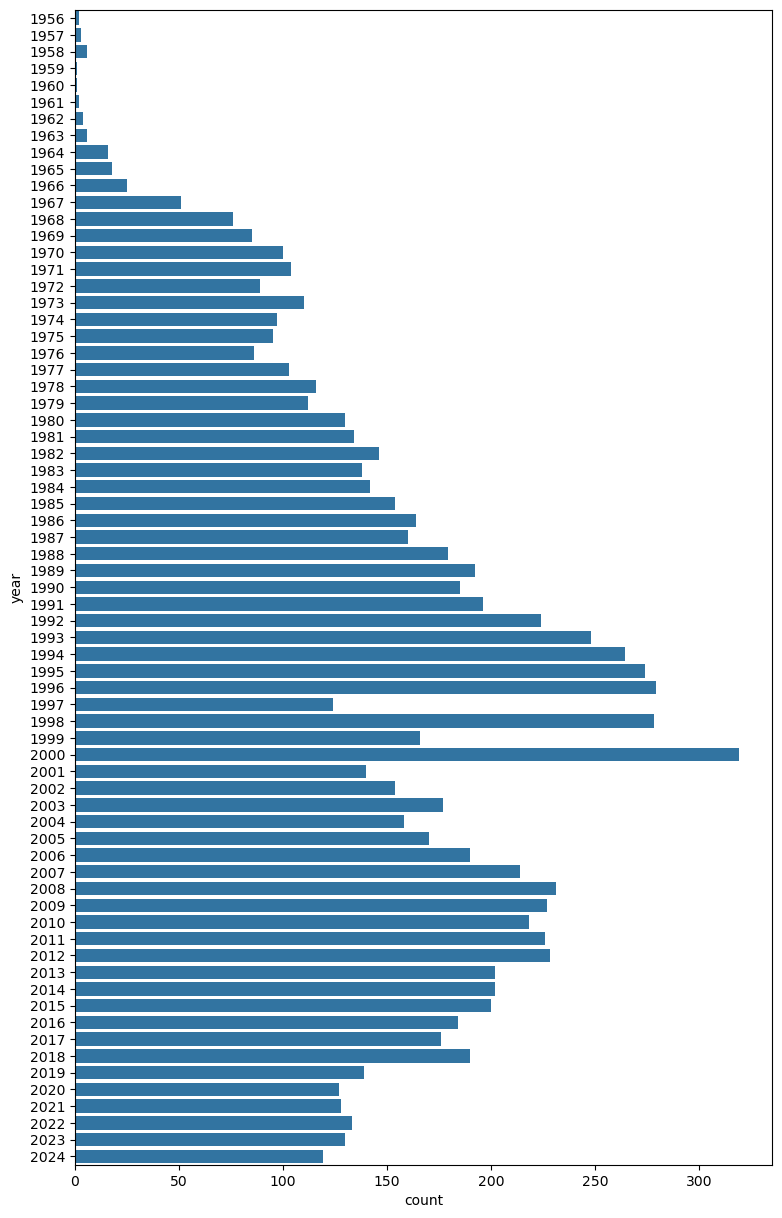

In [127]:
plt.figure(figsize=(9,15))
sns.countplot(data=df_masters_blended, y='year')

<Axes: xlabel='count', ylabel='year'>

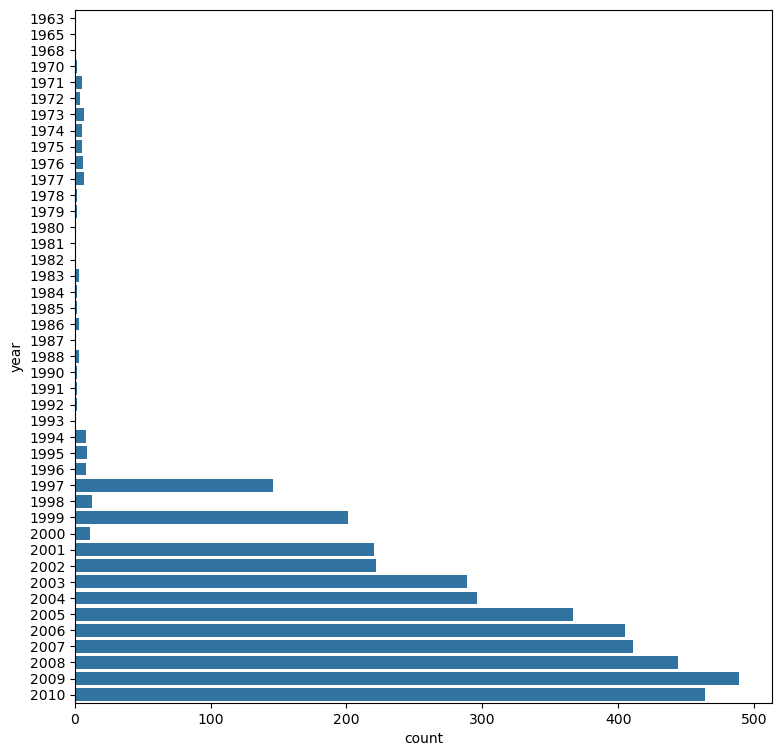

In [125]:
plt.figure(figsize=(9,9))
sns.countplot(data=df_us_new_masters_2010, y='year')

In [138]:
df_masters = pd.concat([df_masters_blended, df_us_new_masters_2010])
df_masters.shape

(13742, 13)

In [139]:
df_masters = df_masters[df_masters['year']<2011].query("year > 1959")
df_masters.shape

(11346, 13)

<Axes: xlabel='count', ylabel='year'>

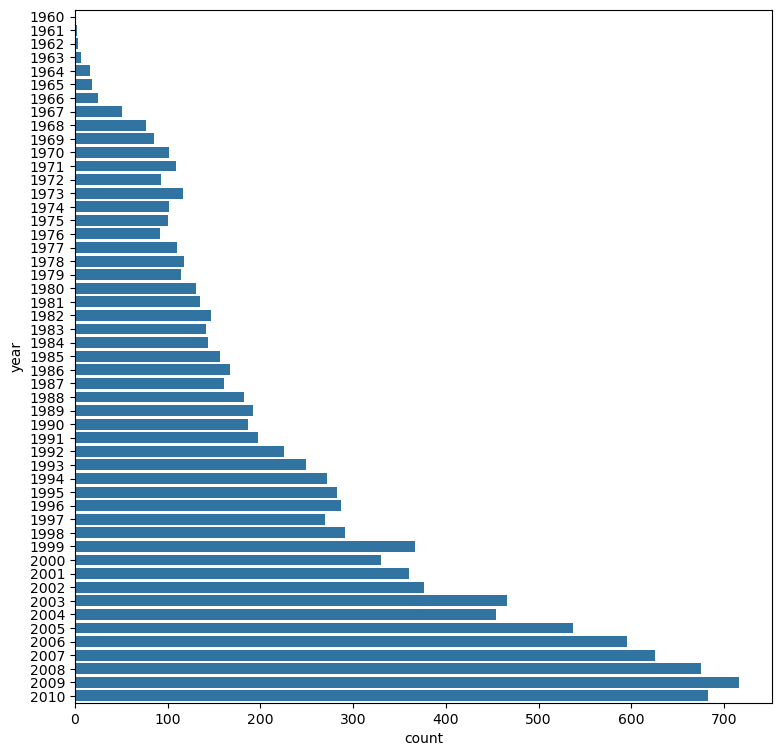

In [141]:
plt.figure(figsize=(9,9))
sns.countplot(data=df_masters, y='year')

In [143]:
df_masters.to_csv('Datasets/df_masters.csv', index=False)

# **``styles``**

In [2]:
df = pd.read_csv('Datasets/df_masters.csv')               # albums from the UK and US (until 2010) with >= 20 votes 
df.shape

(11346, 13)

In [3]:
df.sample(3)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2142,393492,139520,2030285,UK,Cressida,Asylum,1971,0.00,8,"['LP', 'Album']",['Rock'],['Prog Rock'],"English Prog-Rock Band, formed in 1968 and dis..."
6192,110253,17245,1284784,US,The Allman Brothers Band,Eat a Peach,1972,70.68,10,"['LP', 'Album']","['Rock', 'Blues']","['Blues Rock', 'Southern Rock']",American rock / blues band once based in Macon...
6676,91860,8140,152851,US,Lard,The Last Temptation of Reid,1990,57.10,9,['Album'],"['Electronic', 'Rock']","['Industrial', 'Punk']",Industrial-hardcore collaboration between Jell...


In [10]:
df.styles.value_counts().head(10)

styles
['Alternative Rock']    475
['Indie Rock']          427
['Death Metal']         289
['Punk']                268
['Hardcore']            263
['Heavy Metal']         258
['Pop Rock']            249
['Hard Rock']           247
['Prog Rock']           180
['Hardcore', 'Punk']    153
Name: count, dtype: int64

## **Looking for the missing ``styles``**

My approach is to get the styles from other releases of that album, because from the master release it said it had no styles.

In [6]:
percentage_styles_missing = round((df['styles']=='[]').sum() / df.shape[0] * 100, 2)

print(f"albums missing style: {(df['styles']=='[]').sum()} ")
print(f'% missing styles: {percentage_styles_missing}%')

albums missing style: 37 
% missing styles: 0.33%


### Testing

In [ ]:
# I am going to get the releases from the master_id, so I cannot search the albums where master_id = 0, I will search these ones manually
df[df['styles']=='[]'].query('master_id == 0')['title'].count()

0

In [16]:
# luckily all of them have a master_id
df_styles_missing = df[df['styles']=='[]'].query('master_id != 0') 
df_styles_missing.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
7506,732375,350751,2999284,US,Umphrey's McGee,Safety In Numbers,2006,68.05,13,"['LP', 'Album', 'Limited Edition']",['Rock'],[],Jam rock / progressive rock band from South Be...
7655,2588339,411298,3356736,US,Graves of Valor,Salarian Gate,2009,61.38,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Formed in December 2005 in Florence, South Car..."
7674,40916,292437,2590698,US,Kid Rock,Born Free,2010,60.67,13,['Album'],['Rock'],[],A self-proclaimed redneck from the midwestern ...
7796,266422,301354,8057533,UK & Europe,The Moody Blues,Strange Times,1999,57.55,14,['Album'],['Rock'],[],"British rock group from Birmingham, England, f..."
7833,924002,455567,3792209,US,Mat Kearney,Nothing Left to Lose,2006,56.97,13,['Album'],['Rock'],[],"American singer-songwriter born in Eugene, Ore..."


Let's test with one of these albums, The main release has ``stlyes = []``, but what about the other releases?

In [313]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100   # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'genre': 'Rock'
    , 'master_id': 3470389
}
response = requests.get(url, headers=headers, params=params)
data = response.json()
print(f"There are {len(data['results'])} releases of this album")

There are 8 releases of this album


Not all of them have ``styles = []``, some have some style at least.

In [314]:
# create an empty list
styles_list = []

# iterate over all the releases
for i in range(len(data['results'])):
    style = data['results'][i]['style'] # get the style(s)
    if style: 
        styles_list.append(style)
        most_common_style = pd.Series(styles_list).value_counts().idxmax()
    else:
        styles_list.append(np.nan)

# print the value_counts() of the styles
pd.Series(styles_list).value_counts()

[Prog Rock]    7
Name: count, dtype: int64

In [310]:
try:
    most_common_style = pd.Series(styles_list).value_counts().idxmax()
    print(most_common_style)
except:
    print('No styles found')

['Alternative Rock']


### **Applying the function to get ``df_styles_found``**

In [ ]:
def get_styles(df):

    most_common_styles = []
    count = 0

    for master_id in df_styles_missing['master_id'].values:
        time.sleep(1)
        count+=1
        url = "https://api.discogs.com/database/search"
        headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

        # Define parameters for artist search
        params = {
            "per_page": 100   # Number of results per page (max 100)
            , 'type': 'release'
            , 'format': 'album'
            , 'genre': 'Rock'
            , 'master_id': master_id
        }

        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # create an empty list
        styles_list = []

        # iterate over all the releases
        for i in range(len(data['results'])):
            style = data['results'][i]['style'] # get the style(s)
            if style: 
                styles_list.append(style)
            else:
                styles_list.append(np.nan)

        try:
            most_common_style = pd.Series(styles_list).value_counts().idxmax()
            print(f"{count} - {most_common_style}")
        except:
            print(f'{count} - No styles found')
            most_common_style = np.nan

        most_common_styles.append(most_common_style)
    
    df_styles_found = pd.DataFrame({'master_id': df_styles_missing['master_id'].values,
                                    'styles': most_common_styles})
    return df_styles_found

In [324]:
df_styles_missing = df[df['styles']=='[]'].query('master_id != 0')
df_styles_missing

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
51,9657940,3540907,31203097,UK,Remi Wolf,Big Ideas,2024,43.18,13,"['Album', 'Stereo']","['Rock', 'Pop']",[],"American singer-songwriter, born February 2, 1..."
58,2727700,3527840,31083689,Worldwide,Imagine Dragons,LOOM,2024,31.45,10,"['AAC', 'Album']","['Rock', 'Pop']",[],"Pop rock band from Nevada, US.\r\nFormed 2008\..."
80,7236492,3471745,30507286,US,Mk.Gee,Two Star and the Dream Police,2024,33.22,12,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']",[],NaN
81,4423684,3470389,29692129,Worldwide,Vennart,Forgiveness and The Grain,2024,42.03,8,"['MP3', 'Album']",['Rock'],[],Collaborative project led by English electric ...
82,48263,3469978,30524809,US,Microwave,Let's Start Degeneracy,2024,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Rock band from Atlanta, Georgia consisting of ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,20991,30254,1123069,UK,The Rolling Stones,Black and Blue,1976,41.15,8,"['LP', 'Album']",['Rock'],[],English rock band formed in London in May 1962...
9447,59792,27951,2769931,US,Bob Dylan,Knocked Out Loaded,1986,34.85,8,"['LP', 'Album']","['Rock', 'Pop']",[],"Born: May 24, 1941, Duluth, Minnesota, USA; si..."
9955,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],[],American alternative rock band founded in 1989...
10326,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[],"Born December 7th. 1949, in Pomona, California..."


In [327]:
df_styles_found = get_styles(df_styles_missing)

No styles found
['Alternative Rock']
['Dream Pop', 'Indie Pop', 'Lo-Fi']
['Prog Rock']
['Pop Punk']
['Alternative Rock', 'Art Rock', 'Dream Pop']
['Grunge']
No styles found
['Alternative Rock', 'Indie Rock', 'Grunge', 'Alt-Pop']
['Post-Hardcore', 'Pop Punk']
['Alternative Rock', 'Post-Punk']
['Pop Rock']
['Prog Rock', 'Synth-pop', 'Alternative Rock', 'Pop Rock']
['Death Metal', 'Grindcore']
No styles found
['Alternative Rock', 'Indie Rock', 'Pop Rock']
['Alternative Rock']
['Indie Rock']
['Hard Rock']
['Alternative Rock']
['Alternative Rock']
['Pop Rock', 'Folk Rock']
['Alternative Rock']
['Goth Rock', 'Post-Punk', 'Alternative Rock']
['Indie Rock']
['Alternative Rock', 'Indie Rock']
['Rock & Roll', 'Punk']
No styles found
['Folk Rock', 'Neofolk']
['Indie Rock', 'Country', 'Folk Rock']
['Ska']
['Alternative Rock']
['Alternative Rock']
No styles found
['Indie Pop', 'Dance-pop', 'Nu Metal']
['Alternative Rock']
['Indie Rock']
['Symphonic Rock']
['Pop Rock']
['Alternative Rock', 'Indie Ro

In [328]:
df_styles_found

,master_id,styles
0,3540907,NaN
1,3527840,[Alternative Rock]
2,3471745,"[Dream Pop, Indie Pop, Lo-Fi]"
3,3470389,[Prog Rock]
4,3469978,[Pop Punk]
...,...,...
210,30254,[Classic Rock]
211,27951,[Folk Rock]
212,20565,"[Post Rock, Indie Rock]"
213,14043,[Blues Rock]


### **Replacing null values in ``df_styles_found``**

In [503]:
# create a df with where style is a null value
nulls = df_styles_found[df_styles_found['styles'].isna()]
nulls.shape

(15, 2)

In [507]:
# so I can print the np.where and I save time
for master_id in nulls['master_id'].values:
    print(f"df_styles_found['styles'] = np.where(df_styles_found['master_id']=={master_id}, "['Rock']", df_styles_found['styles'])")

df_styles_found['styles'] = np.where(df_styles_found['master_id']==3064604, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2459566, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2007316, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1760531, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1470386, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1441419, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1328043, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1065693, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==994504, '[Indie]', df

In [584]:
# looking on the internet for the style of these albums
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1433078, "['Indie Rock']", df_styles_found['styles'])
df_styles_found["styles"] = np.where(df_styles_found["master_id"]==3540907, "['Pop Rock']", df_styles_found["styles"])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==3064604, "['Alternative Rock', 'Space Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2459566, "['Pop Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2007316, "['Alternative Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1760531, "['Post-Punk']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1470386, np.nan, df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1441419, "['Indie Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1328043, "['Alternative Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1065693, "['Progressive Metal']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==994504, "['Post-Punk']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==910041, "['Nu Metal']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==886623, "['Pop Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==870411, "['Alternative Rock', 'Hard Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==853786, "['Stoner Rock', 'Post-Hardcore']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==797067, np.nan, df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==687999, "['Alternative Rock', 'Pop Punk']", df_styles_found['styles'])

print(f"Rows before dropping: {df_styles_found.shape[0]}")
df_styles_found.dropna(subset='styles', inplace=True)
print(f"Rows after dropping: {df_styles_found.shape[0]}")

Rows before dropping: 213
Rows after dropping: 213


In [524]:
# look for the albums by the master_id
df[df['master_id']==687999]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2144,3348883,687999,4683206,UK,Mallory Knox,Signals,2013,41.18,11,['Album'],['Rock'],[],Mallory Knox is a four-piece alternative rock ...


In [585]:
# save it in a .csv just in case
df_styles_found.to_csv('Datasets/df_styles_found.csv', index=False)

In [439]:
# in case I have to import it again
df_styles_found = pd.read_csv('Datasets/df_styles_found.csv')

### **Changing the type of ``styles``**

In [440]:
df.shape

(11429, 13)

In [441]:
df.styles.nunique()

3582

In [442]:
df.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."


**Separate ``df`` in 2 dataframes, one with the correct styles and the other df where ``styles = []``**

In [443]:
df_styles_empty = df[df['styles']=='[]']
df_styles_empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
51,9657940,3540907,31203097,UK,Remi Wolf,Big Ideas,2024,43.18,13,"['Album', 'Stereo']","['Rock', 'Pop']",[],"American singer-songwriter, born February 2, 1..."
58,2727700,3527840,31083689,Worldwide,Imagine Dragons,LOOM,2024,31.45,10,"['AAC', 'Album']","['Rock', 'Pop']",[],"Pop rock band from Nevada, US.\r\nFormed 2008\..."
80,7236492,3471745,30507286,US,Mk.Gee,Two Star and the Dream Police,2024,33.22,12,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']",[],NaN
81,4423684,3470389,29692129,Worldwide,Vennart,Forgiveness and The Grain,2024,42.03,8,"['MP3', 'Album']",['Rock'],[],Collaborative project led by English electric ...
82,48263,3469978,30524809,US,Microwave,Let's Start Degeneracy,2024,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Rock band from Atlanta, Georgia consisting of ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[],"Born December 7th. 1949, in Pomona, California..."
10498,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",[],"American singer-songwriter, multi-instrumental..."
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.00,10,"['LP', 'Album']",['Rock'],[],"Rock group that was started in Seattle, in 196..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.00,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."


In [444]:
df_styles_good = df[df['styles']!='[]']
df_styles_good

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],"['Blackgaze', 'Post-Hardcore', 'Post-Metal']","Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Emo', 'Math Rock', 'Pop Punk']","Trio from Benson, Minnesota. The band takes in..."
4,2607662,3659271,32308731,US,Father John Misty,Mahashmashana,2024,0.00,8,"['LP', 'Album', 'Club Edition', 'Limited Editi...",['Rock'],"['Alternative Rock', 'Folk Rock']",American singer/songwriter originally from Roc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11424,29890,0,11013751,UK,The Clash,The Clash,1977,34.85,14,"['LP', 'Album']",['Rock'],['Punk'],Influential British punk rock group from west ...
11425,292633,0,2493108,US,Converge,Halo In A Haystack,1994,0.00,10,"['LP', 'Album']",['Rock'],['Metalcore'],Converge is a hardcore punk and metal band tha...
11426,109320,0,11590028,US,Split Enz,Mental Notes,1976,41.88,10,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Split Enz were a rock band from New Zealand fo...
11427,85929,0,9727763,UK,Kate Bush,Lionheart,1978,36.57,10,"['LP', 'Album', 'Promo']","['Rock', 'Pop']","['Art Rock', 'Pop Rock', 'Ballad']","Highly distinctive singer/songwriter, born Jul..."


It looks like they are lists, but actually...

In [445]:
type(df_styles_good.styles[0])

str

In [446]:
# convert these strings to lists
df_styles_good.styles = df_styles_good.styles.apply(ast.literal_eval)
type(df_styles_good.styles[0])

list

In [447]:
df_styles_good.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],[Post-Hardcore],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"[Alternative Rock, Pop Punk]","Band from Dover Plains, New York, formerly kno..."


In [448]:
df_styles_good['styles'].value_counts().head()

styles
[Indie Rock]          550
[Alternative Rock]    489
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            266
Name: count, dtype: int64

### **Merge with ``df_styles_found``**

In [544]:
# to copy them for later sorting the columns in the merged df
df_styles_empty.columns

Index(['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile'],
      dtype='object')

In [587]:
df_styles_merged = pd.merge(df_styles_empty, df_styles_found, on=['master_id'])
df_styles_merged.drop(columns='styles_x', inplace=True)
df_styles_merged.rename(columns={'styles_y': 'styles'}, inplace=True)

# sort the columns
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country', 'artist', 'title', 'year',
                   'album_length', 'tracks', 'release_type', 'genres', 'styles', 'artist_profile']
df_styles_merged = df_styles_merged[list_of_columns]
df_styles_merged.shape

(213, 13)

In [546]:
# check everything is fine
df_styles_merged.sample(3)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
109,256629,897370,7584880,US,Coheed and Cambria,The Color Before The Sun,2015,47.22,10,"['Album', 'Stereo']",['Rock'],['Alternative Rock'],A progressive rock band based out of Nyack and...
160,286546,292999,2324957,Germany,Peter Criss,Let Me Rock You,1982,0.00,10,"['LP', 'Album']",['Rock'],['Rock & Roll'],"George Peter John Criscuola (born December 20,..."
38,11073,1601626,14089728,US,Iggy Pop,Free,2019,33.38,10,['Album'],"['Jazz', 'Rock']",['Pop Rock'],"American singer, songwriter, musician and acto..."


### **Albums where ``master_id = 0``**

In [452]:
# create a subset with the albums where master_id = 0 and style is empty. These albums I cannot find the styles for other releases because the master_id = 0
df_styles_empty_id0 = df_styles_empty[df_styles_empty['master_id']==0]
df_styles_empty_id0

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.0,10,"['LP', 'Album']",['Rock'],[],"Rock group that was started in Seattle, in 196..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.0,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."
11365,4266257,0,6684240,US,Savage Garden,Savage Garden,1989,0.0,7,"['Single Sided', 'Album']",['Rock'],[],NaN


In [453]:
# looking on the internet for the style of these albums
df_styles_empty_id0.loc[11330, 'styles'] = '[Hard Rock, Folk Rock, Pop Rock]'

In [416]:
df[df['artist']=='Nirvana']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
8373,125246,42473,367273,US,Nirvana,From the Muddy Banks of the Wishkah,1996,53.92,17,['Album'],['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
10334,125246,13859,375979,US,Nirvana,In Utero,1993,41.00,12,['Album'],['Rock'],"['Grunge', 'Alternative Rock']","Rock band from Aberdeen, Washington, USA, form..."
10339,125246,13814,367084,US,Nirvana,Nevermind,1991,42.53,12,"['Album', 'Mispress']",['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
10343,125246,13773,2795554,US,Nirvana,Bleach,1989,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.00,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."


In [417]:
df.loc[11331, 'artist_profile']

'Nirvana is hard rock/AOR band, from Los Angeles, California, USA. Not to be confused with the grunge band [a=Nirvana] from Washington.\r\n\r\nThis band features Bert Klugkist, Mark Wiggins, Erik Wiggins and Rick Obradors.'

In [454]:
# it's not the Nirvana we all know, it's a different band and I cannot even find any information about this band outside Discogs, so I drop it
df_styles_empty_id0.drop(11331, axis=0, inplace=True)

In [455]:
df[df['artist']=='Savage Garden']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11365,4266257,0,6684240,US,Savage Garden,Savage Garden,1989,0.0,7,"['Single Sided', 'Album']",['Rock'],[],NaN


In [456]:
# I can only find a band named like this, but the album is from 1997 (strange). Anyway, they are Australian, so I drop it
df_styles_empty_id0.drop(11365, axis=0, inplace=True)

In [457]:
df_styles_empty_id0

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.0,10,"['LP', 'Album']",['Rock'],"[Hard Rock, Folk Rock, Pop Rock]","Rock group that was started in Seattle, in 196..."


### **Concat ``df_styles_good`` with ``df_styles_merged`` and ``df_styles_empty_id0``**

In [559]:
type(df_styles_merged.styles[0]) # each element should be a list

str

In [589]:
# convert these strings to lists
df_styles_merged.styles = df_styles_merged.styles.apply(ast.literal_eval)
type(df_styles_merged.styles[0])

list

In [590]:
df_masters_blended = pd.concat([df_styles_good, df_styles_merged, df_styles_empty_id0])
df_masters_blended.shape

(11425, 13)

In [595]:
df_styles_good['styles'].value_counts().head()

styles
[Indie Rock]          550
[Alternative Rock]    489
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            266
Name: count, dtype: int64

In [596]:
df_masters_blended['styles'].value_counts().head()

styles
[Indie Rock]          576
[Alternative Rock]    525
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            279
Name: count, dtype: int64

By printing the ``value_counts()`` of each dataframe I make sure the albums that had ``styles = []`` are now included, we can see the count has increased

In [597]:
df_masters_blended

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],[Post-Hardcore],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"[Alternative Rock, Pop Punk]","Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],"[Blackgaze, Post-Hardcore, Post-Metal]","Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"[Emo, Math Rock, Pop Punk]","Trio from Benson, Minnesota. The band takes in..."
4,2607662,3659271,32308731,US,Father John Misty,Mahashmashana,2024,0.00,8,"['LP', 'Album', 'Club Edition', 'Limited Editi...",['Rock'],"[Alternative Rock, Folk Rock]",American singer/songwriter originally from Roc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,59792,27951,2769931,US,Bob Dylan,Knocked Out Loaded,1986,34.85,8,"['LP', 'Album']","['Rock', 'Pop']",[Folk Rock],"Born: May 24, 1941, Duluth, Minnesota, USA; si..."
210,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],"[Post Rock, Indie Rock]",American alternative rock band founded in 1989...
211,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[Blues Rock],"Born December 7th. 1949, in Pomona, California..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']","[Pop Rock, Classic Rock]","American singer-songwriter, multi-instrumental..."


In [601]:
df_masters_blended.to_csv('Datasets/df_masters_blended.csv', index=False)

In [602]:
df_masters_blended.explode('styles')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],Post-Hardcore,"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Alternative Rock,"Band from Dover Plains, New York, formerly kno..."
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Pop Punk,"Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Blackgaze,"Post-black metal band from Sheffield, UK\r\n\r..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Post-Hardcore,"Post-black metal band from Sheffield, UK\r\n\r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],Indie Rock,American alternative rock band founded in 1989...
211,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",Blues Rock,"Born December 7th. 1949, in Pomona, California..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",Pop Rock,"American singer-songwriter, multi-instrumental..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",Classic Rock,"American singer-songwriter, multi-instrumental..."


## **explode ``styles`` in one line of code**

In [603]:
# import the dataframe
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')
df_masters_blended.shape

(11425, 13)

In [604]:
type(df_masters_blended['styles'][0])

str

In [43]:
df_masters_blended['styles'] = df_masters_blended["styles"].apply(ast.literal_eval)
df_styles = df_masters_blended.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()

for style in top_80_styles:
    print(style)

Alternative Rock
Punk
Pop Rock
Indie Rock
Hard Rock
Folk Rock
Psychedelic Rock
Heavy Metal
Country Rock
Blues Rock
Experimental
Hardcore
Rock & Roll
Garage Rock
Soft Rock
Prog Rock
AOR
Power Pop
Acoustic
New Wave
Thrash
Folk
Classic Rock
Country
Avantgarde
Lo-Fi
Art Rock
Southern Rock
Gospel
Ska
Death Metal
Synth-pop
Jazz-Rock
Rockabilly
Surf
Ballad
Industrial
Vocal
Soul
Funk
Grunge
Noise
Rhythm & Blues
Religious
Goth Rock
Pop Punk
Lounge
Fusion
Glam
Post-Punk
Emo
Nu Metal
Ambient
Funk Metal
Space Rock
Post Rock
Arena Rock
Disco
Ethereal
Soundtrack
Progressive Metal
Speed Metal
Stoner Rock
Indie Pop
Easy Listening
Power Metal
Doom Metal
Free Improvisation
Parody
Doo Wop
Beat
Shoegaze
Abstract
Jazz-Funk
New Age
Acid Rock
Symphonic Rock
Electro
Bluegrass
Math Rock


## ``explode`` in several lines of code

In [44]:
df['styles'].value_counts().head()

styles
[Indie Rock]          558
[Alternative Rock]    497
[Death Metal]         358
[Heavy Metal]         300
[Pop Rock]            274
Name: count, dtype: int64

In [45]:
df.shape

(11920, 13)

In [46]:
df_styles = df.explode('styles')
df_styles.shape

(23859, 13)

In [47]:
df_styles['styles'].nunique()   # before we had 3851

276

In [48]:
df_styles['styles'].value_counts().head(80)

styles
Alternative Rock         2075
Indie Rock               1993
Pop Rock                 1314
Hard Rock                1035
Punk                      987
                         ... 
Krautrock                  48
Gothic Metal               48
Industrial Metal           47
AOR                        47
Technical Death Metal      47
Name: count, Length: 80, dtype: int64

## Get the nº of albums for each ``style`` for one specific year

In [ ]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

styles_to_get = [ 
    "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
    "Emo", "Post Rock", "Shoegaze", "Indie Pop", "Hard Rock", 
    "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
    "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
    "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
    "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
    "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
    "Soft Rock", "Country Rock", "Southern Rock"
]

styles_list = []
count_list = []

for style in styles_to_get:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': 1997
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")
    time.sleep(2)

    styles_list.append(style)
    count_list.append(items_number)

# save the data in a df
data = pd.DataFrame({'style': styles_list, 'albums': count_list})

Alternative Rock: 1853
Indie Rock: 1292
Pop Rock: 1038
New Wave: 80
Emo: 195
Post Rock: 183
Shoegaze: 53
Indie Pop: 179
Hard Rock: 792
Heavy Metal: 444
Death Metal: 162
Thrash: 197
Black Metal: 74
Doom Metal: 37
Metalcore: 37
Progressive Metal: 41
Stoner Rock: 63
Speed Metal: 32
Nu Metal: 134
Prog Rock: 291
Psychedelic Rock: 360
Art Rock: 172
Classic Rock: 219
Space Rock: 56
Symphonic Rock: 39
Punk: 1493
Hardcore: 759
Post-Punk: 65
Post-Hardcore: 38
Pop Punk: 176
Grunge: 163
Garage Rock: 308
Folk Rock: 525
Blues Rock: 406
Rock & Roll: 257
Soft Rock: 215
Country Rock: 445
Southern Rock: 120


In [78]:
data.head()

,style,albums
0,Alternative Rock,1853
1,Indie Rock,1292
2,Pop Rock,1038
3,New Wave,80
4,Emo,195


In [79]:
data.albums.sum()

12993

In [80]:
((data.albums.sum())*1.5)/3600

5.41375

## Top 80 styles for one year in the US

In [ ]:
# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

# explode 'styles'
df_us_masters_scraped['styles'] = df_us_masters_scraped["styles"].apply(ast.literal_eval)
df_styles = df_us_masters_scraped.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()

In [ ]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

# explode 'styles'
df_us_masters_scraped['styles'] = df_us_masters_scraped["styles"].apply(ast.literal_eval)
df_styles = df_us_masters_scraped.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()
styles_list = []
count_list = []

for style in top_80_styles:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': 2004
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")
    time.sleep(2)

    styles_list.append(style)
    count_list.append(items_number)

# save the data in a df and export it
data = pd.DataFrame({'style': styles_list, 'albums': count_list})

OSError: [Errno 22] Invalid argument: 'Datasets/df_us_masters.csv'

In [ ]:
data = data.sort_values('albums', ascending=False)
data.reset_index(drop=True, inplace=True)
data

,style,albums
0,Punk,1666
1,Alternative Rock,1495
2,Indie Rock,1438
3,Pop Rock,1107
4,Hardcore,849
...,...,...
75,Doo Wop,18
76,Jazz-Funk,14
77,New Age,11
78,Disco,9


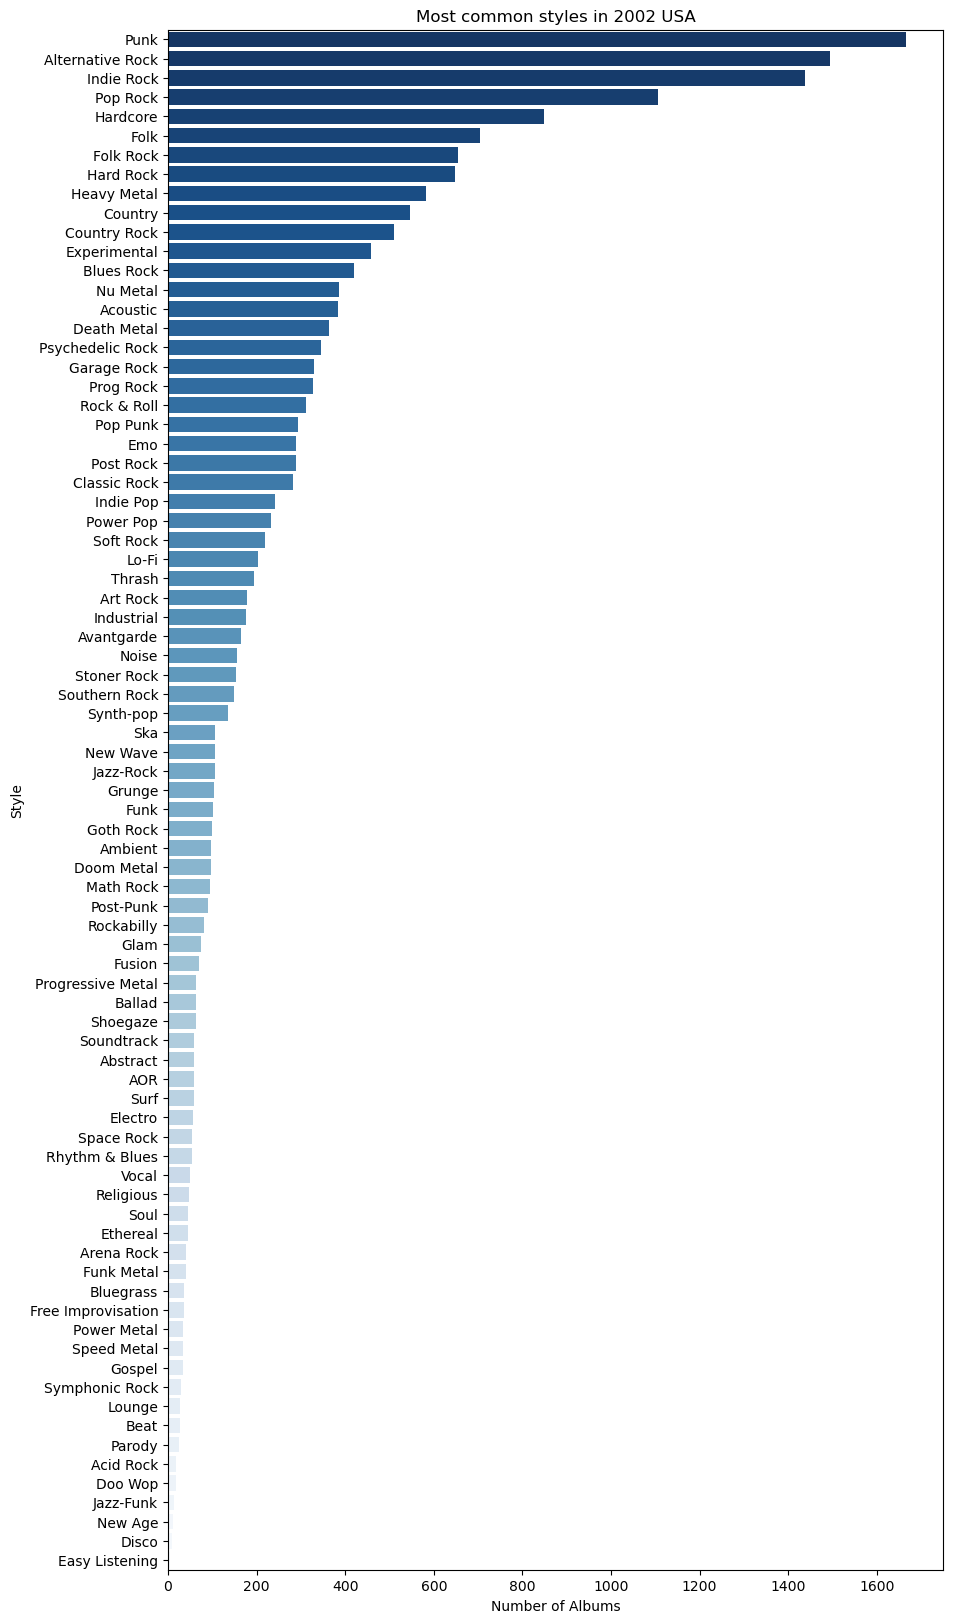

In [ ]:
plt.figure(figsize=(10, 20))
sns.barplot(data=data, y="style", x="albums", palette="Blues_r")
plt.xlabel("Number of Albums")
plt.ylabel("Style")
plt.title("Most common styles in 2002 USA")
plt.show()

## Top 50 styles for all the albums, UK and US

In [ ]:
df = pd.read_csv('Datasets/df_masters_blended.csv')
df['styles'] = df["styles"].apply(ast.literal_eval)
df_styles = df.explode('styles')
top_50_styles = df_styles['styles'].value_counts().head(50).index.to_list()

In [ ]:
df_styles['styles'].value_counts().head(50)

styles
Alternative Rock     2075
Indie Rock           1993
Pop Rock             1314
Hard Rock            1035
Punk                  987
Heavy Metal           976
Prog Rock             824
Hardcore              664
Death Metal           654
Psychedelic Rock      634
Folk Rock             632
Experimental          581
Thrash                482
Art Rock              415
Blues Rock            405
Black Metal           389
New Wave              329
Synth-pop             273
Doom Metal            267
Classic Rock          263
Emo                   255
Acoustic              249
Post-Punk             241
Post Rock             240
Avantgarde            235
Rock & Roll           220
Metalcore             204
Progressive Metal     204
Soft Rock             195
Post-Hardcore         185
Shoegaze              183
Industrial            180
Country Rock          177
Indie Pop             160
Glam                  159
Pop Punk              157
Stoner Rock           146
Speed Metal           146
Garag

In [ ]:
df_styles[df_styles['styles']=='Art Rock'].year.mean()

1993.6722891566264

In [ ]:
df_styles[df_styles['styles']=='Punk']['artist'].count()

987

### **Styles analysis** for number of albums and average year

In [ ]:
# get the average year of each style
top_50_styles = df_styles['styles'].value_counts().head(100)
top_styles = df_styles['styles'].value_counts().head(100).index.to_list()
albums = top_50_styles.values
years = []
styles = []
albums_count = []

for style in top_styles:
    avg_year = int(df_styles[df_styles['styles']==style].year.mean())
    albums = df_styles[df_styles['styles']==style]['artist'].count()
    years.append(avg_year)
    styles.append(style)
    albums_count.append(albums)

df_styles_years = pd.DataFrame({'style': styles, 'albums': albums_count, 'avg_year': years})

In [ ]:
df_styles_years.sort_values('albums', ascending=False).tail(50)

,style,albums,avg_year
50,Fusion,93,1982
51,Grindcore,92,2002
52,Nu Metal,90,2005
53,Ballad,87,1995
54,Electro,86,2007
55,Sludge Metal,82,2009
56,Downtempo,80,2004
57,Goth Rock,78,1994
58,Southern Rock,77,1989
59,Ethereal,74,1999


**Styles Grouping (1960s–2020s Focus)**

**1. Alternative & Indie Rock (80s–2020s)**

✅ Alternative Rock, Indie Rock, Pop Rock, New Wave, Emo, Post Rock, Shoegaze, Indie Pop 

**2. Hard Rock & Metal (70s–2020s)**

✅ Hard Rock, Heavy Metal, Death Metal, Thrash, Black Metal, Doom Metal, Metalcore, Progressive Metal, Stoner Rock, Speed Metal, Nu Metal

**3. Classic & Psychedelic Rock (60s–80s, some revival)**

✅ Prog Rock, Psychedelic Rock, Art Rock, Classic Rock, Space Rock, Symphonic Rock

**4. Punk & Hardcore (70s–2020s)**

✅ Punk, Hardcore, Post-Punk, Post-Hardcore, Pop Punk, Grunge, Garage Rock

**5. Roots Rock & Blues (50s–present)**

✅ Folk Rock, Blues Rock, Rock & Roll, Soft Rock, Country Rock, Southern Rock

**What to Drop? (Even for the 60s–2020s range)**

These styles aren’t really rock in any decade:

❌ Easy Listening, New Age, Free Improvisation, Abstract, Rhythm & Blues, Doo Wop, Soul, Bluegrass, Vocal, Ballad, Jazz-Funk, Disco, Funk

Why? They either:
- Weren’t major parts of the rock genre (Disco, Funk, Soul, R&B, etc.).
- Were independent movements that didn't blend much with rock (New Age, Easy Listening, Jazz-Funk).

In [ ]:
df_styles[df_styles['styles']=='Arena Rock']['artist'].value_counts()

artist
Def Leppard           8
Scorpions             4
Heart                 4
Asia                  4
Journey               4
Dokken                3
Kansas                3
Meat Loaf             3
Uriah Heep            3
Boston                3
Phish                 3
AC/DC                 2
Ratt                  2
Mr. Big               2
Foreigner             2
Magnum                2
Firehouse             2
Europe                2
Queen                 2
REO Speedwagon        2
Triumph               2
Kix                   2
Aerosmith             2
KISS                  1
Frank Zappa           1
The Darkness          1
Roger Waters          1
Deep Purple           1
Survivor              1
Pink Floyd            1
Neil Young            1
Guns N' Roses         1
Joe Satriani          1
Bad Company           1
Yes                   1
Slade                 1
Mr. Mister            1
Praxis                1
Loverboy              1
Simple Minds          1
U2                    1
Andrew W.

In [ ]:
df_styles[df_styles['styles']=='Garage Rock']['artist'].count()

145

In [ ]:
df_styles[df_styles['styles']=='Rockabilly']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
4408,272426,252597,4057583,US,Buddy Holly,Buddy Holly,1958,0.00,12,"['LP', 'Album']","['Rock', 'Pop']",Rockabilly,"American guitarist, singer and songwriter, bes..."
4886,49624,210587,13285348,South Korea,Jeff Beck,Crazy Legs,1993,40.52,18,['Album'],['Rock'],Rockabilly,"British guitarist.\r\nBorn: June 24, 1944, in ..."
5184,272426,183346,1371149,US,Buddy Holly,That'll be the Day,1958,25.15,11,"['LP', 'Album', 'Mono']",['Rock'],Rockabilly,"American guitarist, singer and songwriter, bes..."
6366,27518,107325,4814324,US,Elvis Presley,Elvis Presley,1956,0.00,12,"['LP', 'Album', 'Mono']","['Rock', 'Pop']",Rockabilly,American singer.\r\nBorn: 8 January 1935 in Ea...
7060,253328,83700,900466,Australia,The Living End,State Of Emergency,2006,51.73,14,['Album'],['Rock'],Rockabilly,"Punk rock band from Melbourne, Australia.\r\nF..."
7061,253328,83698,373583,Australia,The Living End,The Living End,1998,47.00,14,['Album'],['Rock'],Rockabilly,"Punk rock band from Melbourne, Australia.\r\nF..."
7320,135946,73462,5780483,US,Johnny Cash,I Walk The Line,1964,32.32,12,"['LP', 'Album', 'Mono']","['Rock', 'Folk, World, & Country']",Rockabilly,"Johnny Cash was an American singer-songwriter,..."
7321,135946,73420,7684728,US,Johnny Cash,The Fabulous Johnny Cash,1958,0.00,12,"['LP', 'Album', 'Mono']","['Rock', 'Folk, World, & Country']",Rockabilly,"Johnny Cash was an American singer-songwriter,..."
7470,180921,69584,1690027,UK,Stray Cats,Stray Cats,1981,0.00,12,"['LP', 'Album']",['Rock'],Rockabilly,The Stray Cats are a rockabilly band first for...
7472,180921,69576,1346627,UK,Stray Cats,Gonna Ball,1981,32.77,11,"['LP', 'Album']",['Rock'],Rockabilly,The Stray Cats are a rockabilly band first for...


# **``album_length``**

In [2]:
df_masters = pd.read_csv('Datasets/df_masters.csv')            
df = df_masters
df.shape

(11346, 13)

In [96]:
percentage_album_length_missing = round((df['album_length']==0).sum() / df.shape[0] * 100, 2)

print(f"albums missing album_length: {(df['album_length']==0).sum()} ")
print(f'% missing album_length: {percentage_album_length_missing}%')

albums missing album_length: 2201 
% missing album_length: 19.4%


In [97]:
df_length_0 = df[df['album_length']==0].sort_values(['artist', 'year', 'title'])
df_length_0.shape

(2201, 13)

In [98]:
df_length_0.to_csv('Datasets/df_length_0.csv', index=False)

In [ ]:
df_lengths_found_spotipy = pd.read_csv('Datasets/df_lengths_found_spotipy.csv')
df_lengths_found_spotipy.shape

(2558, 5)

## **Examining**

In [10]:
df_length_0.iloc[8:15]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
8451,253271,17226,3944276,US,7 Seconds,New Wind,1986,0.0,13,"['LP', 'Album']",['Rock'],"['Punk', 'Hardcore']","Punk band originally from Reno, Nevada, formed..."
7647,11203,30962,1453338,UK,A Certain Ratio,The Graveyard and The Ballroom,1980,0.0,16,['Album'],"['Electronic', 'Rock']","['Leftfield', 'New Wave']",British post punk & indie funk band formed in ...
1719,652118,695019,6340275,US,A Global Threat,Until We Die,2000,0.0,14,['Album'],['Rock'],"['Hardcore', 'Punk']",A Global Threat was an American street punk ba...
1784,1922448,666120,5690473,US,A Loss For Words,The Kids Can't Lose,2009,0.0,11,[],"['Rock', 'Pop']",['Pop Punk'],A Loss for Words (formerly Last Ride) is an Am...
1562,875613,793004,6598160,US,A Place to Bury Strangers,Transfixiation,2015,0.0,11,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Indie Rock', 'Shoegaze', 'Noise Rock']",New York based noise rock and shoegaze band.\r...
241,5042878,2981294,26115777,US,A Wake in Providence,Eternity,2022,0.0,9,"['LP', 'Album', 'Limited Edition']",['Rock'],['Deathcore'],NaN
1955,1198658,576161,5062357,Australia,A.A. Bondy,Believers,2011,0.0,10,['Album'],['Rock'],"['Indie Rock', 'Folk Rock']",A.A. Bondy is actually the birth name (the ini...


In [ ]:
df_lengths_found_spotipy.iloc[8:15]

,artist,title,name,album_length,tracks
8,7 Seconds,New Wind,new wind,38.97,14
9,A Global Threat,Until We Die,until we die,27.51,14
10,A Loss For Words,The Kids Can't Lose,the kids can't lose,34.56,11
11,A Place to Bury Strangers,Transfixiation,transfixiation,39.33,11
12,A Wake in Providence,Eternity,eternity,42.93,9
13,A.A. Bondy,Believers,believers,40.91,10
14,A.R. Kane,69,69,40.46,10


## **``Spotipy`` (Spotify API)**

In [15]:
load_dotenv()

True

In [16]:
user = os.getenv('client_id')
password = os.getenv('client_secret')

# Initialize Spotipy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = user,
                                                           client_secret = password), requests_timeout=10)

### Testing

In [17]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

In [18]:
artist = '108'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

# theorically the artist should be the first result
artist_name = results['artists']['items'][0]['name']
artist_id = results['artists']['items'][0]['id'] # get the artist_id

if artist_name.lower() == artist.lower():
    print(f"artist found: {artist_name} with id '{artist_id}'")
else:
    print(f"Cannot find '{artist}', try some other one")

artist found: 108 with id '3j2S24uHONLPeKvYjG14oH'


In [19]:
albums = get_all_albums(artist_id)

In [20]:
for i in albums:
    print(i['name'])

18.61
A New Beat from a Dead Heart
Creation. Sustenance. Destruction.
Songs Of Separation
Violent World: A Tribute To The Misfits


In [ ]:
artist = '108'
title = 'A New Beat From A Dead Heart'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

artists = results['artists']['items']
artists_ids = results['artists']['items'] # get the artist_id

for i in range(len(artists)):
    # artist = artists[i]['name']
    try:
        # look for my artist
        if artist.lower().replace('and', '&') == artists[i]['name'].lower():
            # if it finds my artist:
            artist_id = artists_ids[i]['id']
            print('artist found')
            print(artist)

            artist_albums = get_all_albums(artist_id)

            for album in artist_albums:

                print(album['name'])

                # look for my album
                if album['name'].lower().replace('and', '&') == (title.lower().replace('and', '&')):
                    print('album found')
                    album_id = album['id']
                    results = sp.album(album_id)
                    tracks = results['tracks']['items']
                    song_durations = [song['duration_ms']/60000 for song in tracks]
                    
                    album_length = round(sum(song_durations), 2)

                    break   # once it finds the album, stop
    except:
        print('error')            

artist found
108
18.61
A New Beat from a Dead Heart
album found
artist found
108
Mission Infinite
artist found
108
05s identity
Metta Muzik, Vol. 2
Flex skill
RE:BORN
OVER THE BORDER
kitanoshiro (feat. 108)
Empty Heart (feat. ZiiFlex a.k.a ZIMA) [Remix]


Here we can see that the album is found, though not on the exact same name, it doesn't do an exact match because there are other parts in the title, such as **'Deluxe Edition'** or **'Remastered'**

In [1078]:
len(artist_albums)

31

In [1082]:
artist_albums[0]['name']

'Kings of the Wild Frontier (Deluxe Edition)'

In [952]:
artist_id

'2jK54ZlZhTF1TxygsVeR05'

### **define the functions**

In [973]:
def get_album_length(df):
    count = 0
    scrapped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(2)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            try:
                # look for my artist
                if artist == artists[i]['name']:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    # get the albums of the artist
                    results = sp.artist_albums(artist_id, limit=50)
                    data = results['items']

                    # examine all the albums
                    for j in range(len(data)):
                        album = data[j]['name']
                        album_id = data[j]['id']

                    # for album in artist_albums:
                    for j in range(len(data)):
                        album = data[j]['name']
                        album_id = data[j]['id']

                        # look for my album
                        if album.lower() == title.lower():
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scrapped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break   
            except:
                print('error')
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scrapped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]
        # for lst in lists:
        #     print(len(lst))

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

In [9]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

**La següent funciona però no és la millor**

In [10]:
def get_album_length(df):
    count = 0
    scraped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(1)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            artist_name = artists[i]['name'].lower()
            artist_name_and = artist.replace('and', '&').lower()
            try:
                # look for my artist
                if artist_name == artist.lower() or artist_name == artist_name_and:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    artist_albums = get_all_albums(artist_id)

                    for album in artist_albums:
                        album_name = album['name'].lower()        
                        title_name_and = title.replace('and', '&').lower()
                        if title.lower() in album_name or title_name_and in album_name:
                            time.sleep(1)
                            album_id = album['id']
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scraped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break 
            except:
                print('error')
                albums_lengths.append(np.nan)
                tracks_list.append(np.nan)
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scraped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

### **Get the ``album_length`` from Spotipy**

In [ ]:
start_index = 100
end_index = start_index + 100

df_lengths_missing = get_album_length(df_length_0.iloc[start_index:end_index])
df_lengths_missing.shape

In [2]:
64875/3600

18.020833333333332

In [919]:
minutes = 12.25
attempts = 500

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

1.47

In [2]:
df_lengths_missing

NameError: name 'df_lengths_missing' is not defined

## **Wikipedia scraping**

In [2]:
df_length_to_do = pd.read_csv('Datasets/df_length_to_do.csv')
df_length_to_do.shape

(408, 13)

#### Testing

In [55]:
df = pd.read_csv('Datasets/df_length_to_do.csv')

artists_list = []
titles_list = []
lengths_list = []
count=0
scraped=0

artist = '3'
title = 'Wake Pig'

title_changed = title.replace(' ', '_')
count+=1
artists_list.append(artist)  
titles_list.append(title)

try:
    url = f"https://en.wikipedia.org/wiki/{title_changed}"
    response = requests.get(url).content
    soup = BeautifulSoup(response, "html.parser")

    table = soup.select('#mw-content-text > div.mw-content-ltr.mw-parser-output > table.infobox')

                        #mw-content-text > div.mw-content-ltr.mw-parser-output > table

    length = table[0].text.split('Length')[1].split('Label')[0]
    print(length)

# save info in lists
    lengths_list.append(length)
    scraped+=1

except:
    print('cannot find this album')
    lengths_list.append(np.nan)

print(f'{scraped}/{count}: {artist} - {title}')

46:5657:31 (re-release)
cannot find this album
0/1: 3 - Wake Pig


### **Running the function** (stored in a .py)

In [3]:
df_length_to_do.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,317719,107693,1611310,US,16,Bridges to Burn,2009,0.0,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Hardcore', 'Downtempo', 'Southern Rock']","American sludge metal band from San Diego, Cal..."
1,513958,0,4834521,US,3,Summercamp Nightmare,2003,0.0,12,['Album'],['Rock'],"['Prog Rock', 'Heavy Metal']",American progressive rock/metal band from Wood...
2,513958,429178,9441550,US,3,Wake Pig,2004,0.0,11,['Album'],['Rock'],"['Alternative Rock', 'Hard Rock', 'Heavy Metal']",American progressive rock/metal band from Wood...
3,513958,429183,3436139,US,3,The End is Begun,2007,0.0,13,['Album'],['Rock'],['Heavy Metal'],American progressive rock/metal band from Wood...
4,11203,30962,1453338,UK,A Certain Ratio,The Graveyard and The Ballroom,1980,0.0,16,['Album'],"['Electronic', 'Rock']","['Leftfield', 'New Wave']",British post punk & indie funk band formed in ...


In [4]:
start_index = 0
final_index = start_index + 1000

df_lengths_wikipedia = get_length_wikipedia(df_length_to_do, start_index, final_index)

1/1: 16 - Bridges to Burn
2/2: 3 - Summercamp Nightmare
2/3: 3 - Wake Pig
3/4: 3 - The End is Begun
3/5: A Certain Ratio - The Graveyard and The Ballroom
4/6: A Day In Black And White - Notes
4/7: A Thorn For Every Heart - Things Aren't So Beautiful Now
5/8: AFI - Answer That and Stay Fashionable
6/9: AFI - Shut Your Mouth and Open Your Eyes
6/10: Addaura - Addaura
6/11: Aftershock - Through The Looking Glass
6/12: Age Sixteen - Open Up Finders, Please
6/13: Akimbo - Forging Steel and Laying Stone
6/14: Akron/Family - Set 'Em Wild, Set 'Em Free
6/15: Amebix - Arise!
7/16: Angelcorpse - Of Lucifer and Lightning
7/17: Ankla - Steep Trails
7/18: Annotations Of An Autopsy - II: The Reign of Darkness
8/19: Annuals - Such Fun
9/20: Articles of Faith - Give Thanks
10/21: As I Lay Dying - Beneath the Encasing of Ashes
11/22: Asesino - Cristo Satánico
11/23: Ash Borer - 2009 Demo
12/24: Atomic Rooster - Atomic Roooster
12/25: Attila - Fallacy
12/26: Aus-Rotten - ...And Now Back To Our Programmi

In [5]:
df_lengths_wikipedia

,artist,title,album_length
0,16,Bridges to Burn,46.57
1,3,Summercamp Nightmare,60.60
2,3,Wake Pig,NaN
3,3,The End is Begun,53.53
4,A Certain Ratio,The Graveyard and The Ballroom,NaN
...,...,...,...
403,Yo La Tengo,Ride the Tiger,38.10
404,You and I,The Curtain Falls,NaN
405,Your Best Friend,Your Best Friend,NaN
406,Zeke,Death Alley,28.40


In [6]:
df_lengths_wikipedia.to_csv('Datasets/df_lengths_found_wikipedia.csv')

## **Discogs API: looking for the albums with missing ``album_length``**

In [7]:
df_lengths_nan = df_lengths_wikipedia[df_lengths_wikipedia['album_length'].isna()]
df_lengths_nan.shape

(226, 3)

In [8]:
df_lengths_nan

,artist,title,album_length
2,3,Wake Pig,NaN
4,A Certain Ratio,The Graveyard and The Ballroom,NaN
6,A Thorn For Every Heart,Things Aren't So Beautiful Now,NaN
9,Addaura,Addaura,NaN
10,Aftershock,Through The Looking Glass,NaN
...,...,...,...
400,Wrath and Rapture,Wrath and Rapture,NaN
401,Yaphet Kotto,The Killer Was in the Government Blankets,NaN
404,You and I,The Curtain Falls,NaN
405,Your Best Friend,Your Best Friend,NaN


In [168]:
df_masters = pd.read_csv('Datasets/df_masters.csv')            
df_masters.shape

(11346, 13)

In [10]:
df_masters_missing_length = df_masters[df_masters['title'].isin(df_lengths_nan['title'].values)]
df_masters_missing_length.shape

(242, 13)

In [ ]:
df_masters_missing_length.iloc[2]

artist_id                                                     438732
master_id                                                    1524497
main_release_id                                             20776660
release_country                                                   US
artist                                        The Dismemberment Plan
title                                                              !
year                                                            1995
album_length                                                     0.0
tracks                                                            12
release_type                                               ['Album']
genres                                                      ['Rock']
styles                                        ['Punk', 'Indie Rock']
artist_profile     Washington, D.C. based indie rock band formed ...
Name: 32, dtype: object

In [135]:
df_masters_missing_length[df_masters_missing_length['artist']=='Roger Waters']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
4382,110862,50041,1697432,UK,Roger Waters,The Pros and Cons of Hitch Hiking,1984,0.0,14,"['LP', 'Album']",['Rock'],"['Blues Rock', 'Classic Rock']","English musician, singer-songwriter and compos..."


Let's test with one of these albums, The main release has ``stlyes = []``, but what about the other releases?

In [196]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100   # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'genre': 'Rock'
    , 'master_id': 50041
}
response = requests.get(url, headers=headers, params=params)
data = response.json()
id = data['results'][0]['id']

In [190]:
id

14219995

Not all of them have ``length = []``, some have information.

In [279]:
df_masters_missing_length.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
6,14331983,2776643,24447560,US,Slaughterhouse,Slaughterhouse,1985,0.0,9,['Album'],['Rock'],"['Industrial', 'Goth Rock']","Punk / Sludge / Noise band from Detroit, MI ac..."
23,2119927,1730585,2813580,UK,Kaddish,Kaddish,2010,0.0,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Emo', 'Hardcore']","Emo-hardcore band from Dundee, United Kingdom."
32,438732,1524497,20776660,US,The Dismemberment Plan,!,1995,0.0,12,['Album'],['Rock'],"['Punk', 'Indie Rock']","Washington, D.C. based indie rock band formed ..."
42,87016,1341154,1684003,US,Tool,72826,1991,0.0,6,['EP'],['Rock'],"['Hard Rock', 'Alternative Rock']",Tool is an American rock band from Los Angeles...
49,497055,1273083,11189575,US,Nuclear Death,All Creatures Great and Eaten,1992,0.0,8,['Album'],['Rock'],"['Grindcore', 'Death Metal']","Death Metal / Grindcore band from Phoenix, Ari..."


### **Try with a single ``master_id``**

In [236]:
# create an empty list
lengths_list = []
count = 0
master_id = 723435

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100   # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'genre': 'Rock'
    , 'master_id': master_id
}
response = requests.get(url, headers=headers, params=params)
data = response.json()

# iterate over all the releases
for i in range(1,len(data['results'][:5])):
    id = data['results'][i]['id']
    url2 = f"https://api.discogs.com/releases/{id}"
    response = requests.get(url2, headers=headers)
    data2 = response.json()

    try:
        tracklist = data2['tracklist']
        number_of_songs = len(tracklist)
        song_durations = []

        for song in range(number_of_songs):
            song_duration = tracklist[song]['duration']
            try:
                minutes, seconds = map(int, song_duration.split(':'))
                song_duration_minutes = minutes + seconds/60
                song_durations.append(song_duration_minutes)
            except:
                pass
            album_length = round(sum(song_durations), 2)
        lengths_list.append(album_length)

    except:
        continue

lengths = []

try:
    for length in lengths_list:
        if length > 0:
            lengths.append(length)
            print(f"{count} - {length}")
except:
    print('No lengths found')

df_lengths_found = pd.DataFrame({'master_id': master_id,
                                'album_length': lengths})
df_lengths_found

,master_id,album_length


In [245]:
lengths = []

try:
    for length in lengths_list:
        if length > 0:
            # most_common_length = pd.Series(lengths_list).value_counts().idxmax()
            # print(most_common_length)
            print(length)
            lengths.append(length)
            
except:
    print('No lengths found')
    
pd.Series(lengths).value_counts()

42.17


42.17    1
Name: count, dtype: int64

### **FUNCTION**

In [ ]:
def get_lengths_discogs(df):
    # create empty lists
    master_id_list = []
    artists_list = []
    titles_list = []
    lengths_list = []
    count = 0
    scraped = 0

    # Function to calculate album length from tracklist durations
    def get_album_length(tracklist):
        song_durations = []
        for track in tracklist:
            try:
                song_duration = track['duration']
                minutes, seconds = map(int, song_duration.split(':'))
                song_duration_minutes = minutes + seconds / 60
                song_durations.append(song_duration_minutes)
            except Exception as e:
                pass
        return round(sum(song_durations), 2)

    for master_id, artist, title in df[['master_id', 'artist', 'title']].values:                         
        count += 1
        time.sleep(1)
        master_id_list.append(master_id)
        artists_list.append(artist)
        titles_list.append(title)
        query = artist + ' ' + title

        # Define API headers
        headers = {
            "User-Agent": 'Arnau', 
            "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"
        }

        # Set the API URL and params
        url = "https://api.discogs.com/database/search"
        params = {
            "per_page": 100,  # Number of results per page (max 100)
            'type': 'release',
            'format': 'album',
            'genre': 'Rock'
        }

        # If master_id exists, use it in the params
        if master_id != 0:
            params['master_id'] = master_id
        else:
            params['query'] = query

        # Request the data from Discogs
        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # Store lengths for the album
        album_lengths = []

        # Iterate over the first 5 results
        for i in range(min(5, len(data['results']))):
            time.sleep(1)
            release_id = data['results'][i]['id']
            url2 = f"https://api.discogs.com/releases/{release_id}"
            response = requests.get(url2, headers=headers)
            data2 = response.json()

            try:
                tracklist = data2['tracklist']
                album_length = get_album_length(tracklist)
                if album_length > 0:
                    album_lengths.append(album_length)
            except KeyError:
                print(f"Tracklist not found for release {release_id}")
                continue

        # Choose a length for the album
        if album_lengths:
            average_length = round(sum(album_lengths) / len(album_lengths), 2)
            lengths_list.append(average_length)
            scraped+=1
        else:
            lengths_list.append(0)

        print(f"{scraped}/{count}: {artist} - {title}")
        
        # Create a DataFrame with the results
        df_lengths_found = pd.DataFrame({
            'master_id': master_id_list,
            'artist': artists_list,
            'title': titles_list,
            'album_length': lengths_list
        })

    # I decided to export the csv inside the function because of the limitations of the Discogs API,
    # while trying I some code crashed in the middle, having lost time and data,
    # so I prefer the code to be slower but have the data exported at every new album scraped. 
        df_lengths_found.to_csv('Datasets/df_lengths_found_discogs.csv', index=False)

In [85]:
df_masters_missing_length = df_masters[df_masters['title'].isin(df_lengths_nan['title'].values)]
df_masters_missing_length.shape

(242, 13)

In [86]:
df_lengths_found = get_lengths_discogs(df_masters_missing_length)

0/1: Slaughterhouse - Slaughterhouse
0/2: Kaddish - Kaddish
1/3: The Dismemberment Plan - !
1/4: Tool - 72826
1/5: Nuclear Death - All Creatures Great and Eaten
2/6: Skrewdriver - All Skrewed Up
3/7: The Arrogant Sons of Bitches - Built to Fail
4/8: Harry Pussy - Harry Pussy
5/9: The Breathing Process - Odyssey: (Un)dead
5/10: Peter Criss - One For All
5/11: Diskreet - Engage the Mechanicality
6/12: Savage Grace - Master Of Disguise
7/13: Blue Cheer - What Doesn't Kill You...
7/14: Dispatch - Who Are We Living For?
8/15: Still Life - From Angry Heads With Skyward Eyes
9/16: Annotations Of An Autopsy - II: The Reign of Darkness
10/17: McFly - Wonderland
11/18: Pendragon - Pure
11/19: Lifetime - Background
12/20: Sweep the Leg Johnny - Going Down Swingin'
13/21: Grim Reaper - Fear No Evil
14/22: Nerves - Nerves
15/23: Aus-Rotten - ...And Now Back To Our Programming
16/24: Arena - The Visitor
17/25: Candiria - What Doesn't Kill You...
18/26: Savage - Loose 'N Lethal
19/27: Weekend - Sport

## **CONCAT ``df_lengths_found_wikipedia`` with ``df_lengths_found_discogs``**

In [26]:
# import dataframes
df_lengths_found_discogs = pd.read_csv('Datasets/df_lengths_found_discogs.csv')
df_lengths_found_wikipedia = pd.read_csv('Datasets/df_lengths_found_wikipedia.csv')

# print information
print(f'{df_lengths_found_discogs.shape}: df_lengths_found_discogs')
print(f'{df_lengths_found_wikipedia.shape}: df_lengths_found_wikipedia')

(242, 4): df_lengths_found_discogs
(408, 3): df_lengths_found_wikipedia


In [46]:
df_lengths_found_discogs[df_lengths_found_discogs['album_length']==0].shape

(89, 4)

In [47]:
df_lengths_found_wikipedia[df_lengths_found_wikipedia['album_length'].isna()].shape

(226, 3)

In [49]:
# albums with info of album length of both df
(408-226) + (224-89)

317

In [56]:
df_lengths_found_wikipedia.head()

,artist,title,album_length
0,16,Bridges to Burn,46.57
1,3,Summercamp Nightmare,60.60
2,3,Wake Pig,NaN
3,3,The End is Begun,53.53
4,A Certain Ratio,The Graveyard and The Ballroom,NaN


In [89]:
df_lengths_found_concat = pd.concat([df_lengths_found_wikipedia, df_lengths_found_discogs])
df_lengths_found_concat.drop_duplicates(inplace=True)
df_lengths_found_concat.shape

(647, 4)

In [90]:
# I sort values so the correct album lengths will be on top and the wrong values will be the duplicates
df_lengths_found_concat = df_lengths_found_concat.sort_values('album_length', ascending=False)
df_lengths_found_concat[df_lengths_found_concat[['artist', 'title']].duplicated()]

,artist,title,album_length,master_id
105,Jon Anderson,Olias Of Sunhillow,43.82,0.0
2,3,Wake Pig,NaN,NaN
4,A Certain Ratio,The Graveyard and The Ballroom,NaN,NaN
6,A Thorn For Every Heart,Things Aren't So Beautiful Now,NaN,NaN
9,Addaura,Addaura,NaN,NaN
...,...,...,...,...
400,Wrath and Rapture,Wrath and Rapture,NaN,NaN
401,Yaphet Kotto,The Killer Was in the Government Blankets,NaN,NaN
404,You and I,The Curtain Falls,NaN,NaN
405,Your Best Friend,Your Best Friend,NaN,NaN


In [91]:
# checking I did it right
df_lengths_found_concat[df_lengths_found_concat['title']=="The Killer Was in the Government Blankets	".strip()]

,artist,title,album_length,master_id
238,Yaphet Kotto,The Killer Was in the Government Blankets,33.04,184809.0
401,Yaphet Kotto,The Killer Was in the Government Blankets,NaN,NaN


In [92]:
# drop duplicates by artist and title
df_lengths_found_concat.drop_duplicates(subset=['artist', 'title'], inplace=True)
df_lengths_found_concat.shape

(421, 4)

In [93]:
# albums with still no info
df_lengths_found_concat[df_lengths_found_concat['album_length']==0].shape

(89, 4)

In [94]:
# drop master_id
df_lengths_found_concat = df_lengths_found_concat[['artist', 'title', 'album_length']]
df_lengths_found_concat.head(1)

,artist,title,album_length
313,Sun City Girls,Dante's Disneyland Inferno,138.98


In [96]:
df_lengths_found_concat['album_length'].value_counts(dropna=False).head()

album_length
0.00     89
37.72     2
28.40     2
43.17     2
28.43     2
Name: count, dtype: int64

In [98]:
df_lengths_missing = df_lengths_found_concat[(df_lengths_found_concat['album_length']==0)]
df_lengths_missing.shape

(89, 3)

In [ ]:
df_lengths_missing.to_csv('Datasets/df_lengths_missing.csv', index=False)

In [110]:
df_lengths_found_concat = df_lengths_found_concat[df_lengths_found_concat['album_length']>0]
df_lengths_found_concat.shape

(332, 3)

In [115]:
df_lengths_found_concat.to_csv('Datasets/df_lengths_found.csv', index=False)

## **CONCAT ``df_lengths_found`` with ``df_length_found_spotipy``**

In [133]:
# import dataframes
df_length_0 = pd.read_csv('Datasets/df_length_0.csv')
df_lengths_found_spotipy = pd.read_csv('Datasets/df_lengths_found_spotipy.csv')
df_lengths_found = pd.read_csv('Datasets/df_lengths_found.csv')

# print information
print(f'{df_length_0.shape}: df_length_0')
print(f'{df_lengths_found_spotipy.shape}: df_lengths_found_spotipy')
print(f'{df_lengths_found.shape}: df_lengths_found')

(2201, 13): df_length_0
(2558, 5): df_lengths_found_spotipy
(332, 3): df_lengths_found


In [137]:
df_length_0[df_length_0['title'].isin(df_lengths_found_spotipy['title'].values)].shape

(1793, 13)

In [138]:
df_length_0[df_length_0['title'].isin(df_lengths_found['title'].values)].shape

(323, 13)

In [149]:
df_lengths_found_concat = pd.concat([df_lengths_found_spotipy, df_lengths_found])
df_lengths_found_concat.sort_values(['artist', 'title'], inplace=True)
df_lengths_found_concat.shape

(2890, 5)

<Axes: xlabel='album_length'>

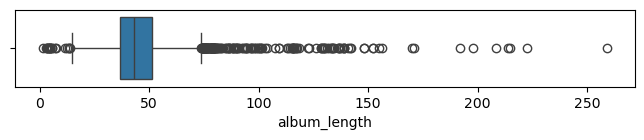

In [153]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df_lengths_found_concat, x='album_length')

In [156]:
# albums from which I found info on Spotipy, Wikipedia or Discogs
df_length_0[df_length_0['title'].isin(df_lengths_found_concat['title'].values)].shape

(2116, 13)

In [157]:
# albums still with album_length = 0
df_length_0[~df_length_0['title'].isin(df_lengths_found_concat['title'].values)].shape

(85, 13)

**Before doing the concat, I have to take care of the extended versions I found on Spotify**

## **Correcting long albums (``df_extended_versions``) from ``df_length_found_spotipy``**

In [3]:
df_masters[df_masters['title']=='The Yes Album']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
5169,50263,34991,3247857,UK,Yes,The Yes Album,1971,0.0,6,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...


In [175]:
df_lengths_found_spotipy[df_lengths_found_spotipy['title']=='The Yes Album']

,artist,title,name,album_length,tracks
2532,Yes,The Yes Album,the yes album (super deluxe edition),259.04,36


Here we can see an example, where it didn't find the standard version, but the super deluxe edition

In [180]:
df_lengths_found_concat['title_lower'] = df_lengths_found_concat['title'].str.lower()
df_lengths_found_concat.head()

,artist,title,name,album_length,tracks,title_lower
0,...And You Will Know Us by the Trail of Dead,Madonna,madonna,45.57,13.0,madonna
1,108,A New Beat From A Dead Heart,a new beat from a dead heart,34.65,13.0,a new beat from a dead heart
2,108,Songs of Separation,songs of separation,32.85,14.0,songs of separation
3,10cc,10cc,10cc,35.23,10.0,10cc
4,10cc,Deceptive Bends,deceptive bends,51.21,12.0,deceptive bends


In [179]:
df_lengths_found_concat.shape

(2890, 5)

In [184]:
df_lengths_found_concat[['name', 'title_lower']].duplicated().sum()

21

In [240]:
df_lengths_found_concat[df_lengths_found_concat['title']=='The Way I Fell In']

,artist,title,name,album_length,tracks,title_lower
2164,The Morning Of,The Way I Fell In,the way i fell in (uk/europe deluxe edition),53.31,15.0,the way i fell in


**Albums where it looks it took the right version (name == title_lower)**

In [204]:
df_lengths_found_correct = df_lengths_found_concat[df_lengths_found_concat['name'] == df_lengths_found_concat['title_lower']]
df_lengths_found_correct

,artist,title,name,album_length,tracks,title_lower
0,...And You Will Know Us by the Trail of Dead,Madonna,madonna,45.57,13.0,madonna
1,108,A New Beat From A Dead Heart,a new beat from a dead heart,34.65,13.0,a new beat from a dead heart
2,108,Songs of Separation,songs of separation,32.85,14.0,songs of separation
3,10cc,10cc,10cc,35.23,10.0,10cc
4,10cc,Deceptive Bends,deceptive bends,51.21,12.0,deceptive bends
...,...,...,...,...,...,...
2553,blink-182,One More Time...,one more time...,50.06,19.0,one more time...
2554,mclusky,McLusky Do Dallas,mclusky do dallas,36.05,14.0,mclusky do dallas
2555,ostraca,last,last,29.48,6.0,last
2556,tUnE-yArDs,Nikki Nack,nikki nack,44.40,13.0,nikki nack


**Albums where it looks it took a wrong version (name != title_lower) and ``name`` is not null (the ones I got from Wikipedia or Discogs)** 

In [198]:
df_extended_versions = df_lengths_found_concat[(df_lengths_found_concat['name'] != df_lengths_found_concat['title_lower']) & (~df_lengths_found_concat['name'].isna())]
df_extended_versions

,artist,title,name,album_length,tracks,title_lower
34,Adam and the Ants,Dirk Wears White Sox,dirk wears white sox (remastered),70.54,19.0,dirk wears white sox
35,Adam and the Ants,Kings of the Wild Frontier,kings of the wild frontier (deluxe edition),137.33,39.0,kings of the wild frontier
36,Adam and the Ants,Prince Charming,prince charming (remastered),57.65,16.0,prince charming
38,Adrenalin O.D.,The Wacky Hi-Jinks Of Adrenalin O.D.,the wacky hi-jinks of adrenalin o.d. (millenni...,24.54,15.0,the wacky hi-jinks of adrenalin o.d.
46,Agent Orange,Living in Darkness,living in darkness (40th anniversary edition),34.97,15.0,living in darkness
...,...,...,...,...,...,...
2526,Xiu Xiu,"Dear God, I Hate Myself","dear god, i hate myself - single",3.11,1.0,"dear god, i hate myself"
2530,Yes,Drama,topographic drama: live across america,136.82,13.0,drama
2532,Yes,The Yes Album,the yes album (super deluxe edition),259.04,36.0,the yes album
2536,You Me At Six,Cavalier Youth,cavalier youth (special edition),62.41,17.0,cavalier youth


<Axes: xlabel='album_length'>

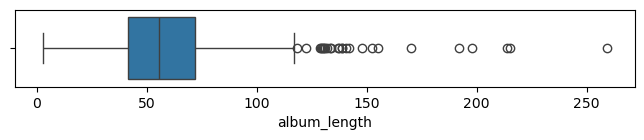

In [199]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df_extended_versions, x='album_length')

In [200]:
df_extended_versions['album_length'].mean()

62.408060606060594

### **Wikipedia**

In [201]:
start_index = 0
final_index = start_index + 1000

df_lengths_wikipedia = get_length_wikipedia(df_extended_versions, start_index, final_index)

1/1: Adam and the Ants - Dirk Wears White Sox
1/2: Adam and the Ants - Kings of the Wild Frontier
2/3: Adam and the Ants - Prince Charming
2/4: Adrenalin O.D. - The Wacky Hi-Jinks Of Adrenalin O.D.
3/5: Agent Orange - Living in Darkness
4/6: Alabama Shakes - Boys and Girls
5/7: Alabama Shakes - Sound and Color
6/8: Amebix - No Sanctuary
6/9: Amusement Parks On Fire - Out Of The Angeles
7/10: Anacrusis - Suffering Hour
8/11: Anna Calvi - One Breath
8/12: Arab on Radar - Queen Hygiene II
8/13: Atomic Rooster - Nice 'N' Greasy
8/14: Authority Zero - A Passage In Time
8/15: Bad Religion - How Could Hell Be Any Worse?
9/16: Badfinger - No Dice
9/17: Barclay James Harvest - Once Again
9/18: Baroness - Gold and Grey
9/19: Baroness - Stone
9/20: Baroness - Yellow and Green
9/21: Bear's Den - Red Earth and Pouring Rain
10/22: Beastie Boys - Check Your Head
10/23: Beck - One Foot In The Grave
11/24: Big Black - Atomizer
11/25: Big Ups - Eighteen Hours of Static
12/26: Bitch Magnet - Umber
13/27:

In [205]:
df_lengths_wikipedia['album_length'].mean()

40.599839572192515

**Looks right**

In [209]:
df_lengths_wikipedia_correct = df_lengths_wikipedia[~df_lengths_wikipedia['album_length'].isna()]
df_lengths_wikipedia_correct.shape

(187, 3)

In [211]:
df_lengths_found_correct = pd.concat([df_lengths_found_correct, df_lengths_wikipedia_correct])
df_lengths_found_correct.shape

(2415, 6)

In [213]:
df_length_still_missing = df_lengths_wikipedia[df_lengths_wikipedia['album_length'].isna()]
df_length_still_missing.shape

(143, 3)

### **Discogs API**

I have to define again the function, because I have dropped the ``master_id`` column

In [ ]:
def get_lengths_discogs(df):
    # create empty lists
    artists_list = []
    titles_list = []
    lengths_list = []
    count = 0
    scraped = 0

    # Function to calculate album length from tracklist durations
    def get_album_length(tracklist):
        song_durations = []
        for track in tracklist:
            try:
                song_duration = track['duration']
                minutes, seconds = map(int, song_duration.split(':'))
                song_duration_minutes = minutes + seconds / 60
                song_durations.append(song_duration_minutes)
            except Exception as e:
                pass
        return round(sum(song_durations), 2)

    for artist, title in df[['artist', 'title']].values:                         
        count += 1
        time.sleep(1)
        artists_list.append(artist)
        titles_list.append(title)
        query = artist + ' ' + title

        # Define API headers
        headers = {
            "User-Agent": 'Arnau', 
            "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"
        }

        # Set the API URL and params
        url = "https://api.discogs.com/database/search"
        params = {
            "per_page": 100,  # Number of results per page (max 100)
            'type': 'release',
            'format': 'album',
            'genre': 'Rock',
            'query': query
        }

        # Request the data from Discogs
        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # Store lengths for the album
        album_lengths = []

        # Iterate over the first 5 results
        for i in range(min(5, len(data['results']))):
            time.sleep(1)
            release_id = data['results'][i]['id']
            url2 = f"https://api.discogs.com/releases/{release_id}"
            response = requests.get(url2, headers=headers)
            data2 = response.json()

            try:
                tracklist = data2['tracklist']
                album_length = get_album_length(tracklist)
                if album_length > 0:
                    album_lengths.append(album_length)
            except KeyError:
                print(f"Tracklist not found for release {release_id}")
                continue

        # Choose a length for the album
        if album_lengths:
            average_length = round(sum(album_lengths) / len(album_lengths), 2)
            lengths_list.append(average_length)
            scraped+=1
        else:
            lengths_list.append(0)

        print(f"{scraped}/{count}: {artist} - {title}")
        
        # Create a DataFrame with the results
        df_lengths_found = pd.DataFrame({'artist': artists_list,
                                        'title': titles_list,
                                        'album_length': lengths_list})

    # I decided to export the csv inside the function because of the limitations of the Discogs API,
    # while trying I some code crashed in the middle, having lost time and data,
    # so I prefer the code to be slower but have the data exported at every new album scraped. 
        df_lengths_found.to_csv('Datasets/df_lengths_found_discogs.csv', index=False)

In [220]:
get_lengths_discogs(df_length_still_missing)

1/1: Adam and the Ants - Kings of the Wild Frontier
1/2: Adrenalin O.D. - The Wacky Hi-Jinks Of Adrenalin O.D.
2/3: Amusement Parks On Fire - Out Of The Angeles
3/4: Arab on Radar - Queen Hygiene II
4/5: Atomic Rooster - Nice 'N' Greasy
5/6: Authority Zero - A Passage In Time
6/7: Bad Religion - How Could Hell Be Any Worse?
7/8: Barclay James Harvest - Once Again
8/9: Baroness - Gold and Grey
9/10: Baroness - Stone
9/11: Baroness - Yellow and Green
10/12: Bear's Den - Red Earth and Pouring Rain
11/13: Beck - One Foot In The Grave
12/14: Big Ups - Eighteen Hours of Static
12/15: Blitz - Voice Of A Generation
13/16: Breaking Benjamin - Phobia
14/17: Bury Your Dead - Alive
15/18: Camel - Nude
16/19: Caroline - Caroline
17/20: Christian Death - Catastrophe Ballet
18/21: Circus Lupus - Super Genius
19/22: Colin Newman - A-Z
20/23: Crass - Stations of the Crass
20/24: Crobot - Something Supernatural
21/25: Cutting Pink With Knives - Populuxxe
22/26: Darkest Hour - So Sedated, so Secure
23/27

I decided to export the csv inside the function because of the limitations of the Discogs API, while trying I some code crashed in the middle, having lost time and data, so I prefer the code to be slower but have the data exported at every new album scraped. 

In [221]:
# import the csv of the albums scraped from Discogs
df_lengths_found_discogs = pd.read_csv('Datasets/df_lengths_found_discogs.csv')
df_lengths_found_discogs.shape

(143, 3)

### **Examining long albums from Discogs**

In [224]:
df_lengths_found_discogs['album_length'].mean()

50.00258741258741

<Axes: xlabel='album_length'>

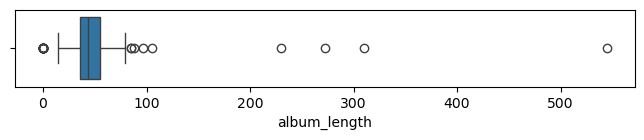

In [248]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df_lengths_found_discogs, x='album_length')

**There are some extreme values, something's not right**

In [258]:
df_lengths_found_discogs.sort_values('album_length', ascending=False).head()

,artist,title,album_length
117,The Morning Of,The Way I Fell In,544.47
62,Muse,Muse,310.24
53,King Crimson,USA,272.76
32,Dream Theater,Chaos in Motion,229.88
56,Led Zeppelin,The Song Remains The Same,105.68


In [ ]:
artist = 'The Morning Of'
title = 'The Way I Fell In'
query = artist + ' ' + title

# Define API headers
headers = {
    "User-Agent": 'Arnau', 
    "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"
}

# Set the API URL and params
url = "https://api.discogs.com/database/search"
params = {
    "per_page": 100,  # Number of results per page (max 100)
    'type': 'release',
    'format': 'album',
    'genre': 'Rock',
    'query': query
}

# Request the data from Discogs
response = requests.get(url, headers=headers, params=params)
data = response.json()

In [ ]:
for i in range(5):
    print(data['results'][i]['title'])

The Morning Of - The Way I Fell In
The Morning Of - The Way I Fell In
The Beatles - The Beatles In Mono
The Beatles - The Beatles In Mono
The Morning Of - The Way I Fell In


I don't know why it took two releases from *The Beatles*.

Still, there's no point on searching for these albums right now, because I took a quick glance and they all seem to be Live/Compilations, so I will take care of them (drop them) later.

In [225]:
df_lengths_found_correct.shape

(2415, 6)

In [226]:
# concat of the albums already corrected with the new ones scraped from Discogs
df_lengths_correct = pd.concat([df_lengths_found_correct, df_lengths_found_discogs])
df_lengths_correct.shape

(2558, 6)

In [233]:
df_lengths_found_correct['album_length'].mean()

44.56621532091098

In [ ]:
# albums correct so far
df_lengths_correct = df_lengths_correct[df_lengths_correct['album_length']!=0]
df_lengths_correct.shape

(2537, 6)

In [ ]:
# export to csv just in case, to not lose it
df_lengths_correct.to_csv('Datasets/df_lengths_correct.csv', index=False)

In [260]:
# albums that I have to look for manually, since I couldn't get the album length from Spotipy, Discogs or Wikipedia
df_length_manual = df_lengths_found_discogs[df_lengths_found_discogs['album_length']==0]
df_length_manual.shape

(21, 3)

#### **``np.where`` to correct the ``album_length``**

In [ ]:
# so I can print the np.where and I save time
for title in df_length_manual['title'].values:
    print(f'df_length_manual["album_length"] = np.where(df_length_manual["title"]=="{title}", "length", df_length_manual["album_length"])')

**Looking in the internet for the real length of these albums**

In [296]:
df_length_manual.tail(8) # so it's faster to copy the names of the artists to look for their origins on the internet

,artist,title,album_length
95,Sleeping With Sirens,Madness,0.0
96,Smile Empty Soul,Anxiety,0.0
101,Strongarm,The Advent of a Miracle,0.0
103,Suffocation,The Close Of A Chapter,0.0
125,Tickle Me Pink,Madeline,0.0
130,Total Abuse,Mutt,0.0
131,Tragedy,Tragedy,0.0
132,Trash Talk,Trash Talk,0.0


In [309]:
df_length_0[df_length_0['title']=='Trash Talk	'.strip()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2036,1344199,244174,2092525,US,Trash Talk,Trash Talk,2008,0.0,12,['Album'],['Rock'],['Hardcore'],"Sacramento, California"


In [14]:
def calculate_duration(duration):
    if isinstance(duration, str):  # If it's a string, we are dealing with "mm:ss"
        # Replace ':' with '.' and split
        minutes, seconds = map(int, duration.split(':'))
    elif isinstance(duration, float):  # If it's a float, just handle it
        minutes = int(duration)
        seconds = int((duration - minutes) * 60)
    else:
        raise ValueError("Duration should be a string or a float")
    
    # Convert to minutes
    duration_minutes = minutes + seconds / 60
    return duration_minutes

In [310]:
calculate_duration('16:41')

16.683333333333334

In [311]:
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="The Wacky Hi-Jinks Of Adrenalin O.D.", "24.03", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Voice Of A Generation", "45.23", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Pictures at an Exhibition", "38", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Wolves", "43.2", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Slave", "16.92", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Nines and Sixes", "32.37", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Amateurs and Professionals", "36.67", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Youth Anthems for the New Order", "11.25", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Anxiety", "51.75", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="The Advent of a Miracle", "35.22", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Madeline", "40.18", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Mutt", "27.75", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Tragedy", "19.37", df_length_manual["album_length"])
df_length_manual["album_length"] = np.where(df_length_manual["title"]=="Trash Talk", "16.69", df_length_manual["album_length"])

In [ ]:
df_length_manual['album_length'] = df_length_manual['album_length'].astype(float)
df_length_manual = df_length_manual[df_length_manual['album_length']>0]
df_length_manual

,artist,title,album_length
1,Adrenalin O.D.,The Wacky Hi-Jinks Of Adrenalin O.D.,24.03
14,Blitz,Voice Of A Generation,45.23
34,"Emerson, Lake and Palmer",Pictures at an Exhibition,38.00
44,Idiot Pilot,Wolves,43.20
45,Infest,Slave,16.92
61,Mock Orange,Nines and Sixes,32.37
69,Penfold,Amateurs and Professionals,36.67
85,Reagan Youth,Youth Anthems for the New Order,11.25
96,Smile Empty Soul,Anxiety,51.75
101,Strongarm,The Advent of a Miracle,35.22


In [ ]:
# concat of the albums already corrected with the new ones corrected
df_lengths_found = pd.concat([df_lengths_correct, df_length_manual])
df_lengths_found.shape

(2551, 6)

### **CONCAT ``df_lengths_found`` with ``df_length_0``**

In [ ]:
# concat of the albums already corrected with the new ones scraped from Discogs
df_concat = pd.concat([df_length_0, df_lengths_found])
df_concat.sort_values('album_length', ascending=False, inplace=True) # I put the album_length = 0 at the bottom so I can drop them as duplicates
df_concat = df_concat[['artist', 'title', 'album_length', 'tracks']] # keep only the columns I want
df_concat.drop_duplicates(inplace=True)
df_concat.shape

(4734, 4)

In [334]:
df_concat

,artist,title,album_length,tracks
117,The Morning Of,The Way I Fell In,544.47,NaN
62,Muse,Muse,310.24,NaN
53,King Crimson,USA,272.76,NaN
32,Dream Theater,Chaos in Motion,229.88,NaN
1259,Mike Oldfield,Tubular Bells,222.75,15.0
...,...,...,...,...
1472,Search The City,A Fire So Big The Heavens Can See It,0.00,10.0
1473,Sebadoh,The Freed Man,0.00,32.0
1474,Sebadoh,Weed Forestin,0.00,23.0
1475,Sebadoh,III,0.00,23.0


In [ ]:
df_concat[df_concat.duplicated()].shape

(1765, 4)

In [336]:
df_concat.drop_duplicates(subset=['artist', 'title'], inplace=True)
df_concat

,artist,title,album_length,tracks
117,The Morning Of,The Way I Fell In,544.47,NaN
62,Muse,Muse,310.24,NaN
53,King Crimson,USA,272.76,NaN
32,Dream Theater,Chaos in Motion,229.88,NaN
1259,Mike Oldfield,Tubular Bells,222.75,15.0
...,...,...,...,...
1447,Savage,Loose 'N Lethal,0.00,8.0
1448,Savage Grace,Master Of Disguise,0.00,9.0
1456,Say Anything,...Is a Real Boy,0.00,13.0
1461,Scott Walker,'Til the Band Comes in,0.00,15.0


In [377]:
df_concat[df_concat['album_length']==0].shape

(418, 4)

In [356]:
df_concat_correct = df_concat[df_concat['album_length']!=0]
df_concat_correct.shape

(2551, 4)

In [ ]:
# check one album
df_masters[df_masters['title']=="Tubular Bells"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
7096,18666,0,12898957,UK,Mike Oldfield,Tubular Bells,1973,0.00,1,"['LP', 'Album', 'Stereo']",['Rock'],['Folk Rock'],"Michael Gordon ""Mike"" Oldfield (born 15 May 19..."
8381,18666,15016,12556105,UK,Mike Oldfield,Tubular Bells,1973,48.83,2,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],"Michael Gordon ""Mike"" Oldfield (born 15 May 19..."


It's already in my ``df_masters``, one release has ``album_length = 0``, so that's why I detected it earlier, but the other one has the correct length, so I have to sort the values by ``album_length`` and drop duplicates by ``artist`` and ``title``

In [76]:
df_masters[df_masters[['artist','title']].duplicated()].shape

(67, 13)

In [350]:
df_masters.shape

(11346, 13)

In [77]:
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_masters.sort_values('album_length', ascending=False, inplace=True)
df_masters.drop_duplicates(subset=['artist', 'title'], inplace=True)
df_masters.shape

(11279, 13)

In [78]:
df_masters

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1508,366336,207843,2050306,US,Elliott,U.S. Songs,1998,2757.52,11,"['LP', 'Album']",['Rock'],"['Emo', 'Indie Rock']","Emo rock/post-hardcore band from Louisville, K..."
73,48424,1069022,1301683,US,Aerosmith,Box Of Fire,1994,515.28,134,"['Album', 'Reissue', 'Remastered']",['Rock'],['Hard Rock'],"Aerosmith is an American rock band, sometimes ..."
263,34278,518213,8741384,US,Led Zeppelin,The Complete Studio Recordings,1993,434.45,96,"['Album', 'Reissue', 'Remastered']",['Rock'],['Classic Rock'],The English rock band Led Zeppelin was active ...
7271,34278,3370798,5882431,US,Led Zeppelin,Led Zeppelin,2006,367.78,101,"['12""', '45 RPM', 'Single Sided', 'Album', 'Re...",['Rock'],"['Hard Rock', 'Arena Rock', 'Blues Rock']",The English rock band Led Zeppelin was active ...
7272,255680,267825,1911585,Europe,Eagles,Eagles,2005,325.50,84,['Album'],['Rock'],"['Country Rock', 'Classic Rock']",American rock band founded in 1971 by [a=Glenn...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,279473,34027,1778638,UK,Peter Hammill,Fool's Mate,1971,0.00,12,"['LP', 'Album']",['Rock'],"['Art Rock', 'Prog Rock']","English musician and recording artist, singer/..."
5209,279473,34009,1361472,UK,Peter Hammill,Chameleon in the Shadow of the Night,1973,0.00,11,"['LP', 'Album']",['Rock'],"['Art Rock', 'Prog Rock']","English musician and recording artist, singer/..."
5211,279473,33999,580889,UK,Peter Hammill,A Black Box,1980,0.00,8,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock']","['Art Rock', 'Experimental', 'Prog Rock']","English musician and recording artist, singer/..."
5212,134825,33892,379479,UK,New Model Army,Impurity,1990,0.00,11,"['LP', 'Album']",['Rock'],"['Folk Rock', 'New Wave']",With their roots embedded in the early punk er...


**Separate ``df_masters`` in 2 df**

In [79]:
# albums from df_masters with album_length correct
df_masters_correct = df_masters[df_masters['album_length']!=0]
df_masters_correct.shape

(9109, 13)

In [81]:
df_masters_correct.to_csv('Datasets/df_masters_correct.csv', index=False)

In [80]:
df_masters_0 = df_masters[df_masters['album_length']==0]
df_masters_0.shape

(2170, 13)

In [82]:
df_masters_0.to_csv('Datasets/df_masters_0.csv', index=False)

In [ ]:
# Of these albums, I already have info of album length or they are from after 2010
df_concat_correct[~df_concat_correct['title'].isin(df_masters_0['title'].values)]

,artist,title,album_length,tracks
1259,Mike Oldfield,Tubular Bells,222.75,15.0
1863,Steven Wilson,The Future Bites,170.90,30.0
272,Blur,Parklive,141.57,30.0
2336,Titus Andronicus,The Most Lamentable Tragedy,92.82,29.0
1235,Matisyahu,Spark Seeker,86.39,20.0
...,...,...,...,...
1039,Joyce Manor,Of All Things I Will Soon Grow Tired,13.14,9.0
809,God Damn,Vultures,5.63,1.0
1236,Matt Berninger,Serpentine Prison,4.54,1.0
1262,Miles Kane,Don't Forget Who You Are,3.42,1.0


In [378]:
df_lenght_missing_still = df_masters_0[~df_masters_0['title'].isin(df_concat_correct['title'].values)]
df_lenght_missing_still.shape

(404, 13)

In [380]:
df_lenght_missing_still.to_csv('Datasets/df_lenght_missing_still.csv', index=False)

#### **Check extreme lengths of ``df_check``**

In [384]:
df_check = df_concat_correct[df_concat_correct['title'].isin(df_masters_0['title'].values)]
df_check.reset_index(drop=True, inplace=True)
df_check

,artist,title,album_length,tracks
0,The Morning Of,The Way I Fell In,544.47,NaN
1,Muse,Muse,310.24,NaN
2,King Crimson,USA,272.76,NaN
3,Dream Theater,Chaos in Motion,229.88,NaN
4,Armored Saint,Symbol Of Salvation,208.45,50.0
...,...,...,...,...
1759,Reagan Youth,Youth Anthems for the New Order,11.25,NaN
1760,Riot,Army Of One,4.41,1.0
1761,Faith No More,We Care a Lot,4.17,1.0
1762,Mott The Hoople,All the Young Dudes,3.53,NaN


In [381]:
# check one album
df_masters[df_masters['title']=="Chaos in Motion	".strip()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11144,260935,329221,5245920,US,Dream Theater,Chaos in Motion,2008,0.0,21,"['DVD-Video', 'NTSC']",['Rock'],"['Prog Rock', 'Heavy Metal']","American progressive metal band, formed in Bos..."


<Axes: xlabel='album_length'>

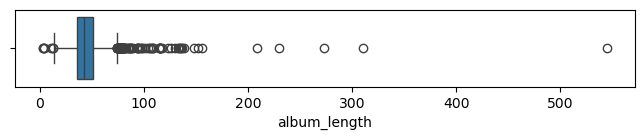

In [385]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df_check, x='album_length')

In [398]:
df_check.shape

(1761, 4)

In [ ]:
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_check.sort_values('album_length', ascending=False, inplace=True)
df_check.reset_index(drop=True, inplace=True)
df_check.head(10)

,artist,title,album_length,tracks
0,Genesis,The Lamb Lies Down on Broadway,94.28,NaN
1,Drive-By Truckers,Southern Rock Opera,93.91,20.0
2,Phish,Junta,86.67,14.0
3,Pink Floyd,Ummagumma,86.58,16.0
4,The Who,Quadrophenia,81.9,28.0
5,Pink Floyd,The Wall,80.99,26.0
6,Bongripper,Hippie Killer,79.96,10.0
7,Tori Amos,The Beekeeper,79.25,19.0
8,Wo Fat,The Gathering Dark,78.93,12.0
9,Crippled Black Phoenix,A Love of Shared Disasters,76.52,12.0


**Let's try to get the info in Wikipedia**

In [106]:
start_index = 0
final_index = start_index + 10

df_lengths_wikipedia = get_length_wikipedia(df_check, start_index, final_index)

1/1: Guns N' Roses - Live Era '87-'93
2/2: Yes - Yessongs
2/3: Onslaught - In Search Of Sanity
2/4: Phish - Junta
3/5: Beth Orton - Trailer Park
4/6: The Fall - Middle Class Revolt
5/7: The Byrds - Sweetheart of the Rodeo
6/8: Wings - Wings Over America
6/9: Virgin Steele - Age Of Consent
7/10: Dexys Midnight Runners - Searching for the Young Soul Rebels


In [125]:
# check the number of tracks is correct
df_masters[df_masters['title']=="The Lamb Lies Down on Broadway	".strip()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
7153,124506,0,8413457,UK,Genesis,The Lamb Lies Down on Broadway,1974,0.0,26,"['LP', 'Album']",['Rock'],"['Prog Rock', 'Classic Rock']","Formed at Charterhouse School, Godalming, Surr..."


**Drop live albums, compilations...**

In [120]:
try:
    df_check.drop([2], axis=0, inplace=True)
except:
    pass

##### **``np.where`` to correct the ``album_length``**

In [ ]:
# so I can print the np.where and I save time
for title in df_check.head(10)['title'].values:
    print(f'df_check["album_length"] = np.where(df_check["title"]=="{title}", "length", df_check["album_length"])')

In [116]:
calculate_duration('47:59')

47.983333333333334

In [117]:
df_check["album_length"] = np.where(df_check["title"]=="In Search Of Sanity", "57.9", df_check["album_length"])
df_check["album_length"] = np.where(df_check["title"]=="Junta", "86.67", df_check["album_length"])
df_check["album_length"] = np.where(df_check["title"]=="Trailer Park", "59.55", df_check["album_length"])
df_check["album_length"] = np.where(df_check["title"]=="Middle Class Revolt", "50.13", df_check["album_length"])
df_check["album_length"] = np.where(df_check["title"]=="Sweetheart of the Rodeo", "32.58", df_check["album_length"])
df_check["album_length"] = np.where(df_check["title"]=="Age Of Consent", "47.98", df_check["album_length"])
df_check["album_length"] = np.where(df_check["title"]=="Searching for the Young Soul Rebels", "41.62", df_check["album_length"])

In [98]:
df_lengths_wikipedia

,artist,title,album_length
0,Guns N' Roses,Live Era '87-'93,133.03
1,Yes,Yessongs,129.27
2,Onslaught,In Search Of Sanity,NaN
3,Phish,Junta,NaN
4,Beth Orton,Trailer Park,59.55
5,The Fall,Middle Class Revolt,50.13
6,The Byrds,Sweetheart of the Rodeo,32.58
7,Wings,Wings Over America,115.55
8,Virgin Steele,Age Of Consent,NaN
9,Dexys Midnight Runners,Searching for the Young Soul Rebels,41.62


<Axes: xlabel='album_length'>

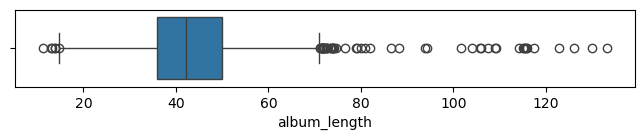

In [ ]:
df_check['album_length'] = df_check['album_length'].astype(float)
plt.figure(figsize=(8,1))
sns.boxplot(data=df_check, x='album_length')

### **Merge ``df_check`` with ``df_masters_0``**

In [91]:
df_masters_correct[df_masters_correct['title']=='Unsilent Death	'.strip()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [122]:
df_masters[df_masters['title'].isin(df_check['title'].values)].shape

(1670, 13)

In [144]:
df_masters_correct.columns

Index(['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile'],
      dtype='object')

In [146]:
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

df_masters_0_merged = pd.merge(df_masters_0, df_check, on=['artist', 'title'])\
                .drop(columns=(['album_length_x', 'tracks_y']))\
                .rename(columns={'tracks_x': 'tracks', 'album_length_y': 'album_length'})\
                .reindex(columns=list_of_columns)
df_masters_0_merged

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,1568573,286236,1926811,US,Dark Castle,Spirited Migration,2009,37.12,8,['Album'],['Rock'],"['Doom Metal', 'Sludge Metal']",Doom metal/drone/sludge two-piece from St. Aug...
1,64756,634337,3395941,US,Butch Walker,Sycamore Meadows,2008,60.08,12,['LP'],"['Rock', 'Pop']",['Alternative Rock'],"American musician, songwriter, and record prod..."
2,985408,1334170,1957740,US,The Protomen,Act II: The Father of Death,2009,57.33,12,['Album'],['Rock'],"['Hard Rock', 'Glam']",The Protomen are an American rock band best kn...
3,546072,296540,2618180,US,El Ten Eleven,It's Still Like a Secret,2010,41.67,12,"['LP', 'Album', 'Limited Edition']",['Rock'],['Post Rock'],El Ten Eleven is a Los Angeles post-rock duo k...
4,253422,623298,751882,Europe,Five For Fighting,Two Lights,2006,43.45,10,['Album'],['Rock'],"['Alternative Rock', 'Pop Rock']",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,279473,34051,1360023,UK,Peter Hammill,Over,1977,51.51,8,"['LP', 'Album', 'Stereo']",['Rock'],"['Art Rock', 'Acoustic']","English musician and recording artist, singer/..."
1656,279473,34027,1778638,UK,Peter Hammill,Fool's Mate,1971,62.21,12,"['LP', 'Album']",['Rock'],"['Art Rock', 'Prog Rock']","English musician and recording artist, singer/..."
1657,279473,34009,1361472,UK,Peter Hammill,Chameleon in the Shadow of the Night,1973,68.29,11,"['LP', 'Album']",['Rock'],"['Art Rock', 'Prog Rock']","English musician and recording artist, singer/..."
1658,279473,33999,580889,UK,Peter Hammill,A Black Box,1980,40.89,8,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock']","['Art Rock', 'Experimental', 'Prog Rock']","English musician and recording artist, singer/..."


### **CONCAT ``df_masters_0_merged`` with ``df_masters_correct``**

In [152]:
# concat of the albums already corrected with the new ones scraped from Discogs
df_concat = pd.concat([df_masters_correct, df_masters_0_merged])
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_concat.sort_values('album_length', ascending=False, inplace=True) # I put the album_length = 0 at the bottom so I can drop them as duplicates
df_concat.drop_duplicates(inplace=True)
df_concat.shape

(10769, 13)

In [157]:
df_concat.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,366336,207843,2050306,US,Elliott,U.S. Songs,1998,2757.52,11,"['LP', 'Album']",['Rock'],"['Emo', 'Indie Rock']","Emo rock/post-hardcore band from Louisville, K..."


In [155]:
df_concat.to_csv('Datasets/df_concat.csv', index=False)

### **Dropping unnecessary columns**

In [158]:
df_concat.columns

Index(['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile'],
      dtype='object')

In [160]:
# drop the columns I'm no longer interested in so it's easier to work with my df before cleaning some more
df_concat = df_concat[['master_id', 'artist', 'title', 'year', 'album_length', 'tracks', 'styles', 'artist_profile']]
df_concat.head()

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,207843,Elliott,U.S. Songs,1998,2757.52,11,"['Emo', 'Indie Rock']","Emo rock/post-hardcore band from Louisville, K..."
1,1069022,Aerosmith,Box Of Fire,1994,515.28,134,['Hard Rock'],"Aerosmith is an American rock band, sometimes ..."
2,518213,Led Zeppelin,The Complete Studio Recordings,1993,434.45,96,['Classic Rock'],The English rock band Led Zeppelin was active ...
3,3370798,Led Zeppelin,Led Zeppelin,2006,367.78,101,"['Hard Rock', 'Arena Rock', 'Blues Rock']",The English rock band Led Zeppelin was active ...
4,267825,Eagles,Eagles,2005,325.50,84,"['Country Rock', 'Classic Rock']",American rock band founded in 1971 by [a=Glenn...


### **``df_missing_still``**

In [ ]:
# these are the albums that still have album_length = 0
df_length_missing_still = pd.read_csv('Datasets/df_length_missing_still.csv')
df_length_missing_still.shape

It's neverending... I think I tried to get them from Spotipy, so let's check if they are in **Wikipedia**

In [167]:
start_index = 0
final_index = start_index + 1000

df_lengths_wikipedia = get_length_wikipedia(df_length_missing_still, start_index, final_index)

1/1: Say Anything - ...Is a Real Boy
2/2: Grim Reaper - Rock You To Hell
3/3: The Vandals - When in Rome Do as the Vandals
4/4: Bill Fay - Time of the Last Persecution
5/5: Beck - Golden Feelings
5/6: PIG - Praise The Lard
5/7: Weekend - Sports
6/8: Omen - Warning of Danger
6/9: Tank - Honour And Blood
7/10: Stereophonics - Keep Calm and Carry On
8/11: W.A.S.P. - Still Not Black Enough
9/12: Gonjasufi - A Sufi and a Killer
9/13: Sebadoh - Weed Forestin
10/14: The Vandals - Hitler Bad, Vandals Good
10/15: Rich Kids on LSD - Keep Laughing
10/16: Druid - Toward the Sun
11/17: Whiplash - Power and Pain
11/18: Nucleus (UK) - We'll Talk About It Later
11/19: Miasma and The Carousel of Headless Horses - Perils
11/20: Comus - To Keep From Crying
11/21: Blitzkrieg - A Time Of Changes
11/22: DOOM - War Crimes (Inhuman Beings)
11/23: Iron Maiden - Visions Of The Beast
11/24: Gasp - Drome Triler of Puzzle Zoo People
11/25: Treepeople - Guilt Regret Embarrassment
12/26: The Courteeners - St. Jude
1

In [176]:
df_lengths_wikipedia_correct = df_lengths_wikipedia[~df_lengths_wikipedia['album_length'].isna()].sort_values('album_length', ascending=False)
df_lengths_wikipedia_correct.shape

(178, 3)

In [172]:
df_lengths_0 = df_lengths_wikipedia[df_lengths_wikipedia['album_length'].isna()]
df_lengths_0.shape

(226, 3)

In [178]:
df_lengths_0.to_csv('Datasets/df_lengths_0.csv', index=False)

Let's try to look for the missing ones in **Discogs**

In [263]:
df_lengths_found_discogs = pd.read_csv('Datasets/df_lengths_found_discogs.csv')
df_lengths_found_discogs.shape

(226, 3)

In [267]:
df_discogs_correct = df_lengths_found_discogs[df_lengths_found_discogs['album_length']!=0]
df_discogs_correct.shape

(144, 3)

In [270]:
df_missing_length = df_lengths_found_discogs[df_lengths_found_discogs['album_length']==0]
df_missing_length.shape

(82, 3)

In [271]:
df_missing_length.to_csv('Datasets/df_missing_length.csv', index=False)

In [272]:
df_found = pd.concat([df_lengths_wikipedia_correct, df_discogs_correct])
df_found.shape

(322, 3)

In [280]:
df_found.to_csv('Datasets/df_found.csv', index=False)

### **CONCAT with ``df_concat``**

In [279]:
df_found['album_length'] = df_found['album_length'].astype(float)
df_found.sort_values('album_length', ascending=False, inplace=True)
df_found.reset_index(drop=True, inplace=True)
df_found

,artist,title,album_length
0,Burden of a Day,Blessed Be Our Ever After,2263.25
1,Math the Band,Banned the Math,550.99
2,Sun City Girls,Dante's Disneyland Inferno,138.98
3,Joe Satriani,Satriani Live!,128.47
4,Pendragon,Pure,119.37
...,...,...,...
317,The Locust,The Locust,17.70
318,Fugazi,Margin Walker,17.13
319,Hirax,"Hate, Fear And Power",16.00
320,Converge,Halo In A Haystack,7.10


<Axes: xlabel='album_length'>

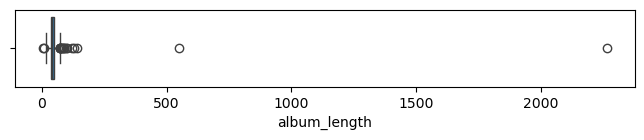

In [281]:
df_found['album_length'] = df_found['album_length'].astype(float)
plt.figure(figsize=(8,1))
sns.boxplot(data=df_found, x='album_length')

In [282]:
df_found['album_length'] = df_found['album_length'].astype(float)
df_found.sort_values('album_length', ascending=False, inplace=True)
df_found.reset_index(drop=True, inplace=True)
df_found.iloc[0:10]

,artist,title,album_length
0,Burden of a Day,Blessed Be Our Ever After,2263.25
1,Math the Band,Banned the Math,550.99
2,Sun City Girls,Dante's Disneyland Inferno,138.98
3,Joe Satriani,Satriani Live!,128.47
4,Pendragon,Pure,119.37
5,Five Iron Frenzy,The End Is Near,99.74
6,Pillar,The Reckoning,98.17
7,Hexen,State of Insurgency,90.22
8,The Comsat Angels,Sleep No More,87.75
9,The Fall,Shift-Work,85.87


**I will clean them later, after concatenate it with ``df_concat``, so that I clean everything at once**

#### **Merge with ``df_masters``** to get back the missing columns

In [286]:
df_masters[df_masters['title']=='Blessed Be Our Ever After'.strip()].sort_values('year')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
10652,2675107,2341150,3824628,US,Burden of a Day,Blessed Be Our Ever After,2008,0.0,11,['Album'],['Rock'],"['Hardcore', 'Heavy Metal']",Years Active : 2000 - 2010\r\n\r\nBurden of a ...


In [292]:
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

df_found_merged = df_masters.merge(df_found, on=['title', 'artist']).drop(columns=(['album_length_x']))\
                            .rename(columns={'album_length_y': 'album_length'})\
                            .reindex(columns=list_of_columns)
df_found_merged.shape

(322, 13)

#### **CONCAT with ``df_concat``**

In [296]:
# concat of the albums already corrected with the new ones scraped from Discogs
df_concat = pd.concat([df_concat, df_found_merged])
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_concat.sort_values('album_length', ascending=False, inplace=True) # I put the album_length = 0 at the bottom so I can drop them as duplicates
df_concat.drop_duplicates(inplace=True)
df_concat.shape

(11057, 13)

In [297]:
df_concat.head(1)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile,artist_id,main_release_id,release_country,release_type,genres
18,2341150,Burden of a Day,Blessed Be Our Ever After,2008,2263.25,11,"['Hardcore', 'Heavy Metal']",Years Active : 2000 - 2010\r\n\r\nBurden of a ...,2675107.0,3824628.0,US,['Album'],['Rock']


In [298]:
# drop the columns I'm no longer interested in so it's easier to work with my df before cleaning some more
df_concat = df_concat[['master_id', 'artist', 'title', 'year', 'album_length', 'tracks', 'styles', 'artist_profile']]
df_concat.head()

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
18,2341150,Burden of a Day,Blessed Be Our Ever After,2008,2263.25,11,"['Hardcore', 'Heavy Metal']",Years Active : 2000 - 2010\r\n\r\nBurden of a ...
43,2533003,Math the Band,Banned the Math,2008,550.99,21,"['Chiptune', 'Punk']",Math the Band is an American chiptune-based sy...
0,611495,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,"['Acoustic', 'Southern Rock', 'Goth Rock', 'Fo...",NaN
1,22493,The Magnetic Fields,69 Love Songs,1999,172.07,72,"['Synth-pop', 'Indie Rock']",The Magnetic Fields (named after the [a945713]...
2,1727628,Electric Masada,At the Mountains of Madness,2005,156.83,15,"['Noise', 'Contemporary Jazz', 'Avantgarde', '...",[b]Electric Masada[/b] is one of [a=John Zorn]...


In [299]:
df_concat.to_csv('Datasets/df_concat.csv', index=False)

#### **Merge ``df_missing_length`` with ``df_masters``** to get back the missing columns

In [ ]:
df_masters[df_masters['title']=='1372 Overton Park	'.strip()].sort_values('year')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11207,317913,444106,2035078,US,Lucero,1372 Overton Park,2009,0.0,12,['LP'],"['Rock', 'Folk, World, & Country']","['Alternative Rock', 'Country Rock']",Country rock group formed in the late 1990s fr...


In [ ]:
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

df_missing_merged = df_masters.merge(df_missing_length, on=['title', 'artist']).drop(columns=(['album_length_x']))\
                            .rename(columns={'album_length_y': 'album_length'})\
                            .reindex(columns=list_of_columns)
df_missing_merged.shape

(81, 13)

In [ ]:
df_missing_merged.sort_values('album_length', ascending=False, inplace=True)
df_missing_merged.reset_index(drop=True, inplace=True)
df_missing_merged = df_missing_merged[['master_id', 'artist', 'title', 'year', 'album_length', 'tracks', 'styles', 'artist_profile']]
df_missing_merged

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,3419971,Folly,Resist Convenience,2006,65.40,12,"['Hardcore', 'Punk']","Hardcore/punk/ska/metal band from New Jersey, ..."
1,506945,Dispatch,Who Are We Living For?,2000,64.65,17,['Indie Rock'],Indie roots folk jam band formed at Middlebury...
2,0,My Hero Is Me,The Crywolf Broadcast,2008,52.55,11,['Metalcore'],NaN
3,1175679,Margot and the Nuclear So and So's,Animal!,2008,51.00,12,['Indie Rock'],"Chris Fry-drums\r\nRichard Edwards-vocals, gui..."
4,0,Rosaline,The Vitality Theory,2010,48.00,11,"['Hardcore', 'Punk']",NaN
...,...,...,...,...,...,...,...,...
76,1114333,Janus,Red Right Return,2008,0.00,10,"['Alternative Rock', 'Hardcore']",American alternative metal band formed in Chic...
77,813752,Automatic Loveletter,Truth or Dare,2010,0.00,12,['Alternative Rock'],NaN
78,777174,Skeletonwitch,At One With the Shadows,2004,0.00,9,"['Thrash', 'Black Metal']",American thrash/black/death metal band from At...
79,3384481,Forgive Durden,Wonderland,2006,0.00,11,"['Emo', 'Indie Rock', 'Alternative Rock']","Indie rock band from Bellevue, Washington form..."


In [ ]:
df_missing_merged.to_csv('Datasets/df_missing_merged.csv', index=False)

### **``df_missing_merged``** that I couldn't get from Wikipedia or Discogs

I had to search these albums (approx 80) on the internet: Rate your Music, Wikipedia (different name than what I searched), Last.fm, AllMusic...

**Drop live albums, compilations...**

In [ ]:
try:
    df_missing_merged.drop([], axis=0, inplace=True)
except:
    pass

#### **``np.where`` to correct the ``album_length``**

In [ ]:
# so I can print the np.where and I save time
for title in df_missing_merged.iloc[69:]['title'].values:
    print(f'df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="{title}", "length", df_missing_merged["album_length"])')

In [366]:
calculate_duration('44:11')

44.18333333333333

In [479]:
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="Dark Mountain", "15.3", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="Dancing With A Ghost", "41.75", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="Daddy Has A Tail!", "37.1", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="Audio Prozac", "40", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="Arcade Rock", "39.6", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="All Creatures Great and Eaten", "22.6", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="A Hostage and the Meaning of Life", "48.1", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="72826", "22.6", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="1372 Overton Park", "46.5", df_missing_merged["album_length"])
df_missing_merged["album_length"] = np.where(df_missing_merged["title"]=="...We Are Still Alive", "30.3", df_missing_merged["album_length"])

In [480]:
df_missing_merged['album_length'] = df_missing_merged['album_length'].astype(float)
df_missing_merged.sort_values(['album_length', 'title'], ascending=False, inplace=True)
df_missing_merged.reset_index(drop=True, inplace=True)

# make sure the number of tracks is correct, sometimes it isn't
df_missing_merged.tail()

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
74,617632,Paul Baribeau,Grand Ledge,2008,18.00,9,['Acoustic'],"Paul Baribeau is from Grand Ledge, MI."
75,286891,Punch,Push Pull,2010,16.25,13,"['Thrash', 'Hardcore', 'Punk']","Hardcore band from San Francisco, CA."
76,440433,Infest,No Man's Slave,2002,16.05,19,"['Hardcore', 'Power Violence', 'Thrash', 'Punk']","American Hardcore band, formed in September 19..."
77,407870,Loma Prieta,Dark Mountain,2009,15.30,8,"['Hardcore', 'Punk', 'Emo']","Loma Prieta (translates to ""Dark Hill"") is an ..."
78,107197,Charles Bronson,Youth Attack!,1997,13.00,20,"['Thrash', 'Hardcore', 'Punk', 'Power Violence']","American Powerviolence band from DeKalb, Illin..."


In [481]:
df_missing_merged['album_length'].value_counts().head()

album_length
35.00    2
22.60    2
20.40    2
71.85    1
30.75    1
Name: count, dtype: int64

#### **CONCAT with ``df_concat``**

In [486]:
# concat of the albums already corrected with the new ones scraped from Discogs
df_concat = pd.concat([df_concat, df_missing_merged])
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_concat.sort_values('album_length', ascending=False, inplace=True) # I put the album_length = 0 at the bottom so I can drop them as duplicates
df_concat.drop_duplicates(inplace=True)
df_concat.shape

(11129, 8)

In [487]:
df_concat.head(1)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,611495,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,"['Acoustic', 'Southern Rock', 'Goth Rock', 'Fo...",NaN


In [545]:
df_concat.to_csv('Datasets/df_concat.csv', index=False)

In [544]:
df_concat.shape

(11103, 8)

# **Check extreme lengths of ``df_concat``**

In [491]:
df_concat = pd.read_csv('Datasets/df_concat.csv')
df_concat.shape

(11129, 8)

<Axes: xlabel='album_length'>

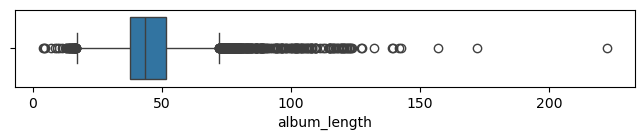

In [492]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df_concat, x='album_length')

In [ ]:
# df_concat = df_concat[['master_id', 'artist', 'title', 'year', 'album_length', 'tracks', 'styles', 'artist_profile']]

In [ ]:
# df_concat.to_csv('Datasets/df_concat.csv', index=False)

In [ ]:
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_concat.sort_values('album_length', ascending=False, inplace=True)
df_concat.reset_index(drop=True, inplace=True)
df_concat.iloc[12:22]

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
12,1644630,Blue October,Argue With A Tree...,2005,122.95,25,['Alternative Rock'],Blue October is an American alternative rock b...
13,38645,Red Hot Chili Peppers,Stadium Arcadium,2006,122.42,30,"['Alternative Rock', 'Funk Metal']",Funk/alternative rock band formed in 1982 in L...
14,59388,The Beatles,Anthology 1,1995,122.32,60,"['Rock & Roll', 'Pop Rock', 'Beat']","Emerging from Liverpool, England in 1960, the ..."
15,327285,Trans-Siberian Orchestra,Night Castle,2009,121.70,27,"['Symphonic Rock', 'Symphonic Metal']",Trans-Siberian Orchestra (often abbreviated as...
16,268831,The Black Crowes,Croweology,2010,121.58,20,"['Blues Rock', 'Rock & Roll', 'Southern Rock']","US blues rock band from Atlanta, Georgia. Form..."
17,48721,The Smashing Pumpkins,Mellon Collie and the Infinite Sadness,1995,121.17,30,['Alternative Rock'],Alternative Rock (Modern Rock) band from Chica...
18,294995,Amplifier,The Octopus,2010,120.57,18,"['Alternative Rock', 'Space Rock', 'Prog Rock']","British alternative rock band from Manchester,..."
19,398186,Porcupine Tree,Atlanta,2010,120.57,16,['Prog Rock'],English progressive rock band founded in 1987 ...


In [ ]:
df_concat[df_concat['artist']=='KISS'.strip()].sort_values('year')

In [ ]:
df_ratings_20[df_ratings_20['artist']=='Metallica'.strip()].sort_values('title')

**Let's try to get the info in Wikipedia**

In [530]:
start_index = 23
final_index = start_index + 10

df_lengths_wikipedia = get_length_wikipedia(df_concat, start_index, final_index)

1/1: Tom Waits - Glitter and Doom Live
1/2: Belle and Sebastian - The BBC Sessions
2/3: Symphony X - Live on the Edge of Forever
3/4: George Harrison - All Things Must Pass
4/5: Kyuss - ...And The Circus Leaves Town
4/6: Led Zeppelin - The Song Remains The Same
4/7: Poison - Swallow This Live
4/8: Failure - Golden: Unreleased Sounds and Images
5/9: Staind - 14 Shades of Grey
5/10: Pink Floyd - Delicate Sound Of Thunder


#### **``np.where`` to correct the ``album_length``**

In [529]:
# so I can print the np.where and I save time
for title in df_concat.iloc[23:33]['title'].values:
    print(f'df_concat["album_length"] = np.where(df_concat["title"]=="{title}", "length", df_concat["album_length"])')

df_concat["album_length"] = np.where(df_concat["title"]=="Glitter and Doom Live", "length", df_concat["album_length"])
df_concat["album_length"] = np.where(df_concat["title"]=="The BBC Sessions", "length", df_concat["album_length"])
df_concat["album_length"] = np.where(df_concat["title"]=="Live on the Edge of Forever", "length", df_concat["album_length"])
df_concat["album_length"] = np.where(df_concat["title"]=="All Things Must Pass", "length", df_concat["album_length"])
df_concat["album_length"] = np.where(df_concat["title"]=="...And The Circus Leaves Town", "length", df_concat["album_length"])
df_concat["album_length"] = np.where(df_concat["title"]=="The Song Remains The Same", "length", df_concat["album_length"])
df_concat["album_length"] = np.where(df_concat["title"]=="Swallow This Live", "length", df_concat["album_length"])
df_concat["album_length"] = np.where(df_concat["title"]=="Golden: Unreleased Sounds and Images", "length", df_concat["album_length"])
df_concat["album_length"]

**Drop live albums, compilations...**

In [538]:
try:
    df_concat.drop([32], axis=0, inplace=True)
except:
    pass

In [320]:
calculate_duration('61:28')

61.46666666666667

In [540]:
df_concat["album_length"] = np.where(df_concat["title"]=="ELO 2", "41.8", df_concat["album_length"])


In [541]:
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_concat.sort_values('album_length', ascending=False, inplace=True)
df_concat.reset_index(drop=True, inplace=True)
df_concat.iloc[23:33]

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
23,56036,George Harrison,All Things Must Pass,1970,106.00,23,['Pop Rock'],"British rock guitarist, singer-songwriter and ..."
24,169874,Hawkwind,Choose Your Masques,1982,103.95,10,"['Space Rock', 'Psychedelic Rock', 'Hard Rock'...","Formed in 1969, Hawkwind are a prolific and pi..."
25,3930,Nine Inch Nails,The Fragile,1999,103.93,25,"['Alternative Rock', 'Industrial', 'Ambient', ...",Industrial rock band Nine Inch Nails (abbrevia...
26,220456,Beach House,Teen Dream,2010,103.58,21,"['Indie Pop', 'Dream Pop']","Beach House is a dream pop duo from Baltimore,..."
27,26291,Judas Priest,Nostradamus,2008,102.80,25,['Heavy Metal'],British Heavy Metal band preceding the ‘New Wa...
28,433107,IQ,Subterranea,1997,102.57,19,['Prog Rock'],British progressive rock band founded in South...
29,170452,John Mayer,Any Given Thursday,2003,102.27,15,['Pop Rock'],"American musician born October 16, 1977 in Bri..."
30,33433,Van der Graaf Generator,Present,2005,101.88,16,['Prog Rock'],"Formed in the UK in 1967 by [a=Peter Hammill],..."
31,621529,Esoteric,The Maniacal Vale,2008,101.82,7,"['Funeral Doom Metal', 'Death Metal']",Esoteric was founded in July 1992 in Birmingha...
32,81253,Gang of Four,Return the Gift,2005,101.55,27,"['Post-Punk', 'Indie Rock']","English post-punk group from Leeds, formed in ..."


In [ ]:
# check it's decreasing
df_concat['album_length'].mean()

45.52749256957579

In [531]:
df_lengths_wikipedia

,artist,title,album_length
0,Tom Waits,Glitter and Doom Live,109.50
1,Belle and Sebastian,The BBC Sessions,NaN
2,Symphony X,Live on the Edge of Forever,106.03
3,George Harrison,All Things Must Pass,106.00
4,Kyuss,...And The Circus Leaves Town,71.98
5,Led Zeppelin,The Song Remains The Same,NaN
6,Poison,Swallow This Live,NaN
7,Failure,Golden: Unreleased Sounds and Images,NaN
8,Staind,14 Shades of Grey,62.22
9,Pink Floyd,Delicate Sound Of Thunder,NaN


**I could be hours (or days) checking these albums, but let's just move on to have enough time to analyze the data**

<Axes: xlabel='album_length'>

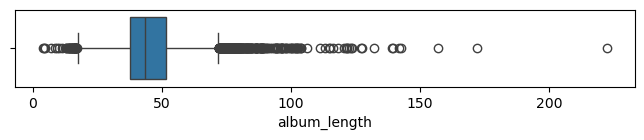

In [543]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df_concat, x='album_length')

# **Drop live albums, compilations...**

## **Searching for the most prolific artists**

Even though I dropped some with regex and other strategies like sorting for the longest albums and the ones with the highest number of tracks, there are many more still in my dataframe.

I know it's impossible to delete them all, so I'm just gonna look for the bands that have more releases.

In [699]:
df_concat['artist'].value_counts().head(25)

artist
Elton John            27
Alice Cooper          25
The Rolling Stones    24
Bob Dylan             23
The Beach Boys        22
Jethro Tull           21
Uriah Heep            21
David Bowie           19
The Fall              19
Saxon                 19
Deep Purple           18
The Kinks             18
KISS                  18
Lou Reed              18
Black Sabbath         18
Nazareth              18
Melvins               17
Eric Clapton          17
UFO                   17
Van Morrison          17
Yes                   17
Overkill              16
Frank Zappa           16
Santana               16
Fleetwood Mac         16
Name: count, dtype: int64

In [706]:
df_concat['year'] = df_concat['year'].astype(int)
df_concat[df_concat['artist']=='Grateful Dead'].sort_values('year')

,master_id,artist,title,year,album_length,tracks,styles,artist_profile


**Drop live albums, compilations...**

In [704]:
try:
    df_concat.drop([44], axis=0, inplace=True)
except:
    pass

In [589]:
df_concat.tail()

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
11100,317257.0,Annuals,Such Fun,2008,4.55,11,"['Experimental', 'Indie Rock', 'Prog Rock']","American indie rock band from Raleigh, North C..."
11101,279672.0,Flyleaf,Memento Mori,2010,4.37,15,"['Alternative Rock', 'Hard Rock', 'Nu Metal', ...",Flyleaf is an American alternative rock band t...
11102,155653.0,Fischerspooner,Odyssey,2005,3.97,12,"['Electro', 'Synth-pop', 'Prog Rock']",American electroclash duo founded in 1998 in N...
11103,NaN,The Rolling Stones,Goat's Head Soup,1973,46.78,10,['Blues Rock'],NaN
11104,NaN,Elton John,Honky Château,1972,45.20,10,"['Pop Rock', 'Classic Rock']",NaN


In [ ]:
# in case I have to add albums that didn't merge correctly between Discogs and Sputnik
for column in df_concat.columns:
    print(f"df_concat.loc[11103, '{column}'] = ")

In [668]:
df_concat.loc[11106, 'artist'] = 'Black Sabbath'
df_concat.loc[11106, 'title'] = "Vol. 4"
df_concat.loc[11106, 'year'] = 1972
df_concat.loc[11106, 'album_length'] = 43.1
df_concat.loc[11106, 'tracks'] = 10
df_concat.loc[11106, 'styles'] = "['Hard Rock', 'Heavy Metal']"

In [722]:
df_concat[df_concat['artist']==("Grateful Dead")]

,master_id,artist,title,year,album_length,tracks,styles,artist_profile


In [743]:
df_ratings_20[df_ratings_20['artist']==("Grateful Dead")].sample()

,album_id,artist,title,rating,votes
41778,252423,Grateful Dead,Cornell 5/8/77,4.47,36


In [714]:
df_uk_masters[df_uk_masters['master_id']==18535]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
14385,246650.0,18535.0,1151529,US,The Grateful Dead,The Grateful Dead,1967,34.88,9,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Blues Rock']",American rock band (1965–1995) formed in the S...


**Change ``df_ratings_20`` so when I merge both df it will find these albums**

In [933]:
df_ratings_20.loc[1884, 'title'] = "Goat's Head Soup"
df_ratings_20.loc[5583, 'title'] = "Honky Château"

In [934]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

**Albums added**

In [ ]:
# df_concat.loc[11103, 'artist'] = 'The Rolling Stones'
# df_concat.loc[11103, 'title'] = "Goat's Head Soup"
# df_concat.loc[11103, 'year'] = 1973
# df_concat.loc[11103, 'album_length'] = 46.78
# df_concat.loc[11103, 'tracks'] = 10
# df_concat.loc[11103, 'styles'] = "['Blues Rock']"

# df_concat.loc[11104, 'artist'] = 'Elton John'
# df_concat.loc[11104, 'title'] = "Honky Château"
# df_concat.loc[11104, 'year'] = 1972
# df_concat.loc[11104, 'album_length'] = 45.2
# df_concat.loc[11104, 'tracks'] = 10
# df_concat.loc[11104, 'styles'] = "['Pop Rock', 'Classic Rock']"

# df_concat.loc[11105, 'artist'] = 'The Fall'
# df_concat.loc[11105, 'title'] = "The Wonderful And Frightening World Of The Fall"
# df_concat.loc[11105, 'year'] = 1984
# df_concat.loc[11105, 'album_length'] = 40.1
# df_concat.loc[11105, 'tracks'] = 9
# df_concat.loc[11105, 'styles'] = "['Punk']"

# df_concat.loc[11106, 'artist'] = 'Black Sabbath'
# df_concat.loc[11106, 'title'] = "Vol. 4"
# df_concat.loc[11106, 'year'] = 1972
# df_concat.loc[11106, 'album_length'] = 43.1
# df_concat.loc[11106, 'tracks'] = 10
# df_concat.loc[11106, 'styles'] = "['Hard Rock', 'Heavy Metal']"

## **Missing artists**

In searching for the most prolific artists, I thought of ***Grateful Dead***, also because I was expecting to find my live albums, and to my surprise they were nowhere to be found.

Turns out they are under **different names in both websites**, so I create a separate dataframe, change the artist name and concat it to ``df_concat``.

In [726]:
df_uk_masters[df_uk_masters['artist']==("Grateful Dead")]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [724]:
df_ratings_20[df_ratings_20['artist']==("Grateful Dead")].sample()

,album_id,artist,title,rating,votes
813,1064,Grateful Dead,Grateful Dead,3.99,101


In [728]:
df_uk_masters[df_uk_masters['artist']==("The Grateful Dead")].sample()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
18287,246650.0,18484.0,378826,US,The Grateful Dead,Hundred Year Hall,1995,142.3,15,['Album'],['Rock'],"['Country Rock', 'Folk Rock', 'Psychedelic Rock']",American rock band (1965–1995) formed in the S...


In [735]:
df_grateful_dead_us = df_us_masters[df_us_masters['artist']==("The Grateful Dead")].sort_values('year')
df_grateful_dead_us.shape

(25, 13)

In [736]:
df_grateful_dead_uk = df_uk_masters[df_uk_masters['artist']==("The Grateful Dead")].sort_values('year')
df_grateful_dead_uk.shape

(40, 13)

In [739]:
df_grateful_dead = pd.concat([df_grateful_dead_uk, df_grateful_dead_us])
df_grateful_dead.drop_duplicates(inplace=True)
df_grateful_dead = df_grateful_dead[['master_id', 'artist', 'title', 'year', 'album_length', 'tracks', 'styles', 'artist_profile']]
df_grateful_dead.shape

(65, 8)

In [740]:
df_grateful_dead['artist'] = 'Grateful Dead'
df_grateful_dead.head(1)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
18285,548684.0,Grateful Dead,"Dick's Picks Volume Three: Pembroke Pines, Flo...",0,138.02,16,"['Blues Rock', 'Folk Rock', 'Psychedelic Rock'...",American rock band (1965–1995) formed in the S...


In [742]:
df_grateful_dead[df_grateful_dead['album_length']==0].shape

(14, 8)

I have to deal again with the same problem... ONE LAST TIME

But let's first drop the live albums and compilations

In [748]:
# it's a live album
df_ratings_20.drop([813], axis=0, inplace=True)

In [749]:
# different name on Discogs
df_ratings_20.loc[416, 'title'] = 'Grateful Dead'

**Drop live albums, compilations...**

In [765]:
try:
    df_grateful_dead.drop([22550], axis=0, inplace=True)
except:
    pass

In [766]:
df_grateful_dead.sort_values('year').head(20)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
14385,18535.0,Grateful Dead,The Grateful Dead,1967,34.88,9,"['Psychedelic Rock', 'Blues Rock']",American rock band (1965–1995) formed in the S...
4719,18447.0,Grateful Dead,Anthem Of The Sun,1968,0.00,5,['Psychedelic Rock'],American rock band (1965–1995) formed in the S...
56410,18450.0,Grateful Dead,Aoxomoxoa,1969,0.00,7,"['Acid Rock', 'Psychedelic Rock', 'Experimental']",American rock band (1965–1995) formed in the S...
31489,18489.0,Grateful Dead,Workingman's Dead,1970,35.55,8,"['Folk Rock', 'Country Rock', 'Classic Rock']",American rock band (1965–1995) formed in the S...
20566,18442.0,Grateful Dead,American Beauty,1970,42.38,10,['Folk Rock'],American rock band (1965–1995) formed in the S...
13159,18545.0,Grateful Dead,Wake Of The Flood,1973,32.38,7,"['Country Rock', 'Folk Rock', 'Pop Rock']",American rock band (1965–1995) formed in the S...
13145,18467.0,Grateful Dead,From The Mars Hotel,1974,37.20,8,"['Folk Rock', 'Country Rock', 'Psychedelic Rock']",American rock band (1965–1995) formed in the S...
13150,18456.0,Grateful Dead,Blues For Allah,1975,44.22,11,"['Blues Rock', 'Folk Rock', 'Psychedelic Rock']",American rock band (1965–1995) formed in the S...
13136,18527.0,Grateful Dead,Steal Your Face,1976,82.08,14,['Country Rock'],American rock band (1965–1995) formed in the S...
40499,18474.0,Grateful Dead,Terrapin Station,1977,35.63,6,"['Folk Rock', 'Country Rock']",American rock band (1965–1995) formed in the S...


In [768]:
# after 1989 they didn't release any studio albums
df_grateful_dead = df_grateful_dead[df_grateful_dead['year']<=1989]
df_grateful_dead.shape

(14, 8)

In [769]:
start_index = 0
final_index = start_index + 20

df_lengths_wikipedia = get_length_wikipedia(df_grateful_dead, start_index, final_index)

1/1: Grateful Dead - The Grateful Dead
1/2: Grateful Dead - Anthem Of The Sun
2/3: Grateful Dead - Aoxomoxoa
3/4: Grateful Dead - Workingman's Dead
4/5: Grateful Dead - American Beauty
4/6: Grateful Dead - Wake Of The Flood
4/7: Grateful Dead - From The Mars Hotel
4/8: Grateful Dead - Blues For Allah
5/9: Grateful Dead - Steal Your Face
6/10: Grateful Dead - Terrapin Station
7/11: Grateful Dead - Shakedown Street
7/12: Grateful Dead - In The Dark
7/13: Grateful Dead - Go To Heaven
8/14: Grateful Dead - Built To Last


### **``np.where`` to correct the ``album_length``**

In [777]:
df_lengths_wikipedia.head()

,artist,title,album_length
0,Grateful Dead,The Grateful Dead,34.88
1,Grateful Dead,Anthem Of The Sun,NaN
2,Grateful Dead,Aoxomoxoa,36.00
3,Grateful Dead,Workingman's Dead,35.55
4,Grateful Dead,American Beauty,42.35


In [773]:
df_grateful_dead["album_length"] = np.where(df_grateful_dead["title"]=="Anthem Of The Sun", "39.1", df_grateful_dead["album_length"])
df_grateful_dead["album_length"] = np.where(df_grateful_dead["title"]=="Aoxomoxoa", "36", df_grateful_dead["album_length"])

In [775]:
df_grateful_dead.head()

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
14385,18535.0,Grateful Dead,The Grateful Dead,1967,34.88,9,"['Psychedelic Rock', 'Blues Rock']",American rock band (1965–1995) formed in the S...
4719,18447.0,Grateful Dead,Anthem Of The Sun,1968,39.1,5,['Psychedelic Rock'],American rock band (1965–1995) formed in the S...
56410,18450.0,Grateful Dead,Aoxomoxoa,1969,36,7,"['Acid Rock', 'Psychedelic Rock', 'Experimental']",American rock band (1965–1995) formed in the S...
31489,18489.0,Grateful Dead,Workingman's Dead,1970,35.55,8,"['Folk Rock', 'Country Rock', 'Classic Rock']",American rock band (1965–1995) formed in the S...
20566,18442.0,Grateful Dead,American Beauty,1970,42.38,10,['Folk Rock'],American rock band (1965–1995) formed in the S...


In [776]:
df_concat.head()

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,"['Acoustic', 'Southern Rock', 'Goth Rock', 'Fo...",NaN
1,22493.0,The Magnetic Fields,69 Love Songs,1999,172.07,72,"['Synth-pop', 'Indie Rock']",The Magnetic Fields (named after the [a945713]...
2,1727628.0,Electric Masada,At the Mountains of Madness,2005,156.83,15,"['Noise', 'Contemporary Jazz', 'Avantgarde', '...",[b]Electric Masada[/b] is one of [a=John Zorn]...
3,14996.0,The Clash,Sandinista!,1980,142.37,37,"['Rock & Roll', 'Dub', 'Punk', 'Post-Punk', 'R...",Influential British punk rock group from west ...
4,8895.0,Swans,Soundtracks for the Blind,1996,141.62,28,"['Alternative Rock', 'Industrial', 'Post Rock'...","Swans is a band from New York City, active fro..."


### **CONCAT with ``df_concat``**

In [778]:
df_concat.shape

(11053, 8)

In [780]:
# concat of the albums already corrected with the new ones scraped from Discogs
df_concat = pd.concat([df_concat, df_grateful_dead])
df_concat['album_length'] = df_concat['album_length'].astype(float)
df_concat.sort_values('album_length', ascending=False, inplace=True) # I put the album_length = 0 at the bottom so I can drop them as duplicates
df_concat.drop_duplicates(inplace=True)
df_concat.shape

(11067, 8)

## **Drop incorrect artists**

In [42]:
df_concat[df_concat['artist']=='Sabbat'].sort_values('artist_profile')

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
1253,289438.0,Sabbat,The Dwelling,1996,59.80,1,"['Thrash', 'Black Metal']",A Japanese black/thrash metal group from Mie.\...
2152,449014.0,Sabbat,Fetishism,1994,54.00,10,"['Thrash', 'Black Metal']",A Japanese black/thrash metal group from Mie.\...
3228,211528.0,Sabbat,Evoke,1992,49.57,11,"['Thrash', 'Black Metal']",A Japanese black/thrash metal group from Mie.\...
4141,119283.0,Sabbat,Karmagmassacre,2003,46.58,9,"['Black Metal', 'Heavy Metal']",A Japanese black/thrash metal group from Mie.\...
4394,330495.0,Sabbat,Envenom,1991,45.93,12,"['Thrash', 'Black Metal']",A Japanese black/thrash metal group from Mie.\...
2842,234045.0,Sabbat,Mourning Has Broken,1991,51.00,8,['Speed Metal'],"Formed in Nottingham, England, in June 1985 fr..."
5129,42893.0,Sabbat,Dreamweaver,1989,44.20,9,['Thrash'],"Formed in Nottingham, England, in June 1985 fr..."
6329,42892.0,Sabbat,History of a Time to Come,1988,41.70,9,['Thrash'],"Formed in Nottingham, England, in June 1985 fr..."


2 artists named the same, but one is Japanese

In [43]:
try:
    print(f"Rows before dropping: {df_concat.shape[0]}")
    df_concat.drop([1253,2152,3228,4141,4394], axis=0, inplace=True)
    print(f"Rows after dropping: {df_concat.shape[0]}")
except:
    pass

Rows before dropping: 11067
Rows after dropping: 11062


### **Exporting to csv**

In [44]:
df_concat.to_csv('Datasets/other datasets/df_concat.csv', index=False)

# **Merge with ``ratings``**

In [45]:
df_concat.shape

(11062, 8)

In [46]:
df_concat.head(1)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,"['Acoustic', 'Southern Rock', 'Goth Rock', 'Fo...",NaN


In [47]:
df_ratings_20.head(1)

,album_id,artist,title,rating,votes
0,37,Less Than Jake,Losing Streak,3.9,414


In [48]:
df = pd.merge(
    df_ratings_20.assign(artist_lower=df_ratings_20['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_20['title'].str.lower().str.strip()), 
    df_concat.assign(artist_lower=df_concat['artist'].str.lower().str.strip(), 
                      title_lower=df_concat['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['master_id', 'album_id', 'artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# sort columns
columns_list = ['year', 'artist', 'title', 'rating', 'votes', 'album_length', 'tracks', 'styles']
df = df[columns_list]

# print the df
df

,year,artist,title,rating,votes,album_length,tracks,styles
0,1996,Less Than Jake,Losing Streak,3.90,414,37.08,17,"['Ska', 'Punk']"
1,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,"['Indie Rock', 'Alternative Rock']"
2,2003,Muse,Absolution,3.99,4411,52.18,14,['Alternative Rock']
3,1999,Muse,Showbiz,3.50,2181,49.65,12,"['Alternative Rock', 'Prog Rock']"
4,2002,Finch,What It Is to Burn,3.69,864,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']"
...,...,...,...,...,...,...,...,...
11055,2010,Car Seat Headrest,1,2.71,21,57.30,16,"['Alternative Rock', 'Lo-Fi', 'Garage Rock', '..."
11056,1996,Only Living Witness,Innocents,4.00,20,39.27,10,['Hardcore']
11057,2000,Ceremonium,No Longer Silent,3.93,22,32.95,6,"['Death Metal', 'Doom Metal']"
11058,1972,Jerry Garcia,Garcia,4.14,28,40.07,10,"['Folk Rock', 'Psychedelic Rock']"


<Axes: xlabel='rating', ylabel='Count'>

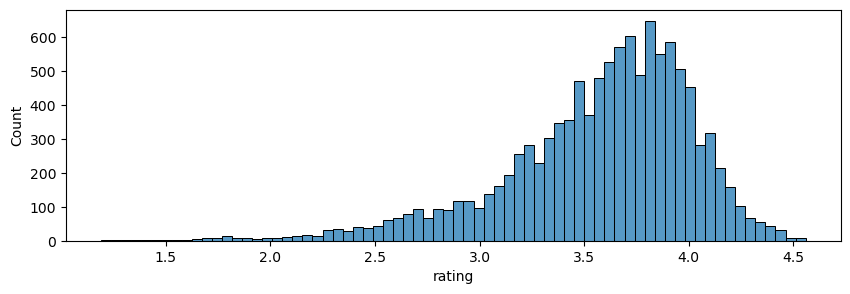

In [49]:
plt.figure(figsize=(10,3))
sns.histplot(data=df, x='rating')

In [50]:
# create a new column
df['avg_song_length'] = round(df['album_length'] / df['tracks'],2)

# sort columns
columns_list = ['year', 'artist', 'title', 'rating', 'votes', 'album_length', 'tracks', 'avg_song_length', 'styles']
df = df[columns_list]
df

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,styles
0,1996,Less Than Jake,Losing Streak,3.90,414,37.08,17,2.18,"['Ska', 'Punk']"
1,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,3.97,"['Indie Rock', 'Alternative Rock']"
2,2003,Muse,Absolution,3.99,4411,52.18,14,3.73,['Alternative Rock']
3,1999,Muse,Showbiz,3.50,2181,49.65,12,4.14,"['Alternative Rock', 'Prog Rock']"
4,2002,Finch,What It Is to Burn,3.69,864,61.18,13,4.71,"['Emo', 'Post-Hardcore', 'Alternative Rock']"
...,...,...,...,...,...,...,...,...,...
11055,2010,Car Seat Headrest,1,2.71,21,57.30,16,3.58,"['Alternative Rock', 'Lo-Fi', 'Garage Rock', '..."
11056,1996,Only Living Witness,Innocents,4.00,20,39.27,10,3.93,['Hardcore']
11057,2000,Ceremonium,No Longer Silent,3.93,22,32.95,6,5.49,"['Death Metal', 'Doom Metal']"
11058,1972,Jerry Garcia,Garcia,4.14,28,40.07,10,4.01,"['Folk Rock', 'Psychedelic Rock']"


In [ ]:
df_coordinates_final = pd.read_csv('Datasets/df_coordinates_final.csv')
df_coordinates_final.shape

(5633, 7)

In [ ]:
df_coordinates_final.head(1)

,artist,country,city,latitude,longitude,address,state
0,Nirvana,United States,Aberdeen,46.975371,-123.815722,"Aberdeen, Grays Harbor County, Washington, 985...",Washington


In [ ]:
df_coordinates_final['city'].value_counts().head(10)

city
London           404
Los Angeles      367
New York City    189
Chicago          152
San Francisco    120
Seattle           99
Boston            97
Brooklyn          80
Philadelphia      71
Portland          70
Name: count, dtype: int64

In [ ]:
df_albums = pd.merge(df_total, df_coordinates_final, on ='artist')\
                .drop(columns=['latitude', 'longitude', 'address'])
df_albums

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,subgenre,style,country,city,state
0,2007,!!!,Myth Takes,3.48,94,60.22,13,4.63,indie,Alternative Rock,United States,Sacramento,California
1,2007,!!!,Myth Takes,3.48,94,60.22,13,4.63,indie,Indie Rock,United States,Sacramento,California
2,2010,!!!,"Strange Weather, Isn't It?",3.06,41,40.80,9,4.53,indie,Indie Rock,United States,Sacramento,California
3,1985,'Til Tuesday,Voices Carry,3.60,26,38.62,10,3.86,indie,New Wave,United States,Boston,Massachusetts
4,1985,'Til Tuesday,Voices Carry,3.60,26,38.62,10,3.86,indie,Pop Rock,United States,Boston,Massachusetts
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,2007,xDEATHSTARx,We Are The Threat,2.70,20,35.58,11,3.23,metal,Metalcore,United States,Redlands,California
16841,2004,yourcodenameis:milo,Ignoto,3.77,50,47.41,12,3.95,indie,Alternative Rock,United Kingdom,Washington,England
16842,2007,yourcodenameis:milo,They Came From the Sun,3.46,27,49.48,12,4.12,indie,Emo,United Kingdom,Washington,England
16843,2007,yourcodenameis:milo,They Came From the Sun,3.46,27,49.48,12,4.12,indie,Indie Rock,United Kingdom,Washington,England


In [ ]:
df_albums.to_csv('Datasets/df_albums.csv', index=False)

In [28]:
df.to_csv('Datasets/df_ratings.csv', index=False)

# **``tracks``**

With the ``avg_song_length``, I can take a look at extreme values and see if these albums actually have so few tracks

In [63]:
df.sort_values('avg_song_length', ascending=False).head(10)

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,styles
2440,1990,Mike Oldfield,Amarok,4.01,67,60.03,1,60.03,"['Prog Rock', 'Art Rock', 'Experimental']"
10469,2002,Echolyn,Mei,4.22,27,49.55,1,49.55,['Prog Rock']
8234,2009,Jesu,Infinity,3.25,144,49.53,1,49.53,"['Industrial', 'Drone', 'Post Rock', 'Ambient'..."
1282,2003,Sleep,Dopesmoker,4.19,1260,73.12,2,36.56,['Doom Metal']
7232,2006,Asunder,Works Will Come Undone,3.52,25,72.82,2,36.41,"['Funeral Doom Metal', 'Dark Ambient', 'Drone']"
7391,2005,Moss,Cthonic Rites,3.75,20,66.03,2,33.02,"['Funeral Doom Metal', 'Drone']"
7758,2006,Fauna,Rain,3.30,33,63.30,2,31.65,"['Dark Ambient', 'Black Metal']"
7948,2001,Old Man Gloom,Seminar III: Zozobra,4.02,187,27.32,1,27.32,"['Doom Metal', 'Post Rock']"
8127,2007,Sunn O))),Oracle,3.56,72,80.92,3,26.97,"['Doom Metal', 'Experimental', 'Ambient']"
10446,2006,Bongripper,The Great Barrier Reefer,3.76,42,79.37,3,26.46,['Doom Metal']


In [61]:
df.loc[9442,'tracks'] = 7
df.loc[7758,'tracks'] = 2
df.loc[3548,'tracks'] = 4
df.loc[2883,'tracks'] = 6
df.loc[10925,'tracks'] = 5
df.loc[10925,'album_length'] = 38

# define again the colum to re-calculate the avg_song_length
df['avg_song_length'] = round(df['album_length'] / df['tracks'],2)

In [64]:
# if I detect live albums, compilations...
try:
    print(f"Rows before dropping: {df.shape[0]}")
    df.drop([3949], axis=0, inplace=True)
    print(f"Rows after dropping: {df.shape[0]}")
except:
    print("Couldn't find this row, sorry")
    pass

Rows before dropping: 11059
Couldn't find this row, sorry


I could change some values, but Doom Metal indeed have some albums with very long songs...

In [ ]:
df_albums[df_albums['subgenre']=='classic'].query("year == 1990").sort_values('avg_song_length', ascending=False)['avg_song_length'].mean()

12.37590909090909

In [ ]:
df_albums[df_albums['style']=='Doom Metal'].sort_values('avg_song_length')['avg_song_length'].mean()

7.613632812500001

In [67]:
df_concat = df.copy()

# **``styles``** (again)

In [ ]:
df_concat[df_concat['styles']=='[]'].shape

(38, 8)

## **Looking for the missing ``styles``**

My approach is to get the styles from other releases of that album, because from the master release it said it had no styles.

In [791]:
percentage_styles_missing = round((df_concat['styles']=='[]').sum() / df_concat.shape[0] * 100, 2)

print(f"albums missing style: {(df_concat['styles']=='[]').sum()} ")
print(f'% missing styles: {percentage_styles_missing}%')

albums missing style: 38 
% missing styles: 0.34%


### Testing

In [792]:
# I am going to get the releases from the master_id, so I cannot search the albums where master_id = 0, I will search these ones manually
df_concat[df_concat['styles']=='[]'].query('master_id == 0')['title'].count()

0

In [793]:
# luckily all of them have a master_id
df_styles_missing = df_concat[df_concat['styles']=='[]'].query('master_id != 0') 
df_styles_missing.shape

(38, 8)

In [799]:
df_styles_missing['master_id'] = df_styles_missing['master_id'].astype(int)
df_styles_missing.head()

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
645,350751,Umphrey's McGee,Safety In Numbers,2006,68.05,13,[],Jam rock / progressive rock band from South Be...
1113,411298,Graves of Valor,Salarian Gate,2009,61.38,11,[],"Formed in December 2005 in Florence, South Car..."
1179,292437,Kid Rock,Born Free,2010,60.67,13,[],A self-proclaimed redneck from the midwestern ...
1579,301354,The Moody Blues,Strange Times,1999,57.55,14,[],"British rock group from Birmingham, England, f..."
1683,455567,Mat Kearney,Nothing Left to Lose,2006,56.97,13,[],"American singer-songwriter born in Eugene, Ore..."


### **Applying the function to get ``df_styles_found``**

In [ ]:
def get_styles(df):

    most_common_styles = []
    count = 0

    for master_id in df_styles_missing['master_id'].values:
        time.sleep(1)
        count+=1
        url = "https://api.discogs.com/database/search"
        headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

        # Define parameters for artist search
        params = {
            "per_page": 100   # Number of results per page (max 100)
            , 'type': 'release'
            , 'format': 'album'
            , 'genre': 'Rock'
            , 'master_id': master_id
        }

        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # create an empty list
        styles_list = []

        # iterate over all the releases
        for i in range(len(data['results'])):
            style = data['results'][i]['style'] # get the style(s)
            if style: 
                styles_list.append(style)
            else:
                styles_list.append(np.nan)

        try:
            most_common_style = pd.Series(styles_list).value_counts().idxmax()
            print(f"{count} - {most_common_style}")
        except:
            print(f'{count} - No styles found')
            most_common_style = np.nan

        most_common_styles.append(most_common_style)
    
    df_styles_found = pd.DataFrame({'master_id': df_styles_missing['master_id'].values,
                                    'styles': most_common_styles})
    return df_styles_found

In [800]:
df_styles_found = get_styles(df_styles_missing)

1 - ['Prog Rock']
2 - ['Death Metal']
3 - ['Southern Rock', 'Pop Rock']
4 - ['Folk Rock', 'Pop Rock']
5 - ['Pop Rock']
6 - ['Emo', 'Indie Rock']
7 - ['Gangsta', 'Nu Metal']
8 - ['Alternative Rock', 'Experimental']
9 - ['Alternative Rock']
10 - ['Alternative Rock', 'Emo']
11 - ['Pop Rock']
12 - ['Alternative Rock']
13 - ['Alternative Rock', 'Nu Metal']
14 - ['Alternative Rock']
15 - ['Alternative Rock']
16 - ['Emo']
17 - ['Hard Rock']
18 - ['Folk Rock', 'Indie Rock']
19 - ['Folk Rock', 'Psychedelic Rock']
20 - ['Emo', 'Pop Punk']
21 - ['Alternative Rock', 'Pop Rock']
22 - ['Alternative Rock', 'Pop Rock']
23 - ['Alternative Rock']
24 - ['Folk Rock', 'Psychedelic Rock', 'Experimental']
25 - ['Emo', 'Alternative Rock']
26 - ['Emo', 'Indie Rock']
27 - ['Nu Metal']
28 - ['Blues Rock', 'Jazz-Rock']
29 - ['Alternative Rock', 'Pop Punk']
30 - ['Emo', 'Power Pop']
31 - ['Folk Rock']
32 - ['Alternative Rock']
33 - ['Alternative Rock', 'Power Pop', 'Garage Rock']
34 - ['Acoustic', 'Indie Rock']
35

In [801]:
df_styles_found

,master_id,styles
0,350751,[Prog Rock]
1,411298,[Death Metal]
2,292437,"[Southern Rock, Pop Rock]"
3,301354,"[Folk Rock, Pop Rock]"
4,455567,[Pop Rock]
5,892292,"[Emo, Indie Rock]"
6,227937,"[Gangsta, Nu Metal]"
7,914054,"[Alternative Rock, Experimental]"
8,2315194,[Alternative Rock]
9,278727,"[Alternative Rock, Emo]"


In [ ]:
# save it in a .csv just in case
df_styles_found.to_csv('Datasets/df_styles_found.csv', index=False)

In [ ]:
# in case I have to import it again
df_styles_found = pd.read_csv('Datasets/df_styles_found.csv')

In [802]:
df_concat.shape

(11067, 8)

### **Changing the type of ``styles``**

In [803]:
df_concat.styles.nunique()

3377

In [804]:
df_concat.head(2)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,"['Acoustic', 'Southern Rock', 'Goth Rock', 'Fo...",NaN
1,22493.0,The Magnetic Fields,69 Love Songs,1999,172.07,72,"['Synth-pop', 'Indie Rock']",The Magnetic Fields (named after the [a945713]...


**Separate ``df`` in 2 dataframes, one with the correct styles and the other df where ``styles = []``**

In [806]:
df_styles_empty = df_concat[df_concat['styles']=='[]']
df_styles_empty.shape

(38, 8)

In [808]:
df_styles_good = df_concat[df_concat['styles']!='[]']
df_styles_good.shape

(11029, 8)

It looks like they are lists, but actually...

In [809]:
type(df_styles_good.styles[0])

str

In [810]:
# convert these strings to lists
df_styles_good.styles = df_styles_good.styles.apply(ast.literal_eval)
type(df_styles_good.styles[0])

list

In [811]:
df_styles_good.head(2)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,"[Acoustic, Southern Rock, Goth Rock, Folk, Sho...",NaN
1,22493.0,The Magnetic Fields,69 Love Songs,1999,172.07,72,"[Synth-pop, Indie Rock]",The Magnetic Fields (named after the [a945713]...


In [812]:
df_styles_good['styles'].value_counts().head()

styles
[Alternative Rock]    466
[Indie Rock]          424
[Death Metal]         286
[Punk]                260
[Hardcore]            257
Name: count, dtype: int64

### **Merge with ``df_styles_found``**

In [813]:
# to copy them for later sorting the columns in the merged df
df_styles_empty.columns

Index(['master_id', 'artist', 'title', 'year', 'album_length', 'tracks',
       'styles', 'artist_profile'],
      dtype='object')

In [814]:
df_styles_merged = pd.merge(df_styles_empty, df_styles_found, on=['master_id'])
df_styles_merged.drop(columns='styles_x', inplace=True)
df_styles_merged.rename(columns={'styles_y': 'styles'}, inplace=True)

# sort the columns
list_of_columns = ['master_id', 'artist', 'title', 'year', 'album_length', 'tracks', 'styles', 'artist_profile']
df_styles_merged = df_styles_merged[list_of_columns]
df_styles_merged.shape

(38, 8)

In [815]:
# check everything is fine
df_styles_merged.sample(3)

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
24,505094.0,Hawthorne Heights,Skeletons,2010,42.07,13,"[Emo, Alternative Rock]","Emo-punk band from Dayton, Ohio, U.S.A.\r\n\r\..."
13,334954.0,Switchfoot,Hello Hurricane,2009,49.10,12,[Alternative Rock],Alternative Rock (Modern Rock) band from San D...
21,280579.0,KT Tunstall,Tiger Suit,2010,42.93,11,"[Alternative Rock, Pop Rock]","Born June 23, 1975 Edinburgh, Scotland. Is a S..."


### **Concat ``df_styles_good`` with ``df_styles_merged``**

In [816]:
type(df_styles_merged.styles[0]) # each element should be a list

list

In [817]:
df_masters_blended = pd.concat([df_styles_good, df_styles_merged])
df_masters_blended.shape

(11067, 8)

In [818]:
df_styles_good['styles'].value_counts().head()

styles
[Alternative Rock]    466
[Indie Rock]          424
[Death Metal]         286
[Punk]                260
[Hardcore]            257
Name: count, dtype: int64

In [819]:
df_masters_blended['styles'].value_counts().head()

styles
[Alternative Rock]    473
[Indie Rock]          424
[Death Metal]         287
[Punk]                260
[Hardcore]            258
Name: count, dtype: int64

By printing the ``value_counts()`` of each dataframe I make sure the albums that had ``styles = []`` are now included, we can see the count has increased

In [820]:
df_masters_blended

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,"[Acoustic, Southern Rock, Goth Rock, Folk, Sho...",NaN
1,22493.0,The Magnetic Fields,69 Love Songs,1999,172.07,72,"[Synth-pop, Indie Rock]",The Magnetic Fields (named after the [a945713]...
2,1727628.0,Electric Masada,At the Mountains of Madness,2005,156.83,15,"[Noise, Contemporary Jazz, Avantgarde, Fusion,...",[b]Electric Masada[/b] is one of [a=John Zorn]...
3,14996.0,The Clash,Sandinista!,1980,142.37,37,"[Rock & Roll, Dub, Punk, Post-Punk, Reggae, Ex...",Influential British punk rock group from west ...
4,8895.0,Swans,Soundtracks for the Blind,1996,141.62,28,"[Alternative Rock, Industrial, Post Rock, Expe...","Swans is a band from New York City, active fro..."
...,...,...,...,...,...,...,...,...
33,259876.0,Damien Jurado,Saint Bartlett,2010,36.47,12,"[Acoustic, Indie Rock]",American indie/folk singer/songwriter and guit...
34,503587.0,Cheap Girls,Find Me a Drink Home,2008,35.64,12,[Alternative Rock],Cheap Girls was an American rock band from Lan...
35,368579.0,The Blackout,The Best in Town,2009,34.31,10,[Post-Hardcore],"Post-hardcore band from Merthyr Tydfil, Wales,..."
36,1649663.0,Day of Fire,Cut and Move,2006,32.47,10,"[Hard Rock, Alternative Rock]","American rock band from Nashville, Tennessee.\..."


In [822]:
df_masters_blended.to_csv('Datasets/df_masters_blended.csv', index=False)

In [821]:
df_masters_blended.explode('styles')

,master_id,artist,title,year,album_length,tracks,styles,artist_profile
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,Acoustic,NaN
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,Southern Rock,NaN
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,Goth Rock,NaN
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,Folk,NaN
0,611495.0,Munly and The Lee Lewis Harlots,Munly and the Lee Lewis Harlots,2004,222.18,51,Shoegaze,NaN
...,...,...,...,...,...,...,...,...
34,503587.0,Cheap Girls,Find Me a Drink Home,2008,35.64,12,Alternative Rock,Cheap Girls was an American rock band from Lan...
35,368579.0,The Blackout,The Best in Town,2009,34.31,10,Post-Hardcore,"Post-hardcore band from Merthyr Tydfil, Wales,..."
36,1649663.0,Day of Fire,Cut and Move,2006,32.47,10,Hard Rock,"American rock band from Nashville, Tennessee.\..."
36,1649663.0,Day of Fire,Cut and Move,2006,32.47,10,Alternative Rock,"American rock band from Nashville, Tennessee.\..."


# **Subgenres**: explode ``styles``

I will keep the styles, but add another feature called ``subgenres`` to group them and get a better analysis.

**Styles Grouping (1960–2010)**
- **1. Alternative & Indie Rock (80s–2010)**
    - Alternative Rock, Indie Rock, Pop Rock, New Wave, Emo, Post Rock, Shoegaze 
- **2. Hard Rock & Metal (70s–2010)**
    - Hard Rock, Heavy Metal, Death Metal, Thrash, Black Metal, Doom Metal, Metalcore, Progressive Metal, Stoner Rock, Speed Metal, Nu Metal
- **3. Classic & Psychedelic Rock (60s–80s, some revival)**
    - Prog Rock, Psychedelic Rock, Art Rock, Classic Rock, Space Rock, Symphonic Rock
- **4. Punk & Hardcore (70s–2010)**
    - Punk, Hardcore, Post-Punk, Post-Hardcore, Pop Punk, Grunge, Garage Rock
- **5. Roots Rock & Blues (50s–present)**
    - Folk Rock, Blues Rock, Rock & Roll, Soft Rock, Country Rock, Southern Rock

In [65]:
type(df.styles[0]) # each element should be a list

str

In [66]:
df.styles[0]

"['Ska', 'Punk']"

In [68]:
# convert these strings to lists
df['styles'] = df["styles"].apply(ast.literal_eval)
df = df.explode('styles')

# now there is only one style per row
df.rename(columns=({'styles': 'style'}), inplace=True)
df.head()

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,style
0,1996,Less Than Jake,Losing Streak,3.90,414,37.08,17,2.18,Ska
0,1996,Less Than Jake,Losing Streak,3.90,414,37.08,17,2.18,Punk
1,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,3.97,Indie Rock
1,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,3.97,Alternative Rock
2,2003,Muse,Absolution,3.99,4411,52.18,14,3.73,Alternative Rock


In [ ]:
df.shape # before we had 11059 unique albums

(22355, 9)

In [71]:
# check the most common styles
df['style'].value_counts().head(25)

style
Alternative Rock    1940
Indie Rock          1647
Pop Rock            1238
Punk                1137
Hardcore            1078
Hard Rock           1009
Heavy Metal          878
Prog Rock            694
Experimental         588
Folk Rock            581
Death Metal          572
Psychedelic Rock     518
Thrash               438
Blues Rock           408
Emo                  377
Art Rock             355
Metalcore            315
Post Rock            297
New Wave             284
Doom Metal           256
Acoustic             255
Classic Rock         252
Nu Metal             220
Synth-pop            212
Avantgarde           210
Name: count, dtype: int64

In [72]:
# These are the styles I got from the US from 1995 until 2010
# I only want to keep these ones in the whole dataset to ensure consistency in the other years (and the whole UK)
styles_to_get = [ 
    "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
    "Emo", "Post Rock", "Shoegaze", "Hard Rock", 
    "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
    "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
    "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
    "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
    "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
    "Soft Rock", "Country Rock", "Southern Rock"
]

In [73]:
df['style'] = df['style'].apply(lambda x: x if x in styles_to_get else np.nan)
df['style'].isna().sum()

5574

In [74]:
df.dropna(subset='style', inplace=True)
df.shape

(16781, 9)

In [75]:
5574/22355

0.24934019235070454

So around 25% of the (non-unique) albums had a style that I don't want to keep, so we have significantly reduce the dataset

I dropped styles like: experimental, synth-pop, acoustic, avantgarde, folk, ballad, vocal, soul, jazz-rock...

In [76]:
# check again the most common styles
df['style'].value_counts().head(25)

style
Alternative Rock    1940
Indie Rock          1647
Pop Rock            1238
Punk                1137
Hardcore            1078
Hard Rock           1009
Heavy Metal          878
Prog Rock            694
Folk Rock            581
Death Metal          572
Psychedelic Rock     518
Thrash               438
Blues Rock           408
Emo                  377
Art Rock             355
Metalcore            315
Post Rock            297
New Wave             284
Doom Metal           256
Classic Rock         252
Nu Metal             220
Post-Hardcore        209
Country Rock         195
Rock & Roll          192
Soft Rock            186
Name: count, dtype: int64

In [77]:
# create lists for every subgenre

indie = ["Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
         "Emo", "Post Rock", "Shoegaze"]

metal = ["Hard Rock", "Heavy Metal", "Death Metal", "Thrash", 
         "Black Metal", "Doom Metal", "Metalcore", "Progressive Metal", 
         "Stoner Rock", "Speed Metal", "Nu Metal"]

classic = ["Prog Rock", "Psychedelic Rock", "Art Rock", 
           "Classic Rock", "Space Rock", "Symphonic Rock"]

punk = ["Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
        "Pop Punk", "Grunge", "Garage Rock"]

roots = ["Folk Rock", "Blues Rock", "Rock & Roll", 
         "Soft Rock", "Country Rock", "Southern Rock"]

# initialize the column
df['subgenre'] = np.nan

In [78]:
df.head()

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,style,subgenre
0,1996,Less Than Jake,Losing Streak,3.90,414,37.08,17,2.18,Punk,NaN
1,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,3.97,Indie Rock,NaN
1,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,3.97,Alternative Rock,NaN
2,2003,Muse,Absolution,3.99,4411,52.18,14,3.73,Alternative Rock,NaN
3,1999,Muse,Showbiz,3.50,2181,49.65,12,4.14,Alternative Rock,NaN


In [79]:
df.columns

Index(['year', 'artist', 'title', 'rating', 'votes', 'album_length', 'tracks',
       'avg_song_length', 'style', 'subgenre'],
      dtype='object')

In [80]:
df['subgenre'] = np.where(df['style'].isin(indie), 'indie', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(metal), 'metal', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(classic), 'classic', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(punk), 'punk', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(roots), 'roots', df['subgenre'])

# sort the columns, place the subgenre next to the style
list_of_columns = ['year', 'artist', 'title', 'rating', 'votes', 'album_length', 'tracks', 'avg_song_length', 'subgenre', 'style']
df = df[list_of_columns]
df = df.sort_values(['artist', 'year', 'title', 'subgenre', 'style'])
df.reset_index(drop=True, inplace=True)
df.head()

,year,artist,title,rating,votes,album_length,tracks,avg_song_length,subgenre,style
0,2007,!!!,Myth Takes,3.48,94,60.22,13,4.63,indie,Alternative Rock
1,2007,!!!,Myth Takes,3.48,94,60.22,13,4.63,indie,Indie Rock
2,2010,!!!,"Strange Weather, Isn't It?",3.06,41,40.80,9,4.53,indie,Indie Rock
3,1985,'Til Tuesday,Voices Carry,3.60,26,38.62,10,3.86,indie,New Wave
4,1985,'Til Tuesday,Voices Carry,3.60,26,38.62,10,3.86,indie,Pop Rock


In [81]:
df['subgenre'].value_counts()

subgenre
indie      5907
metal      4262
punk       2926
classic    2004
roots      1682
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='subgenre'>

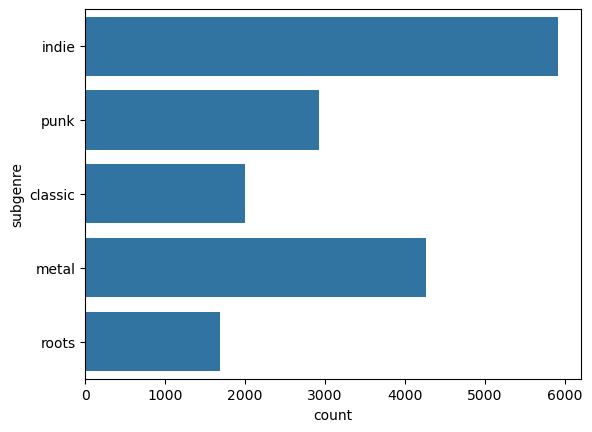

In [82]:
sns.countplot(df['subgenre'])

In [83]:
df.shape

(16781, 10)

In [85]:
df.to_csv('Datasets/df_final.csv', index=False)

In [877]:
df_final = pd.read_csv('Datasets/df_final.csv')
df_final.shape

(16848, 7)

# **``country``** (not really necessary)

## Import dataframes and take quick look

In [902]:
df_artists_origins = pd.read_csv('Datasets/df_artists_origins.csv')                             # df with only the bands and their city of origin
df_coordinates = pd.read_csv('Datasets/df_coordinates.csv')                                     # df with the full info of the locations (coordinates)
df_artists_origins_coordinates = pd.read_csv('Datasets/df_artists_origins_coordinates.csv')     # merge of the bands with the full info of the locations (coordinates)
df_final = pd.read_csv('Datasets/df_final.csv')

# print information
print(f'{df_artists_origins.shape}: df_artists_origins')
print(f'{df_coordinates.shape}: df_coordinates')
print(f'{df_artists_origins_coordinates.shape}: df_artists_origins_coordinates')
print(f'{df_final.shape}: df_final')

(6738, 2): df_artists_origins
(2776, 7): df_coordinates
(6705, 6): df_artists_origins_coordinates
(16848, 7): df_final


In [903]:
# df with only the bands and their city of origin
df_artists_origins.head(2)

,artist,origin
0,Sparta,"El Paso, Texas"
1,Muse,"Teignmouth, Devon, England"


In [904]:
# df with the full info of the locations (coordinates)
df_coordinates.head(2)

,country,city,origin,origin_clean,latitude,longitude,address
0,Argentina,Buenos Aires,"Buenos Aires, Argentina","Buenos Aires, Argentina",-34.608370,-58.444058,"Buenos Aires, Comuna 6, Ciudad Autónoma de Bue..."
1,Argentina,Martínez,"Martínez, Buenos Aires, Argentina","Martínez, Buenos Aires, Argentina",-34.493967,-58.510352,"Martínez, Partido de San Isidro, Buenos Aires,..."


In [905]:
# merge of the bands with the full info of the locations (coordinates)
df_artists_origins_coordinates.head(2)

,artist,country,city,latitude,longitude,address
0,Holy Moses,Deutschland,Aachen,51.132302,6.410734,"Wickrath Bahnhof, Ri. Aachen, Kohlenweg, Wickr..."
1,Mnemic,Danmark,Aalborg,57.046263,9.921526,"Aalborg, Aalborg Kommune, Region Nordjylland, ..."


In [906]:
# albums from the UK and US (until 2010) with >= 20 votes
df_final.head(2)

,year,artist,title,album_length,tracks,subgenre,style
0,2007,!!!,Myth Takes,60.22,13,indie,Alternative Rock
1,2007,!!!,Myth Takes,60.22,13,indie,Indie Rock


## **Merge my dataframe with the locations and get only artists from UK or US**

In [907]:
df_final.shape

(16848, 7)

In [908]:
df_final['artist'].nunique()

4004

In [909]:
df_artists_origins['artist'].nunique()

6738

In [910]:
df_artists_countries = pd.merge(df_artists_origins, df_coordinates, on=['origin'])
df_artists_countries.drop(columns=['city', 'origin_clean', 'latitude', 'longitude', 'address'], inplace=True)
df_artists_countries

,artist,origin,country
0,Sparta,"El Paso, Texas",United States
1,Muse,"Teignmouth, Devon, England",United Kingdom
2,Finch,"Temecula, California, Estados Unidos",United States
3,Transplants,"Los Angeles, California, United States[1]",United States
4,Rooney,"Los Angeles, California, U.S.",United States
...,...,...,...
6701,Until Your Heart Stops,"Oakland, CA, United States",United States
6702,Sleepercar,"El Paso, Texas, USA",United States
6703,Swamp Thing,"Rotorua, New Zealand",New Zealand / Aotearoa
6704,Tim Kasher,"Omaha, Nebraska, US",United States


In [911]:
df_artists_countries['country'].value_counts().head()

country
United States     4139
United Kingdom    1495
Canada             215
Sverige            156
Australia          133
Name: count, dtype: int64

In [912]:
# create the subset with only artists from the UK or US
df_artists_uk_us = df_artists_countries[df_artists_countries['country'].isin(['United States', 'United Kingdom'])]

# it should have 5633 rows
df_artists_uk_us.shape

(5634, 3)

### **Artists in ``artists_to_remove``, from outside the UK or US**

These are the artists that I dropped while getting the location and I realised they were not from the UK or US, from the list ``artists_to_remove``

In [894]:
artists_to_remove = ['Cemetery Skyline', 'Goat', 'Kingcrow', 'Speed', 'Hyperdontia', 'Vredehammer', 'Weston Super Maim',
                'Mdou Moctar', 'AVRALIZE', 'Engulfed', 'Coffin Storm', 'samlrc', 'Little Kid', 'Termina', 'Rorcal',
                'Reverence To Paroxysm', 'Voyager', 'Blindfolded and Led to the Woods', 'Mork', 'Yeule', 'Pond',
                'Empire State Bastard', 'Blood Command', 'Avatar', 'Brutus', 'Faceless Burial', 'Within Destruction',
                'Sedimentum', 'Ataraxy', 'Corpsessed', 'Epitaphe', 'Aldous Harding', 'Messa', 'Ghost', 'Ecchymosis',
                'Wormrot', 'Vertebra Atlantis', 'Papangu', 'Sermon of Flames', 'Springtime', 'Monolord', 'Sulphurous',
                'LLNN', 'Trna', 'Slaughter To Prevail', 'sonhos tomam conta', 'Galvanizer', 'Ophidian I', 'Diabolizer',
                'Morbific', 'Defacement', 'Divide And Dissolve', 'Soen', 'Scorpions', 'Accept', 'Respire', 'Undergang',
                'Bearings', 'Scalp', 'Miasmatic Necrosis', 'Teenage Mutant Ninja Turtles', 'Gorephilia', 'Vous Autres',
                'Carnation', 'Pharmacist', 'Paara', "Justice For The Damned", 'VVilderness', 'Molested Divinity', 'Ellis',
                'Kontinuum', 'Monsters', 'Giver', 'Lowrider', 'Vengeful Spectre', 'Vomit the Soul', 'Sadisme', 'Alarmist',
                'Klone', 'Nocturnal Departure', 'King Gizzard and The Lizard Wizard', 'Make Them Suffer', 'The Chats',
                'Patrick Watson', 'Shirokuma', 'Forests', 'Town Portal', 'Ceremony Of Silence', 'CHAI', 'Baalsebub',
                'Minors', 'Mono', 'Tallies', 'Normandie', 'Mouse On The Keys', 'Burial Invocation', 'Orville Peck',
                'Lunatic Soul', 'Alex Lahey', 'Hozier', 'Mystifier', 'Hands Like Houses', 'Ruins', 'Autokrator',
                'Legend of the Seagullmen', 'Death Toll 80k', 'IDYLLS', 'Spaceslug', 'i hate sex', 'Band-Maid',
                'With the Dead', 'Hungry Ghosts', 'Middle Kids', 'Gleb Kolyadin', "Leaves' Eyes", "Phrenelith",
                "David Brent", "Art Of Dying", "Minor Victories", "Pantha Du Prince", "Schammasch", 'LUH',
                'Violet Cold', 'EL VY', 'Shining', 'Hills', "Mutiny On The Bounty", 'Lucifer', 'FFS', 'Ranger',
                'Trepalium', 'A Textbook Tragedy', 'This Is A Standoff', 'FACT', 'Swallowed', 'Disembarked',
                'Wildbirds and Peacedrums', 'Archivist', 'Timber Timbre', 'Newsboys', 'Dope Lemon', 'Vagabon',
                'RY X', 'Moonlit Sailor', 'The Drones', 'Sarah Neufeld', 'Say Lou Lou', 'Cruciamentum', 'Lay Down Rotten',
                'Dreamshade', 'Sickening Gore', 'Circles', "Avey Tare's Slasher Flicks", 'Forest Silence',
                "One Eyed God Prophecy", 'Coffins', 'Osamu Kitajima', 'Living With Lions', 'Ansur', 'Parades',
                "Intestine Baalism", 'Comity', 'No Omega', 'Wolverine', 'Disavowed', 'Angel Dust', "!T.O.O.H.!",
                'Hypnosia', 'Hexenhaus', 'Paradox', 'Deathrow', 'Excruciate', 'FareWell Poetry', 'Sights and Sounds',
                'Supersister', "Birds Of Tokyo", 'Ark', "The Flower Kings", 'Beardfish', 'Graveworm', 'Acid',
                'Ladyhawke', 'Geddy Lee', 'Yngwie Malmsteen', "World's End Girlfriend", 'Totem Skin', 'Lewis',
                'I Hate Sally', "The Band", 'Lisa Hannigan', 'Lethal', 'Bubu', 'Van She', 'Mooncake', 'The Haunted',
                "Orphaned Land", 'Madder Mortem', 'Kataxu', 'Gilberto Gil', 'Vendetta', 'Kvist', 'Acrostichon', 'Pain',
                'Obliteration', 'Flames of Hell', 'Wombbath', 'Stone', 'Disgrace', 'Fionn Regan', 'Disastrous Murmur',
                'Urfaust', 'Sleepingdog', 'Island', 'Bethlehem', 'Subterranean Masquerade', 'After Dinner', 
                'Black Boned Angel', 'FM', 'Embrace', 'Solefald', 'Maneige', 'Amberian Dawn', 'OOIOO', 'Anekdoten',
                "Aphrodite's Child", 'Hollenthon', 'Lykke Li', 'Lenka', 'Sarah McLachlan', 'Owen Pallett',
                'Devin Townsend Project', 'Missy Higgins', 'The Devin Townsend Band', 'Selda', 'Massacra', "Rory Gallagher",
                'Taste', 'Celestial Season', 'Ida Maria', 'Dark Tranquillity', 'Cadaver', 'Pele', 'Exuma',
                'Great Lake Swimmers', 'Dawn', 'The Bats', 'Yoko Ono', 'Illogicist', 'The Saints', 'Final Fantasy',
                'Pendulum', 'Lunar Aurora', 'Bee Gees', 'Stars', "David Sylvian and Robert Fripp", 'Afflicted', 'Lengsel',
                'Extol', 'MDFMK', 'Univers Zero', 'Mortuary Drape', 'Zyklon', 'Winds', 'Zyklon-B', 'The Sins of Thy Beloved',
                'Lords of Acid', 'Devin Townsend', 'Diablo Swing Orchestra', 'Arcturus', 'Cornelius', 'Manu Chao',
                'Bryan Adams', 'Peaches', 'Doro', 'Kingdom Come', 'Pekka Pohjola', 'Shakira', 'Massacre', 'Subhumans',
                'Set Fire to Flames', 'Gorgoroth', 'Gandalf', 'Klaus Schulze', 'The Ecstasy of Saint Theresa',
                "Lou Reed and John Cale", 'Brian Eno and David Byrne', 'Bob Dylan and The Band', 'Era', 'Devil Doll',
                'Cauterize', 'Roadrunner United', 'Circus Maximus', 'Crowpath', 'Raunchy', 'Tad Morose', 'Kenna',
                'Head Control System', 'Torchbearer', 'Rosesdead', 'Angtoria', 'Nightrage', 'Necros Christos', 'Hypnos 69',
                'Wold', 'Andromeda', 'Chad VanGaalen', 'Melechesh', 'Spheric Universe Experience', 'Anubis Gate',
                'The Project Hate MCMXCIX', 'Myrath', 'Savage Circus', 'Hartfield', 'Evereve', 'Daturah', 'Ad Infinitum',
                'Tash Sultana', 'Tarja Turunen', 'Ram-Zet', 'Sweven', 'Arcane', 'Sons of Apollo', 'Celesty', 'Brainstorm',
                'Unleash The Archers', 'Prostitute Disfigurement', 'The Psyke Project', 'Dornenreich', 'Watain', 'Funeral',
                'Cultes Des Ghoules', 'Revolting', 'Igorrr', 'Symfonia', 'Darkestrah', 'Sarah Blasko', 'Fractal Universe',
                'The End', 'Apotheosis', 'Drautran', 'Monolithe', 'CrazyEightyEight', 'Black Hole', 'Polaris', 'Nug',
                'Klabautamann', 'James LaBrie', 'Vance Joy', 'Helena Deland', 'Authorize', 'Blazon Stone', 'Rapture',
                'Worship', 'Conqueror', 'Swan Lake', 'Yyrkoon', 'Inquisition', 'Kerli', 'Keldian', 'Wake', 'Megiddo',
                'Juanes', 'William Hung', 'Votum', 'Atramentus', 'Abysmal Torment', 'Paul Dempsey', 'Cytotoxin',
                'Vulture Industries', 'Entrails', 'Jorn', 'Conception', 'Centaurus-A', 'Gezan', 'Blood Tsunami',
                'Machinemade God', 'Proscription', 'Ragnarok', 'Zeromancer', 'Satariel', 'Circle of Ouroborus', 'Emeth',
                'Before The Dawn', 'Near Death Condition', 'Ignivomous', 'MEANS', 'Svart Crown', 'Alan Sorrenti', 'Chthonic',
                'Blues Pills', 'Majestica', 'Bedsore', 'Ravencult', 'William Shatner', 'Cheval De Frise', 'Emptiness',
                'WHOURKR', 'Jet Black Stare', 'Despondency', 'October Falls', 'Istapp', 'Slumber', 'Night in Gales',
                'Ov HELL', 'Aficionado', 'Old Silver Key', 'Junior Battles', 'Adversarial', 'Shugo Tokumaru', 'North',
                'Fuck on the Beach', 'Anoice', 'Viscera', 'Two Tongues', 'The Last Felony', 'Revenge', 'The Secret',
                'Cosmic Putrefaction', 'Miseration', 'Azusa', 'Stalaggh', 'Cerebral Effusion', 'Nekromantheon', 'Blasphemer',
                'Pyaemia', 'Inveracity', 'Orchidectomy', 'Kraanium', 'Human Mincer', 'Deformity', 'Kaospilot',
                'Abominable Putridity', 'Iskra', 'Das Oath', 'Torsofuck', 'Internal Suffering', 'Nerlich', 'Blasphemophagher',
                'Head Wound City', 'Inanna', 'Disperse', 'Dishammer', 'Damaar', 'Extortion', 'Starring Janet Leigh',
                'The Arcane Order', "D'espairsRay", 'Demians', "Dave Matthews", 'Monsters of Folk', 'Shrinebuilder',
                'The Joe Perry Project', 'Boygenius', 'Scar the Martyr', 'Gordian Knot', 'Rock Star Supernova']

In [895]:
len(artists_to_remove)

456

## **Concat of both dataframes cleaned**

In [ ]:
df_us_new_masters_2010.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,34278,3370798,5882431,US,Led Zeppelin,Led Zeppelin,2006,367.78,101,"['12""', '45 RPM', 'Single Sided', 'Album', 'Re...",['Rock'],"['Hard Rock', 'Arena Rock', 'Blues Rock']",The English rock band Led Zeppelin was active ...


<Axes: xlabel='count', ylabel='year'>

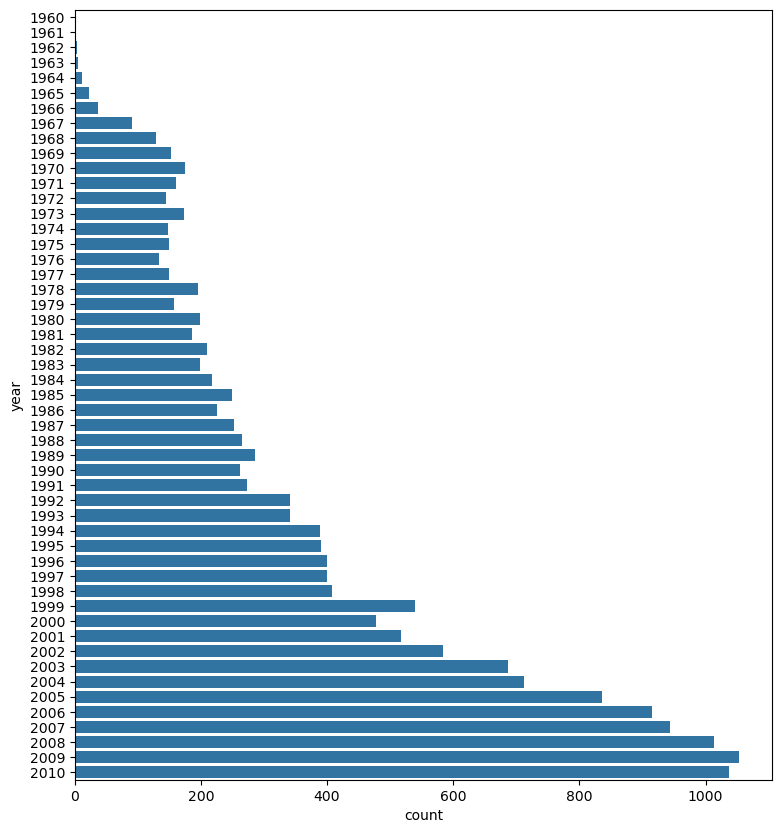

In [914]:
plt.figure(figsize=(9,10))
sns.countplot(data=df_final, y='year')

In [915]:
df_final

,year,artist,title,album_length,tracks,subgenre,style
0,2007,!!!,Myth Takes,60.22,13,indie,Alternative Rock
1,2007,!!!,Myth Takes,60.22,13,indie,Indie Rock
2,2010,!!!,"Strange Weather, Isn't It?",40.80,9,indie,Indie Rock
3,1985,'Til Tuesday,Voices Carry,38.62,10,indie,New Wave
4,1985,'Til Tuesday,Voices Carry,38.62,10,indie,Pop Rock
...,...,...,...,...,...,...,...
16843,2007,xDEATHSTARx,We Are The Threat,35.58,11,metal,Metalcore
16844,2004,yourcodenameis:milo,Ignoto,47.41,12,indie,Alternative Rock
16845,2007,yourcodenameis:milo,They Came From the Sun,49.48,12,indie,Emo
16846,2007,yourcodenameis:milo,They Came From the Sun,49.48,12,indie,Indie Rock
